# Capstone Project
## Using Machine Learning in Trading Futures

Cell below is loading data obtained from [quandl.com](https://quandl.com). You can check how the resulting csv file was produced from raw trading data of futures contracts accross multiple years.

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

fee = 1.5

delta = 0.95
account_size = 10000
stop_loss = 550

trading_days_in_year = 252

start_date = datetime.date(year=2006, month=6, day=13)
end_date = datetime.date(year=2018, month=12, day=30)
validation_date = datetime.date(year=2018, month=1, day=1)

gold = pd.read_csv('data/gold_daily.csv', index_col='Date')
gold_cot = pd.read_csv('data/gold_cot.csv', index_col='Date')

corn = pd.read_csv('data/corn_daily.csv', index_col='Date')
corn_cot = pd.read_csv('data/corn_cot.csv', index_col='Date')

coffee = pd.read_csv('data/coffee_daily.csv', index_col='Date')
coffee_cot = pd.read_csv('data/coffee_cot.csv', index_col='Date')

dow = pd.read_csv('data/dow_daily.csv', index_col='Date')
nasdaq = pd.read_csv('data/nasdaq_daily.csv', index_col='Date')

Convert index to date type.

In [2]:
gold.index = pd.DatetimeIndex(data=gold.index)
gold_cot.index = pd.DatetimeIndex(data=gold_cot.index)

corn.index = pd.DatetimeIndex(data=corn.index)
corn_cot.index = pd.DatetimeIndex(data=corn_cot.index)

coffee.index = pd.DatetimeIndex(data=coffee.index)
coffee_cot.index = pd.DatetimeIndex(data=coffee_cot.index)

dow.index = pd.DatetimeIndex(data=dow.index)
nasdaq.index = pd.DatetimeIndex(data=nasdaq.index)

Ensure that dataframe is sorted by index (date).

In [3]:
gold = gold.sort_index(kind='mergesort')
gold_cot = gold_cot.sort_index(kind='mergesort')
corn = corn.sort_index(kind='mergesort')
corn_cot = corn_cot.sort_index(kind='mergesort')
coffee = coffee.sort_index(kind='mergesort')
coffee_cot = coffee_cot.sort_index(kind='mergesort')
dow = dow.sort_index(kind='mergesort')
nasdaq = nasdaq.sort_index(kind='mergesort')

Remove older dataframe - because we are missing COT.

In [4]:
gold = gold.loc[gold.index >= '2006-06-13']
corn = corn.loc[corn.index >= '2006-06-13']
coffee = coffee.loc[coffee.index >= '2006-06-13']

In [5]:
gold_cot.head(10)

,Open Interest,Producer/Merchant/Processor/User Longs,Producer/Merchant/Processor/User Shorts,Swap Dealer Longs,Swap Dealer Shorts,Swap Dealer Spreads,Money Manager Longs,Money Manager Shorts,Money Manager Spreads,Other Reportable Longs,Other Reportable Shorts,Other Reportable Spreads,Total Reportable Longs,Total Reportable Shorts,Non Reportable Longs,Non Reportable Shorts
Date,,,,,,,,,,,,,,,,
2006-06-13,382474.0,42587.0,128892.0,19370.0,66611.0,22998.0,103211.0,30916.0,46704.0,33230.0,10656.0,58412.0,326513.0,365190.0,55961.0,17284.0
2006-06-20,390281.0,47440.0,126992.0,22404.0,64682.0,25806.0,94632.0,30963.0,48730.0,32947.0,11142.0,64458.0,336417.0,372774.0,53864.0,17507.0
2006-06-27,384321.0,48449.0,121890.0,22425.0,62640.0,25151.0,91042.0,32287.0,49614.0,31307.0,11386.0,59762.0,327749.0,362729.0,56572.0,21592.0
2006-07-03,392868.0,48087.0,122568.0,22720.0,69714.0,26352.0,92545.0,30452.0,50821.0,32874.0,8677.0,63514.0,336914.0,372098.0,55955.0,20771.0
2006-07-11,427008.0,54509.0,130618.0,21840.0,79217.0,28805.0,104213.0,27624.0,54922.0,33165.0,11194.0,70944.0,368398.0,403323.0,58611.0,23685.0
2006-07-18,443519.0,49863.0,131166.0,21681.0,83183.0,33352.0,107413.0,24296.0,62395.0,31760.0,9442.0,74272.0,380737.0,418105.0,62782.0,25414.0
2006-07-25,432413.0,52859.0,133290.0,22956.0,85604.0,28832.0,99087.0,22386.0,64810.0,29740.0,6244.0,73980.0,372265.0,415146.0,60148.0,17266.0
2006-08-01,394609.0,45161.0,135988.0,21250.0,73244.0,23643.0,99330.0,24391.0,54618.0,32195.0,4758.0,57618.0,333815.0,374260.0,60795.0,20350.0
2006-08-08,402899.0,46203.0,142240.0,20703.0,72061.0,24259.0,104600.0,24271.0,57785.0,33123.0,6489.0,57914.0,344587.0,385020.0,58312.0,17880.0


### COT Feature engineering
Determine how far we are from top across last 2 years (730 days).

In [6]:
def percentage_from_max(sr):
    mx = sr.max()
    mn = sr.min()
    return (sr[-1]-mn)/(mx-mn)

def max_positions_percentage(df):
    df['Prod_net_position'] = df['Producer/Merchant/Processor/User Longs'] - df['Producer/Merchant/Processor/User Shorts']
    df['Prod_net_position_perc'] = df.rolling('730d')['Prod_net_position'].apply(percentage_from_max, raw=False)
    df['Money_manager_net_position'] = df['Money Manager Longs'] - df['Money Manager Shorts']
    df['Money_manager_net_position_perc'] = df.rolling('730d')['Money_manager_net_position'].apply(percentage_from_max, raw=False)
    df = df[['Prod_net_position_perc', 'Money_manager_net_position_perc']]
    return df

In [7]:
gold_cot = max_positions_percentage(gold_cot)
corn_cot = max_positions_percentage(corn_cot)
coffee_cot = max_positions_percentage(coffee_cot)

### Williams %R
Create feature with Williams %R indicator

In [8]:
# code from stockstats pypy package
def get_wr(df, n_days):
    """ Williams Overbought/Oversold Index
    WMS=[(Hn—Ct)/(Hn—Ln)] ×100
    Ct - the close price
    Hn - N days high
    Ln - N days low
    :param df: data
    :param n_days: N days
    :return: None
    """
    n_days = int(n_days)
    ln = df['Low'].rolling(min_periods=1, window=n_days,
                           center=False).min()
    hn = df['High'].rolling(min_periods=1, window=n_days,
                            center=False).max()
    column_name = 'wr_{}'.format(n_days)
    column_name = 'wr'
    df[column_name] = (hn - df['Settle']) / (hn - ln) * 100

### Create Targets
Based on the threshold, fee and delta calculate targets used for supervised learning.

In [9]:
def calculate_target(row, threshold):
    global fee, delta, stop_loss
    volatility = (row['Settle']-row['Open'])*delta
    if abs(volatility) > fee + threshold:
        if volatility > 0:
            return 1
        else:
            return -1
    else:
        return 0
    return df


def create_trade_outcomes(df, contracts, threshold):
    ans_df = pd.DataFrame([])
    ans_df['gains'] = (df['Settle'] - df['Open'])*0.95*contracts
    ans_df = pd.concat([ans_df, df[['Open', 'High', 'Low', 'Settle']]*contracts], axis=1)
    ans_df['target'] = ans_df.apply(lambda x: calculate_target(x, threshold), axis=1)
    print(ans_df.head(5))
    return ans_df.shift(-1)

In [10]:
threshold = 500
contracts = 100
gold_gains = create_trade_outcomes(gold, contracts, threshold)
gold_gains_train = gold_gains.loc[gold_gains.index < '2018-1-1']
# gold_gains.head(20)

             gains     Open     High      Low   Settle  target
Date                                                          
2006-06-13 -2251.5  59050.0  59500.0  56550.0  56680.0      -1
2006-06-14  -332.5  57000.0  57550.0  56540.0  56650.0       0
2006-06-15  -304.0  57350.0  57950.0  56950.0  57030.0       0
2006-06-16    47.5  58120.0  58250.0  57050.0  58170.0       0
2006-06-19   -38.0  57280.0  57840.0  57100.0  57240.0       0


In [11]:
# get_wr(gold, 14)
gold = pd.concat([gold, gold_gains[['target']]], axis=1)
gold.head(15)

,Open,High,Low,Settle,Volume,Prev. Day Open Interest,target
Date,,,,,,,
2006-06-13,590.5,595.0,565.5,566.8,93899.0,192616.0,0.0
2006-06-14,570.0,575.5,565.4,566.5,68729.0,192917.0,0.0
2006-06-15,573.5,579.5,569.5,570.3,52628.0,193887.0,0.0
2006-06-16,581.2,582.5,570.5,581.7,43947.0,189585.0,0.0
2006-06-19,572.8,578.4,571.0,572.4,27362.0,189168.0,1.0
2006-06-20,572.0,581.0,567.8,580.5,39962.0,187696.0,1.0
2006-06-21,577.0,591.5,573.5,591.0,43918.0,187072.0,0.0
2006-06-22,588.0,593.5,584.5,585.4,42916.0,187027.0,1.0
2006-06-23,574.5,589.0,574.5,588.0,33705.0,181290.0,0.0


### Trade gains investigation

Ivestigate trade gains
- have a look at all gains (regardless of label)
- analyze gains for long trades (label 1)
- analyze gains for short trades (label -1)

### Trade labels distribution

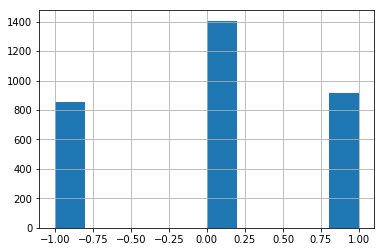

In [12]:
gold['target'].hist()

In [13]:
gold_gains_train.gains.describe()

count     2921.000000
mean        -6.878637
std       1225.716089
min     -11390.500000
25%       -560.500000
50%         28.500000
75%        627.000000
max       6555.000000
Name: gains, dtype: float64

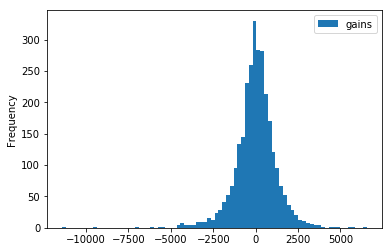

In [14]:
gold_gains_train[['gains']].plot.hist(bins=80)

In [15]:
def stop_loss_gen(df):
    df['Open_High'] = df['High'] - df['Open']
    df['Open_Low'] = df['Open'] - df['Low']
    return df

In [16]:
gold_gains_train = stop_loss_gen(gold_gains_train)

/home/martin/anaconda3/envs/trading/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/martin/anaconda3/envs/trading/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [17]:
def plot_histogram_cumsum(df, column):
    df[column].hist(bins=50, density=True, cumulative=-1, figsize=(10,5))
    df[column].hist(bins=50, density=True, linewidth=1.5, cumulative=True, histtype='step', figsize=(10,5))
    plt.plot([0, df[column].max()], [0.9, 0.9], lw=1, color='r')

### Investigate suitable stop-loss value

Below are cummulative curves.
Red line denotes 90% mark. What stop-loss should you use when you want 90% of trades to get completed (trade from open  to close)?

Following curves are investigating stop losses based on the label.

| trade | commodity | stop loss |
|-------|-----------|-----------|
| long  |      gold |      1000 |
| short |      gold |       800 |
| long  |      corn |       300 |
| short |      corn |       300 |
| long  |    coffee |       800 |
| short |    coffee |       800 |



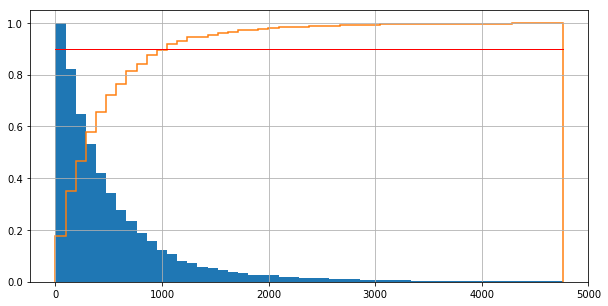

In [18]:
plot_histogram_cumsum(gold_gains_train[gold_gains_train.target == 1], 'Open_Low')

In [19]:
gold_gains_train[gold_gains_train.target == 1].Open_Low.describe()

count     860.000000
mean      472.825581
std       538.691375
min         0.000000
25%       130.000000
50%       310.000000
75%       640.000000
max      4760.000000
Name: Open_Low, dtype: float64

In [20]:
gold_gains_train[gold_gains_train.target == -1].Open_High.describe()

count     802.000000
mean      429.077307
std       439.462157
min         0.000000
25%       150.000000
50%       310.000000
75%       570.000000
max      4380.000000
Name: Open_High, dtype: float64

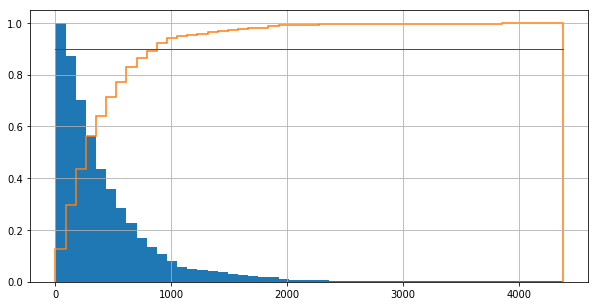

In [21]:
plot_histogram_cumsum(gold_gains_train[gold_gains_train.target == -1], 'Open_High')

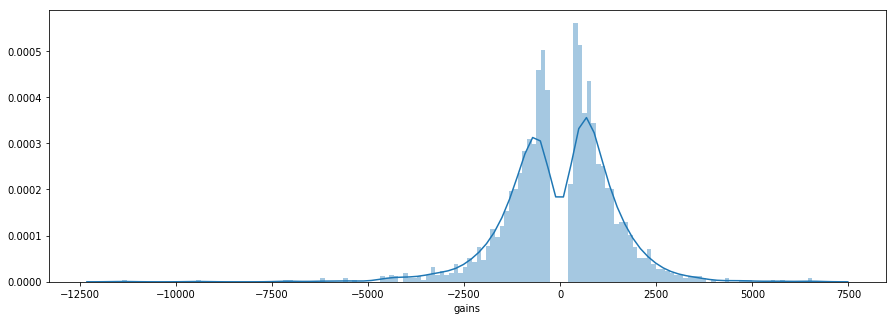

In [22]:
sr = gold_gains_train.loc[gold_gains_train.index < '2018-01-01'][gold_gains_train.gains.abs() > 300].gains
fig, ax = plt.subplots(figsize=(15,5))
sns.distplot(sr, bins=150, ax=ax)

In [23]:
# Corn Contract has 5000 bushels contract is in cents therefore 50 contracts are producing desired values
contracts = 50
threshold = 150
corn_gains = create_trade_outcomes(corn, contracts, threshold)
corn_gains_train = corn_gains.loc[corn_gains.index < '2018-1-1']

              gains     Open     High      Low   Settle  target
Date                                                           
2006-06-13 -213.750  12387.5  12400.0  12112.5  12162.5      -1
2006-06-14 -332.500  12200.0  12262.5  11837.5  11850.0      -1
2006-06-15 -213.750  11875.0  11937.5  11600.0  11650.0      -1
2006-06-16   71.250  12987.5  13137.5  12962.5  13062.5       0
2006-06-19 -154.375  12950.0  13050.0  12750.0  12787.5      -1


In [24]:
corn_gains_train.gains.describe()

count    2917.000000
mean        6.122729
std       411.069273
min     -1983.125000
25%      -190.000000
50%        11.875000
75%       213.750000
max      1888.125000
Name: gains, dtype: float64

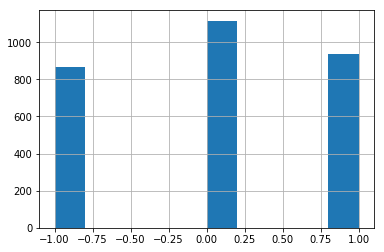

In [25]:
# get_wr(corn, 14)
corn = pd.concat([corn, corn_gains[['target']]], axis=1)

corn.loc[corn.index < '2018-1-1'].target.hist()

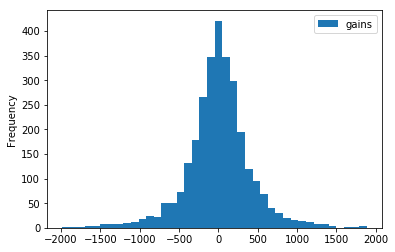

In [26]:
corn_gains_train[['gains']].plot.hist(bins=40)

In [27]:
corn_gains_train.head(10)

,gains,Open,High,Low,Settle,target
Date,,,,,,
2006-06-13,-332.500,12200.0,12262.5,11837.5,11850.0,-1.0
2006-06-14,-213.750,11875.0,11937.5,11600.0,11650.0,-1.0
2006-06-15,71.250,12987.5,13137.5,12962.5,13062.5,0.0
2006-06-16,-154.375,12950.0,13050.0,12750.0,12787.5,-1.0
2006-06-19,-23.750,12825.0,12837.5,12675.0,12800.0,0.0
2006-06-20,142.500,12800.0,12975.0,12775.0,12950.0,0.0
2006-06-21,-95.000,12950.0,13025.0,12800.0,12850.0,0.0
2006-06-22,-83.125,12850.0,12887.5,12737.5,12762.5,0.0
2006-06-23,-225.625,12687.5,12687.5,12387.5,12450.0,-1.0


In [28]:
corn_gains = stop_loss_gen(corn_gains)
corn_gains_train = corn_gains[corn_gains.index < '2018-1-1']

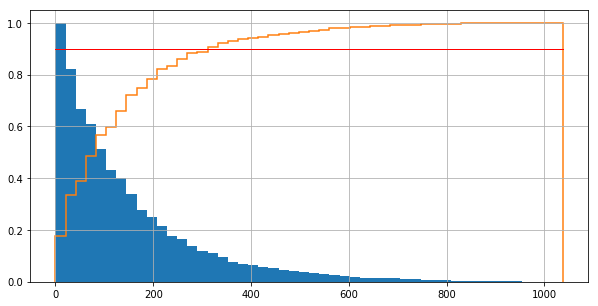

In [29]:
plot_histogram_cumsum(corn_gains_train[corn_gains_train.target == 1], 'Open_Low')

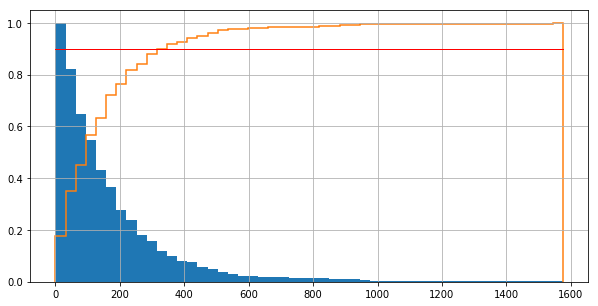

In [30]:
plot_histogram_cumsum(corn_gains_train[corn_gains_train.target == -1], 'Open_High')

/home/martin/anaconda3/envs/trading/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


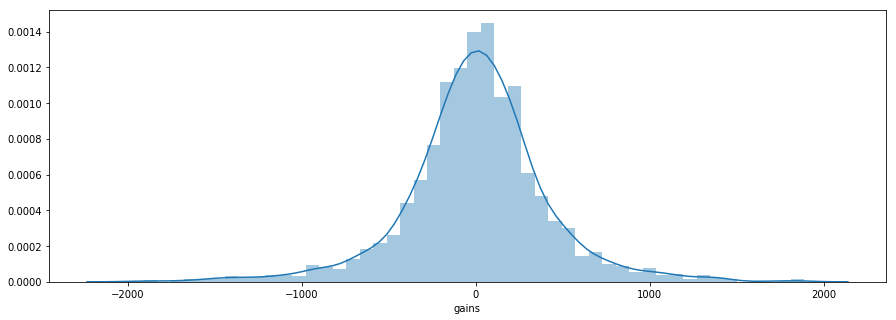

In [31]:
sr = corn_gains_train.gains
fig, ax = plt.subplots(figsize=(15,5))
sns.distplot(sr, ax=ax)

/home/martin/anaconda3/envs/trading/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


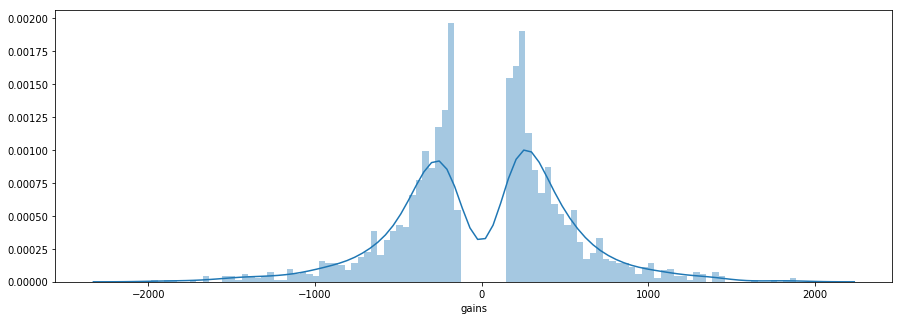

In [32]:
sr = corn_gains_train[corn_gains.gains.abs() > 150].gains
fig, ax = plt.subplots(figsize=(15,5))
sns.distplot(sr, bins=100, ax=ax)

In [33]:
# coffee contract size is 37,500 pounds price is in cents per pound
contracts = 375
threshold = 275
coffee_gains = create_trade_outcomes(coffee, contracts, threshold)
coffee_gains = stop_loss_gen(coffee_gains)
coffee_gains_train = coffee_gains.loc[coffee_gains.index < '2018-1-1']

            gains      Open     High      Low    Settle  target
Date                                                           
2006-06-13    0.0  36731.25  37050.0  36712.5  36731.25       0
2006-06-14    0.0  36918.75  37275.0  36600.0  36918.75       0
2006-06-15    0.0  37106.25  37425.0  36937.5  37106.25       0
2006-06-16    0.0  36637.50  37350.0  36337.5  36637.50       0
2006-06-19    0.0  36468.75  36712.5  36375.0  36468.75       0


In [34]:
coffee_gains_train.gains.describe()

count    2908.000000
mean      -11.546273
std      1070.462227
min     -5236.875000
25%      -516.562500
50%         0.000000
75%       498.750000
max      6341.250000
Name: gains, dtype: float64

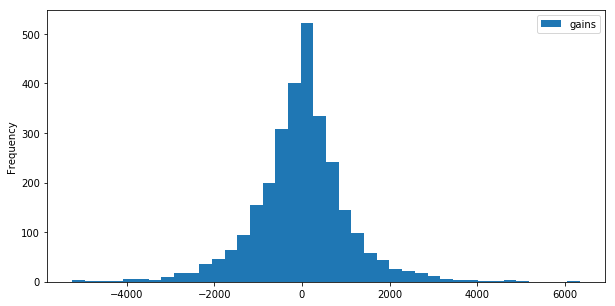

In [35]:
coffee_gains_train[['gains']].plot.hist(bins=40, figsize=(10, 5))

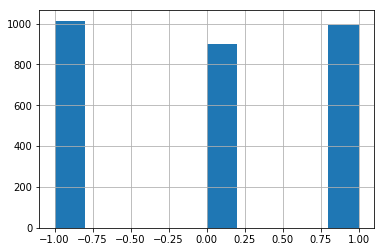

In [36]:
# get_wr(coffee, 14)
coffee = pd.concat([coffee, coffee_gains[['target']]], axis=1)
coffee.loc[coffee.index < '2018-1-1'].target.hist()

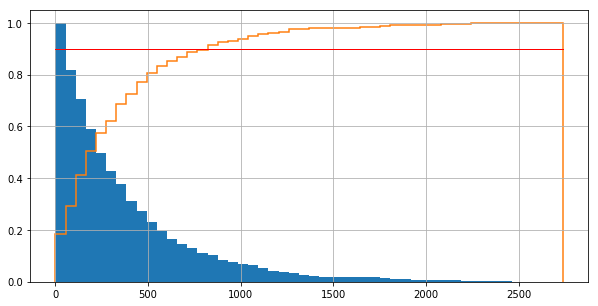

In [37]:
plot_histogram_cumsum(coffee_gains_train[coffee_gains_train.target == 1], 'Open_Low')

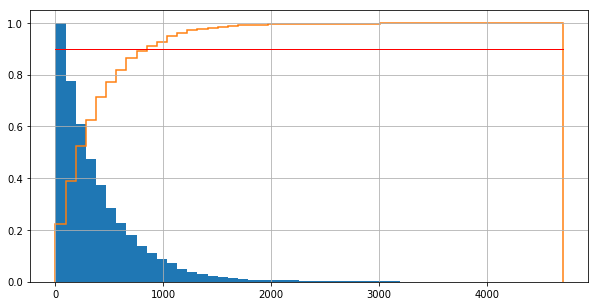

In [38]:
plot_histogram_cumsum(coffee_gains_train[coffee_gains_train.target == -1], 'Open_High')

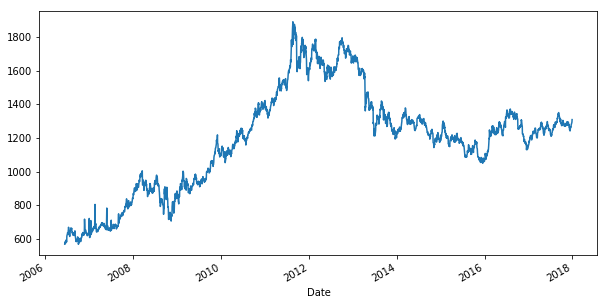

In [39]:
gold.loc[gold.index < '2018-01-01']['Settle'].plot(figsize=(10, 5))

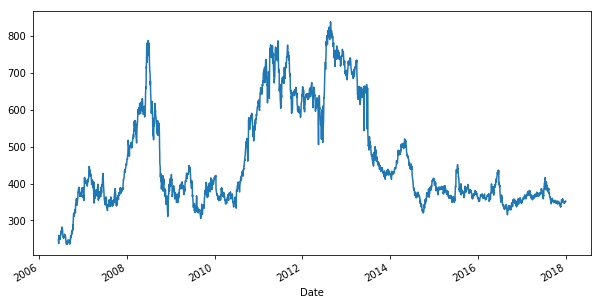

In [40]:
corn.loc[corn.index < '2018-01-01']['Open'].plot(figsize=(10, 5))

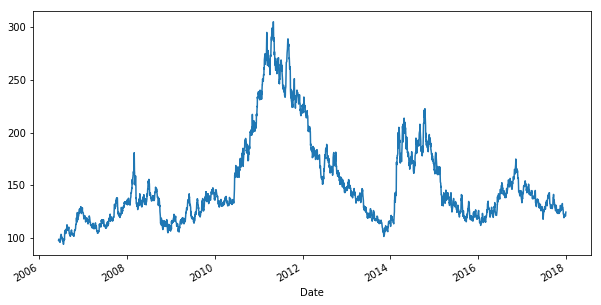

In [41]:
coffee.loc[coffee.index < '2018-01-01']['Open'].plot(figsize=(10, 5))

In [42]:
import numpy as np
import holidays

def trading_day_of_month(tm):
    ts = (tm - np.datetime64('1970-01-01')) / np.timedelta64(1, 's')
    dt = datetime.datetime.fromtimestamp(ts)
    di = datetime.date(year=dt.year, month=dt.month, day=1)
    us_holidays = holidays.UnitedStates()
    cnt = 1
    for i in range(1, 32):
        if i == dt.day:
            break
        if di.weekday() in [0, 1, 2, 3, 4] and dt not in us_holidays:
            cnt += 1
        di += datetime.timedelta(days=1)
    return cnt


def create_cycle(x, period):
    sn = np.sin(x*(2.*np.pi/period))
    cs = np.cos(x*(2.*np.pi/period))
    return sn, cs


def create_vectors(df, df_cot):
    global trading_days_in_year
    nv = df.shape[1]-2
    i_t = df.shape[1]-1
    ans_dct = {}
    for i in range(df.shape[0]):
        if i < 2*trading_days_in_year:
            continue
        mtrx = df.iloc[i-2*trading_days_in_year:i, 0:nv].values
        size = np.prod(mtrx.shape)
        mtrx = list(mtrx.reshape(size))
        idx = df.index.values[i]
        # add COT report to the end of list
        mtrx_cot = df_cot[df_cot.index < idx].values[-8:]
        size = np.prod(mtrx_cot.shape)
        mtrx_cot = list(mtrx_cot.reshape(size))
        if size < 16:
            mtrx_cot += [0 for i in range(16-size)]
        # Date Features
        ts = (idx - np.datetime64('1970-01-01')) / np.timedelta64(1, 's')
        dt = datetime.datetime.fromtimestamp(ts)
        wsn, wcs = create_cycle(dt.weekday(), 5)
        # period for trading day in month is at most 23
        tsn, tcs = create_cycle(trading_day_of_month(idx), 23)
        dsn, dcs = create_cycle(dt.month, 12)
        qsn, qcs = create_cycle((dt.month-1)//3, 4)
        mtrx_date = [wsn, wcs, tsn, tcs, dsn, dcs, qsn, qcs]
        # mtrx_date = [wsn, wcs, tsn, tcs, dsn, dcs, qsn, qcs, df.loc[idx].wr]
        # mtrx_date = [dt.weekday(), trading_day_of_month(idx), dt.month, (dt.month-1)//3, df.loc[idx].wr]
        # Combine list
        mtrx = mtrx + mtrx_cot + mtrx_date
        mtrx.append(df.iloc[i, i_t])
        ans_dct[idx] = mtrx
    return pd.DataFrame.from_dict(ans_dct, orient='index')

In [43]:
gold_data = create_vectors(gold, gold_cot)
gold_data = gold_data.loc[:end_date]
corn_data = create_vectors(corn, corn_cot)
corn_data = corn_data.loc[:end_date]
coffee_data = create_vectors(coffee, coffee_cot)
coffee_data = coffee_data.loc[:end_date]

cols = list(range(2544))
gold_data_reg = gold_data[cols].join(gold_gains[['gains']].rename(columns={"gains": 2544}))
corn_data_reg = corn_data[cols].join(corn_gains[['gains']].rename(columns={"gains": 2544}))
coffee_data_reg = coffee_data[cols].join(corn_gains[['gains']].rename(columns={"gains": 2544}))

In [44]:
gold_data.tail()

,0,1,2,3,4,5,6,7,8,9,...,2535,2536,2537,2538,2539,2540,2541,2542,2543,2544
2018-12-21,1134.0,1138.8,1131.0,1133.2,110023.0,1133.2,1135.5,1128.6,1130.7,115561.0,...,0.346733,-0.951057,0.309017,-0.816970,-0.576680,-2.449294e-16,1.0,-1.0,-1.836970e-16,1.0
2018-12-24,1133.2,1135.5,1128.6,1130.7,115561.0,1130.0,1137.3,1129.5,1133.6,71039.0,...,0.346733,0.000000,1.000000,-0.942261,-0.334880,-2.449294e-16,1.0,-1.0,-1.836970e-16,0.0
2018-12-26,1130.0,1137.3,1129.5,1133.6,71039.0,1135.3,1151.7,1132.8,1138.8,102763.0,...,0.346733,0.587785,-0.809017,-0.979084,0.203456,-2.449294e-16,1.0,-1.0,-1.836970e-16,1.0
2018-12-27,1135.3,1151.7,1132.8,1138.8,102763.0,1139.3,1145.1,1137.1,1140.9,100470.0,...,0.346733,-0.587785,-0.809017,-0.887885,0.460065,-2.449294e-16,1.0,-1.0,-1.836970e-16,0.0
2018-12-28,1139.3,1145.1,1137.1,1140.9,100470.0,1143.1,1160.6,1142.6,1158.1,153065.0,...,0.346733,-0.951057,0.309017,-0.730836,0.682553,-2.449294e-16,1.0,-1.0,-1.836970e-16,0.0


In [45]:
gold_data_reg.head()

,0,1,2,3,4,5,6,7,8,9,...,2535,2536,2537,2538,2539,2540,2541,2542,2543,2544
2008-06-06,590.5,595.0,565.5,566.8,93899.0,570.0,575.5,565.4,566.5,68729.0,...,0.698322,-0.951057,0.309017,0.979084,0.203456,1.224647e-16,-1.0,1.0,6.123234e-17,-760.0
2008-06-09,570.0,575.5,565.4,566.5,68729.0,573.5,579.5,569.5,570.3,52628.0,...,0.698322,0.000000,1.000000,0.997669,-0.068242,1.224647e-16,-1.0,1.0,6.123234e-17,-2213.5
2008-06-10,573.5,579.5,569.5,570.3,52628.0,581.2,582.5,570.5,581.7,43947.0,...,0.698322,0.951057,0.309017,0.942261,-0.334880,1.224647e-16,-1.0,1.0,6.123234e-17,1111.5
2008-06-11,581.2,582.5,570.5,581.7,43947.0,572.8,578.4,571.0,572.4,27362.0,...,0.584221,0.587785,-0.809017,0.816970,-0.576680,1.224647e-16,-1.0,1.0,6.123234e-17,-1092.5
2008-06-12,572.8,578.4,571.0,572.4,27362.0,572.0,581.0,567.8,580.5,39962.0,...,0.584221,-0.587785,-0.809017,0.631088,-0.775711,1.224647e-16,-1.0,1.0,6.123234e-17,199.5


In [46]:
gold_data.shape

(2668, 2545)

In [47]:
gold_cot.head(5)

,Prod_net_position_perc,Money_manager_net_position_perc
Date,,
2006-06-13,NaN,NaN
2006-06-20,1.000000,0.000000
2006-06-27,1.000000,0.000000
2006-07-03,0.919154,0.246529
2006-07-11,0.792600,1.000000


In [48]:
gold_data = gold_data.loc[gold_data.index >= '2007-01-01']
corn_data = corn_data.loc[corn_data.index >= '2007-01-01']
coffee_data = coffee_data.loc[coffee_data.index >= '2007-01-01']

gold_data_reg = gold_data_reg.loc[gold_data_reg.index >= '2007-01-01']
corn_data_reg = corn_data_reg.loc[corn_data_reg.index >= '2007-01-01']
coffee_data_reg = coffee_data_reg.loc[coffee_data_reg.index >= '2007-01-01']

In [49]:
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.decomposition import FactorAnalysis

validate_date = '2018-01-01'


def data_split_pca_transform(df):
    global validate_date
    label_index = 2544
    df_validate = df.loc[validate_date <= df.index]
    df_data_tt = df.loc[validate_date > df.index]
    df_train, df_test, label_train, label_test = train_test_split(df_data_tt[list(range(label_index))], df_data_tt[label_index], test_size=0.2, random_state=2242)
    
    pca = PCA(n_components=200, random_state=2234)
    # pca = FactorAnalysis(n_components=5, random_state=2234)
    pca.fit(df_train[list(range(label_index))])
    
    return df_train, df_test, label_train, label_test, df_validate[list(range(label_index))], df_validate[label_index], pca


def pca_transform(df, pca):
    label_index = 2544
    df_pca = pca.transform(df[list(range(label_index))])
    
    return df_pca

In [50]:
gold_train, gold_test, gold_label_train, gold_label_test, gold_validate, gold_label_validate, gold_pca = data_split_pca_transform(gold_data)
corn_train, corn_test, corn_label_train, corn_label_test, corn_validate, corn_label_validate, corn_pca = data_split_pca_transform(corn_data)
coffee_train, coffee_test, coffee_label_train, coffee_label_test, coffee_validate, coffee_label_validate, coffee_pca = data_split_pca_transform(coffee_data)

gold_reg_train, gold_reg_test, gold_reg_label_train, gold_reg_label_test, gold_reg_validate, gold_reg_label_validate, gold_reg_pca = data_split_pca_transform(gold_data_reg)
corn_reg_train, corn_reg_test, corn_reg_label_train, corn_reg_label_test, corn_reg_validate, corn_reg_label_validate, corn_reg_pca = data_split_pca_transform(corn_data_reg)
coffee_reg_train, coffee_reg_test, coffee_reg_label_train, coffee_reg_label_test, coffee_reg_validate, coffee_reg_label_validate, coffee_reg_pca = data_split_pca_transform(coffee_data_reg)

# Outlier detection
The code below is using random forest. I am relying on automatic outlier detection.

In [51]:
from sklearn.ensemble import IsolationForest
# from sklearn.neighbors import LocalOutlierFactor

pca_gold = pca_transform(gold_train, gold_pca)
out_gold = IsolationForest(contamination='auto', behaviour='new')
# out = LocalOutlierFactor()
modified_gold = out_gold.fit_predict(pca_gold)

pca_corn = pca_transform(corn_train, corn_pca)
out_corn = IsolationForest(contamination='auto', behaviour='new')
# out = LocalOutlierFactor()
modified_corn = out_corn.fit_predict(pca_corn)

pca_coffee = pca_transform(coffee_train, coffee_pca)
out_coffee = IsolationForest(contamination='auto', behaviour='new')
# out = LocalOutlierFactor()
modified_coffee = out_coffee.fit_predict(pca_coffee)


def remove_outliers(arr, y, isolation):
    lst = out_gold.predict(X)
    a = []
    y_a = []
    for v, h, k in zip(lst, y, X):
        if v == 1:
            a.append(k)
            y_a.append(h)
    a = np.array(a)
    y_a = np.array(y_a)
    return a, y_a

In [52]:
def plot_hist_perc(x):
    df = pd.DataFrame(x)

    ln = df[0].count()
    dct = {}
    dct[-1] = df[df[0] == -1][0].count() / ln
    dct[1] = df[df[0] == 1][0].count() / ln
    
    print('outliers: ' + str(df[df[0] == -1][0].count()))
    print('inliers: ' + str(df[df[0] == 1][0].count()))

    rf = pd.DataFrame.from_dict(dct, orient='index')

    ax = rf.plot(kind='bar', figsize=(10,5), legend=False)
    for i in ax.patches:
        ax.text(i.get_x()-.2, i.get_height()-.05, \
                str(round(i.get_height(),4)), fontsize=15)

outliers: 3
inliers: 1930


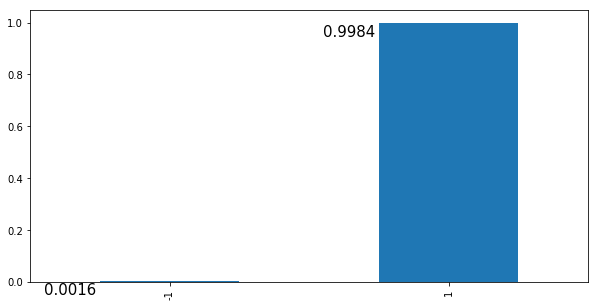

In [53]:
plot_hist_perc(modified_gold)

outliers: 15
inliers: 1915


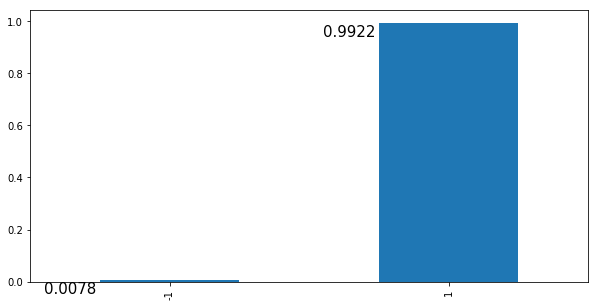

In [54]:
plot_hist_perc(modified_corn)

Coffee data contains unusualy big number of outliers - maybe this could be modified by increasing number of PCA components.

outliers: 345
inliers: 1578


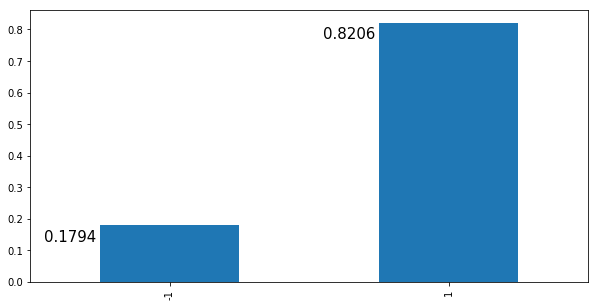

In [55]:
plot_hist_perc(modified_coffee)

In [56]:
def create_pca_training(df, df_pca, name, validation=0.2):
    gdf = pd.DataFrame(pca_transform(df.loc[df.index < '2018-1-1'], df_pca))
    gdf['label'] = np.array(list(map(lambda x: x if x >= 0 else 0, df.loc[df.index < '2018-1-1'][2544].values)))
    gdf['label'] = gdf.label.astype(int)
    test_df = gdf.sample(frac=validation)
    test_df = test_df.reset_index()
    test_df = test_df.drop(columns=['index'])
    train_df = gdf.drop(test_df.index)
    train_df = train_df.reset_index()
    train_df = train_df.drop(columns=['index'])
    test_df.to_csv(name + '_long_validation.csv', index=False)
    train_df.to_csv(name + '_long_train.csv', index=False)
    
    gdf_test = pd.DataFrame(pca_transform(df.loc[df.index >= '2018-1-1'], df_pca))
    gdf_test['label'] = np.array(list(map(lambda x: x if x >= 0 else 0, df.loc[df.index >= '2018-1-1'][2544].values)))
    gdf_test['label'] = gdf_test.label.astype(int)
    gdf_test.to_csv(name + '_long_test.csv', index=False)

    gdf = pd.DataFrame(pca_transform(df.loc[df.index < '2018-1-1'], df_pca))
    gdf['label'] = np.array(list(map(lambda x: 1 if x < 0 else 0, df.loc[df.index < '2018-1-1'][2544].values)))
    gdf['label'] = gdf.label.astype(int)
    test_df = gdf.sample(frac=validation)
    test_df = test_df.reset_index()
    test_df = test_df.drop(columns=['index'])
    train_df = gdf.drop(test_df.index)
    train_df = train_df.reset_index()
    train_df = train_df.drop(columns=['index'])
    test_df.to_csv(name + '_short_validation.csv', index=False)
    train_df.to_csv(name + '_short_train.csv', index=False)
    
    gdf_test = pd.DataFrame(pca_transform(df.loc[df.index >= '2018-1-1'], df_pca))
    gdf_test['label'] = np.array(list(map(lambda x: 1 if x < 0 else 0, df.loc[df.index >= '2018-1-1'][2544].values)))
    gdf_test['label'] = gdf_test.label.astype(int)
    gdf_test.to_csv(name + '_short_test.csv', index=False)


def create_pca_reg_training(df, df_pca, name, validation=0.2):
    gdf = pd.DataFrame(pca_transform(df.loc[df.index < '2018-1-1'], df_pca))
    gdf[80] = df.loc[df.index < '2018-1-1'][2544].values
    # print(gdf.head())
    # gdf['label'] = np.array(list(map(lambda x: x if x >= 0 else 0, df.loc[df.index < '2018-1-1'][2544].values)))
    # gdf['label'] = gdf.label.astype(int)
    test_df = gdf.sample(frac=validation)
    test_df = test_df.reset_index()
    test_df = test_df.drop(columns=['index'])
    train_df = gdf.drop(test_df.index)
    train_df = train_df.reset_index()
    train_df = train_df.drop(columns=['index'])
    test_df.to_csv(name + '_validation.csv', index=False)
    train_df.to_csv(name + '_train.csv', index=False)
    
    gdf_test = pd.DataFrame(pca_transform(df.loc[df.index >= '2018-1-1'], df_pca))
    gdf_test[80] = df.loc[df.index >= '2018-1-1'][2544].values
    gdf_test.to_csv(name + '_test.csv', index=False)


create_pca_training(gold_data, gold_pca, 'data/gold_pca')
create_pca_training(corn_data, corn_pca, 'data/corn_pca')
create_pca_training(coffee_data, coffee_pca, 'data/coffee_pca')

create_pca_reg_training(gold_data_reg, gold_pca, 'data/gold_pca_reg')
create_pca_reg_training(corn_data_reg, corn_pca, 'data/corn_pca_reg')
create_pca_reg_training(coffee_data_reg, coffee_pca, 'data/coffee_pca_reg')

### Dimension reduction with PCA

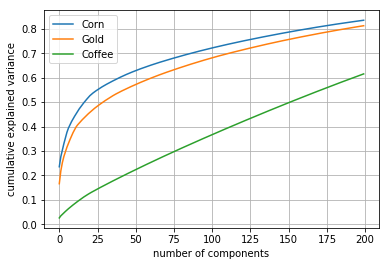

In [57]:
plt.plot(np.cumsum(corn_pca.explained_variance_ratio_), label='Corn')
plt.plot(np.cumsum(gold_pca.explained_variance_ratio_), label='Gold')
plt.plot(np.cumsum(coffee_pca.explained_variance_ratio_), label='Coffee')
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.grid(True)
plt.legend()
plt.show()

It is intereresting Corn is best expalined by PCA transformation. It is probably due to clear seasonal patterns in trading.

I am surprised that gold is better explained by PCA transformation than Coffee. I would expect that coffee has stronger seasonal trading patterns than gold because of the growth cycle. Maybe gold mining is subject to the weather in similar way as agricultural commodities. Gold is still mostly recycled and new production has limited impact on total amount of traded gold.

Possible explanations:
- corn traded on CME is mostly US produced with stable harvest season
- production of coffee is very unpredictable depending on the conditions of a given year
- there are multiple producers around the world (coffee is more of a global market with limited US production) with different harvest periods https://driftaway.coffee/when-is-coffee-harvested/
- important difference between coffee and corn is price per unit corn is much less efficient to transport
    - 1 kg of corn is worth about 15¢
    - 1 kg of coffee is worth about 230¢
    
Based on this graph I think that pca transformation is not suitable for coffee. Information in components is growing linearly. If we don't see sharp increase of cumulative explained variance with few first components then PCA transformation is not suitable. Therefore coffee should not be considered for trading. I will continue with coffee as well but based on this transformation I would not go ahead with trading unless I would find different transformation.

In [58]:
# np.cumsum(gold_pca.explained_variance_ratio_)[268]

In [59]:
gold_data.head(10)

,0,1,2,3,4,5,6,7,8,9,...,2535,2536,2537,2538,2539,2540,2541,2542,2543,2544
2008-06-06,590.5,595.0,565.5,566.8,93899.0,570.0,575.5,565.4,566.5,68729.0,...,0.698322,-0.951057,0.309017,0.979084,0.203456,1.224647e-16,-1.0,1.0,6.123234e-17,-1.0
2008-06-09,570.0,575.5,565.4,566.5,68729.0,573.5,579.5,569.5,570.3,52628.0,...,0.698322,0.000000,1.000000,0.997669,-0.068242,1.224647e-16,-1.0,1.0,6.123234e-17,-1.0
2008-06-10,573.5,579.5,569.5,570.3,52628.0,581.2,582.5,570.5,581.7,43947.0,...,0.698322,0.951057,0.309017,0.942261,-0.334880,1.224647e-16,-1.0,1.0,6.123234e-17,1.0
2008-06-11,581.2,582.5,570.5,581.7,43947.0,572.8,578.4,571.0,572.4,27362.0,...,0.584221,0.587785,-0.809017,0.816970,-0.576680,1.224647e-16,-1.0,1.0,6.123234e-17,-1.0
2008-06-12,572.8,578.4,571.0,572.4,27362.0,572.0,581.0,567.8,580.5,39962.0,...,0.584221,-0.587785,-0.809017,0.631088,-0.775711,1.224647e-16,-1.0,1.0,6.123234e-17,0.0
2008-06-13,572.0,581.0,567.8,580.5,39962.0,577.0,591.5,573.5,591.0,43918.0,...,0.584221,-0.951057,0.309017,0.398401,-0.917211,1.224647e-16,-1.0,1.0,6.123234e-17,1.0
2008-06-16,577.0,591.5,573.5,591.0,43918.0,588.0,593.5,584.5,585.4,42916.0,...,0.584221,0.000000,1.000000,0.136167,-0.990686,1.224647e-16,-1.0,1.0,6.123234e-17,0.0
2008-06-17,588.0,593.5,584.5,585.4,42916.0,574.5,589.0,574.5,588.0,33705.0,...,0.584221,0.951057,0.309017,-0.136167,-0.990686,1.224647e-16,-1.0,1.0,6.123234e-17,1.0
2008-06-18,574.5,589.0,574.5,588.0,33705.0,586.2,589.5,580.0,587.7,30510.0,...,0.604415,0.587785,-0.809017,-0.398401,-0.917211,1.224647e-16,-1.0,1.0,6.123234e-17,1.0
2008-06-19,586.2,589.5,580.0,587.7,30510.0,589.5,599.0,583.7,584.4,47778.0,...,0.604415,-0.587785,-0.809017,-0.631088,-0.775711,1.224647e-16,-1.0,1.0,6.123234e-17,0.0


In [60]:
import os
import platform

print(platform.platform())

if platform.system() == 'Darwin':
    os.environ['KMP_DUPLICATE_LIB_OK']='True'

Linux-4.15.0-45-generic-x86_64-with-debian-buster-sid


In [61]:
def get_round_ceiling(sr):
    return (np.ceil(sr.max()+1000)//1000+1)*1000

In [62]:
from numpy import size
# rework with numpy cumsum

def get_performance(model, pca, df_gains, df, labels, regression=False, target=200, stop_loss_long=1000, stop_loss_short=800, debug=False):
    df = pca_transform(df, pca)
    preds = model.predict(df)
    if debug:
        print(preds)
    predictions = []
    for v in preds:
        if not regression:
            i = pd.Series(v).idxmax()
            if i == 0:
                predictions.append(0)
            elif i == 1:
                predictions.append(-1)
            else:
                predictions.append(1)
        else:
            # print(abs(v[0]), type(v[0]))
            if size(v) > 1:
                v = v[0]
            if abs(v) > target:
                # print('hit', abs(v[0]))
                if v > 0:
                    predictions.append(1)
                else:
                    predictions.append(-1)
            else:
                predictions.append(0)
    return get_account(predictions, df_gains, labels, stop_loss_long, stop_loss_short)


def get_account(predictions, df_gains, labels, stop_loss_long=1000, stop_loss_short=800):
    global account_size, fee
    acc = account_size
    dct = {}
    dct['account'] = [acc]
    dct['trade'] = [0]
    dct['label'] = [0]
    dct['short'] = [0]
    dct['long'] = [0]
    dct['trade'] = [0]
    dct['label'] = [0]
    dct['stop_loss'] = [0]
    dct['gains'] = [0]
    dct['predicted_value'] = [0]
    dct['true_value'] = [0]
    for p, l, v in zip(predictions, labels, df_gains.values):
        # print(v)
        short = 0
        long = 0
        s_l = 0
        gains = 0
        if p == -1.0:
            short = 1
            if (v[2] - v[1]) > stop_loss_short:
                gains = -stop_loss
                s_l = 1
            else:
                gains = -v[0] - fee
        elif p == 1.0:
            long = 1
            if (v[1] - v[3]) > stop_loss_long:
                gains = -stop_loss
                s_l = 1
            else:
                gains = v[0] - fee
        else:
            pass
        acc += gains
        dct['account'].append(acc)
        dct['short'].append(short)
        dct['long'].append(long)
        dct['stop_loss'].append(s_l)
        dct['trade'].append(float(p))
        dct['label'].append(l)
        dct['gains'].append(gains)
        dct['predicted_value'].append(p)
        dct['true_value'].append(v[0])
        if acc <= 0:
            break
    rf = pd.DataFrame.from_dict(dct)
    rf['id'] = rf.index.values
    rf['trade_visual'] = rf.trade*1000
    ax1 = rf[['account']].plot(grid=True, figsize=(15, 5))
    rf.plot(ax=ax1, x='id', y='trade_visual', color='g', grid=True)
    ax1.set_ylim(-2000, get_round_ceiling(rf.account))
    return rf

# General strategy for training
I tried the same model for all three commodities (gold, corn and coffee). I am looking for classifier with the same parameters for any commodity. This way I can be sure that I have found some general classification and good results are not just a coincidence.

Following exploration can be split into:
- classificator
- regresssor

# LightGBM Regressor
I tried training lightGBM classifier to train on data with created labels.

- gold 99% gains
- corn 5% gains
- coffee no change - no trade was triggered

In [117]:
# %%capture cpt_gold_train
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.model_selection import GridSearchCV, GroupKFold
import lightgbm as lgb
# import xgboost as xgb

# categoricals = [10, 11, 12, 13]
X = pca_transform(gold_reg_train, gold_reg_pca)
y = gold_reg_label_train
# train_data = lgb.Dataset(X, label=y, categorical_feature=categoricals) # categorical_feature=[3040,3041,3042,3043])
train_data = lgb.Dataset(X, label=y)
X_test = pca_transform(gold_reg_test, gold_reg_pca)
y_test = gold_reg_label_test
# test_data = lgb.Dataset(X_test, label=y_test, categorical_feature=categoricals)
test_data = lgb.Dataset(X_test, label=y_test)

param = {}
param['num_leaves'] = 40
param['objective'] = 'regression'
param['boosting'] = 'dart'
# param['metric'] = 'binary_error'
# param['metric'] = 'ROC'
param['metric'] = 'l2'
param['estimators'] = 1000
param['learning_rate'] = 0.01
param['num_class'] = 1
param['max_bin'] = 30
param['reg_alpha'] = 5
param['reg_lambda'] = 10
num_round = 1000

gold_clf = lgb.train(param, train_data, num_round, valid_sets=[test_data])

[1]	valid_0's l2: 1.62199e+06
[2]	valid_0's l2: 1.62919e+06
[3]	valid_0's l2: 1.63747e+06
[4]	valid_0's l2: 1.64808e+06
[5]	valid_0's l2: 1.64877e+06
[6]	valid_0's l2: 1.66181e+06
[7]	valid_0's l2: 1.66131e+06
[8]	valid_0's l2: 1.65638e+06
[9]	valid_0's l2: 1.66749e+06
[10]	valid_0's l2: 1.67402e+06
[11]	valid_0's l2: 1.67902e+06
[12]	valid_0's l2: 1.67847e+06
[13]	valid_0's l2: 1.67627e+06
[14]	valid_0's l2: 1.68012e+06
[15]	valid_0's l2: 1.69419e+06
[16]	valid_0's l2: 1.69931e+06
[17]	valid_0's l2: 1.7061e+06
[18]	valid_0's l2: 1.70852e+06
[19]	valid_0's l2: 1.7101e+06
[20]	valid_0's l2: 1.71463e+06
[21]	valid_0's l2: 1.71194e+06
[22]	valid_0's l2: 1.7135e+06
[23]	valid_0's l2: 1.71767e+06
[24]	valid_0's l2: 1.72654e+06
[25]	valid_0's l2: 1.7192e+06
[26]	valid_0's l2: 1.72381e+06
[27]	valid_0's l2: 1.72708e+06
[28]	valid_0's l2: 1.72428e+06
[29]	valid_0's l2: 1.72411e+06
[30]	valid_0's l2: 1.72516e+06
[31]	valid_0's l2: 1.72406e+06
[32]	valid_0's l2: 1.72495e+06
[33]	valid_0's l2: 1.

[281]	valid_0's l2: 1.74703e+06
[282]	valid_0's l2: 1.74989e+06
[283]	valid_0's l2: 1.74879e+06
[284]	valid_0's l2: 1.74822e+06
[285]	valid_0's l2: 1.7497e+06
[286]	valid_0's l2: 1.75063e+06
[287]	valid_0's l2: 1.74967e+06
[288]	valid_0's l2: 1.74878e+06
[289]	valid_0's l2: 1.74697e+06
[290]	valid_0's l2: 1.7484e+06
[291]	valid_0's l2: 1.74781e+06
[292]	valid_0's l2: 1.74656e+06
[293]	valid_0's l2: 1.74558e+06
[294]	valid_0's l2: 1.7487e+06
[295]	valid_0's l2: 1.74764e+06
[296]	valid_0's l2: 1.74649e+06
[297]	valid_0's l2: 1.74635e+06
[298]	valid_0's l2: 1.74526e+06
[299]	valid_0's l2: 1.74504e+06
[300]	valid_0's l2: 1.74427e+06
[301]	valid_0's l2: 1.74359e+06
[302]	valid_0's l2: 1.74647e+06
[303]	valid_0's l2: 1.74518e+06
[304]	valid_0's l2: 1.74441e+06
[305]	valid_0's l2: 1.74353e+06
[306]	valid_0's l2: 1.74296e+06
[307]	valid_0's l2: 1.74198e+06
[308]	valid_0's l2: 1.74176e+06
[309]	valid_0's l2: 1.74114e+06
[310]	valid_0's l2: 1.73833e+06
[311]	valid_0's l2: 1.73905e+06
[312]	valid

[544]	valid_0's l2: 1.73096e+06
[545]	valid_0's l2: 1.73199e+06
[546]	valid_0's l2: 1.73196e+06
[547]	valid_0's l2: 1.73182e+06
[548]	valid_0's l2: 1.73311e+06
[549]	valid_0's l2: 1.7326e+06
[550]	valid_0's l2: 1.73355e+06
[551]	valid_0's l2: 1.73367e+06
[552]	valid_0's l2: 1.73244e+06
[553]	valid_0's l2: 1.73211e+06
[554]	valid_0's l2: 1.73174e+06
[555]	valid_0's l2: 1.73156e+06
[556]	valid_0's l2: 1.73133e+06
[557]	valid_0's l2: 1.73076e+06
[558]	valid_0's l2: 1.72977e+06
[559]	valid_0's l2: 1.73063e+06
[560]	valid_0's l2: 1.73069e+06
[561]	valid_0's l2: 1.73045e+06
[562]	valid_0's l2: 1.72992e+06
[563]	valid_0's l2: 1.72956e+06
[564]	valid_0's l2: 1.72903e+06
[565]	valid_0's l2: 1.73035e+06
[566]	valid_0's l2: 1.73162e+06
[567]	valid_0's l2: 1.73258e+06
[568]	valid_0's l2: 1.73226e+06
[569]	valid_0's l2: 1.73186e+06
[570]	valid_0's l2: 1.73132e+06
[571]	valid_0's l2: 1.7321e+06
[572]	valid_0's l2: 1.7328e+06
[573]	valid_0's l2: 1.73218e+06
[574]	valid_0's l2: 1.73184e+06
[575]	valid

[834]	valid_0's l2: 1.73939e+06
[835]	valid_0's l2: 1.73906e+06
[836]	valid_0's l2: 1.73932e+06
[837]	valid_0's l2: 1.7394e+06
[838]	valid_0's l2: 1.73904e+06
[839]	valid_0's l2: 1.74041e+06
[840]	valid_0's l2: 1.74058e+06
[841]	valid_0's l2: 1.74191e+06
[842]	valid_0's l2: 1.74228e+06
[843]	valid_0's l2: 1.74334e+06
[844]	valid_0's l2: 1.74314e+06
[845]	valid_0's l2: 1.7427e+06
[846]	valid_0's l2: 1.74233e+06
[847]	valid_0's l2: 1.74278e+06
[848]	valid_0's l2: 1.74238e+06
[849]	valid_0's l2: 1.74221e+06
[850]	valid_0's l2: 1.74255e+06
[851]	valid_0's l2: 1.7423e+06
[852]	valid_0's l2: 1.74283e+06
[853]	valid_0's l2: 1.74279e+06
[854]	valid_0's l2: 1.74245e+06
[855]	valid_0's l2: 1.74284e+06
[856]	valid_0's l2: 1.74276e+06
[857]	valid_0's l2: 1.74235e+06
[858]	valid_0's l2: 1.742e+06
[859]	valid_0's l2: 1.74164e+06
[860]	valid_0's l2: 1.74288e+06
[861]	valid_0's l2: 1.74275e+06
[862]	valid_0's l2: 1.74253e+06
[863]	valid_0's l2: 1.74228e+06
[864]	valid_0's l2: 1.74213e+06
[865]	valid_0

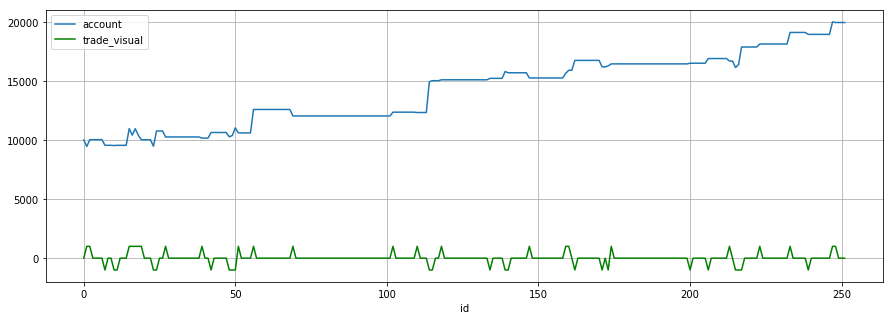

In [118]:
gold_account = get_performance(gold_clf, gold_reg_pca, gold_gains.loc[gold_gains.index > validate_date], gold_reg_validate, gold_reg_label_validate, stop_loss_long=1000, stop_loss_short=800, regression=True, target=400)
# ax1 = gold_account[['account']].plot(grid=True)
# ax1.set_ylim(0,gold_account.account.max()+500)

In [119]:
y_pred = gold_clf.predict(X_test)

In [120]:
df = pd.DataFrame([])
df['y_true'] = y_test
df['y_pred'] = y_pred
df.corr()

,y_true,y_pred
y_true,1.000000,0.001812
y_pred,0.001812,1.000000


In [121]:
X_val = pca_transform(gold_reg_validate, gold_reg_pca)

In [122]:
y_pred_val = gold_clf.predict(X_val)
y_true_val = gold_reg_label_validate

In [123]:
df = pd.DataFrame([])
df['y_true'] = y_true_val
df['y_pred'] = y_pred_val
df.corr()

,y_true,y_pred
y_true,1.000000,0.163876
y_pred,0.163876,1.000000


In [124]:
df[df.y_pred.abs() > 400].corr()

,y_true,y_pred
y_true,1.000000,0.368542
y_pred,0.368542,1.000000


In [125]:
(gold_account.account.values[-1]/gold_account.account.values[0])*100-100

99.40999999999977

In [126]:
# source https://github.com/manifoldai/mf-eng-public/blob/master/notebooks/custom_loss_lightgbm.ipynb
### Plotting helper functions

def plot_residual_distribution(model):
    """
    Density plot of residuals (y_true - y_pred) for testation set for given model 
    """
    ax = sns.distplot(df[df.y_pred.abs() > 400].y_true - df[df.y_pred.abs() > 400].y_pred, hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3}, axlabel="Residual")
    title = ax.set_title('Kernel density of residuals', size=15)

def plot_scatter_pred_actual(model):
    """
    Scatter plot of predictions from given model vs true target variable from testation set
    """
    ax = sns.scatterplot(x=df[df.y_pred.abs() > 400].y_pred, y=df[df.y_pred.abs() > 400].y_true)
    ax.set_xlabel('Predictions')
    ax.set_ylabel('Actuals')
    title = ax.set_title('Actual vs Prediction scatter plot', size=15)

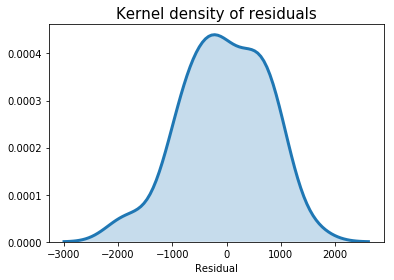

In [127]:
plot_residual_distribution(gold_clf)

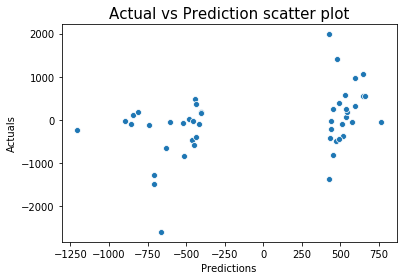

In [128]:
plot_scatter_pred_actual(gold_clf)

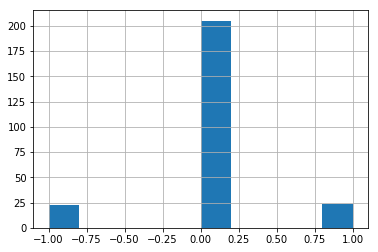

In [137]:
gold_account.trade.hist()

Average earnings per trade

In [147]:
def earnings_per_trade(df):
    return (df[df.trade != 0].gains.sum())/(df[df.trade != 0].trade.count())

earnings_per_trade(gold_account)

211.51063829787176

Average earnings per short trade

In [148]:
def earnings_per_shorts(df):
    return (df[df.trade == -1].gains.sum())/(df[df.trade == -1].trade.count())

earnings_per_shorts(gold_account)

272.26086956521885

Average earnings per long trade

In [149]:
def earning_per_longs(df):
    return (df[df.trade == 1].gains.sum())/(df[df.trade == 1].trade.count())

earning_per_longs(gold_account)

153.2916666666641

In [144]:
X = pca_transform(corn_reg_train, corn_reg_pca)
y = corn_reg_label_train
train_data = lgb.Dataset(X, label=y)
X_test = pca_transform(corn_reg_test, corn_reg_pca)
y_test = corn_reg_label_test
test_data = lgb.Dataset(X_test, label=y_test)

corn_clf = lgb.train(param, train_data, num_round, valid_sets=[test_data])

[1]	valid_0's l2: 176266
[2]	valid_0's l2: 176115
[3]	valid_0's l2: 175486
[4]	valid_0's l2: 175373
[5]	valid_0's l2: 175581
[6]	valid_0's l2: 175235
[7]	valid_0's l2: 175519
[8]	valid_0's l2: 175660
[9]	valid_0's l2: 175655
[10]	valid_0's l2: 176447
[11]	valid_0's l2: 177437
[12]	valid_0's l2: 176994
[13]	valid_0's l2: 177359
[14]	valid_0's l2: 176859
[15]	valid_0's l2: 177267
[16]	valid_0's l2: 177445
[17]	valid_0's l2: 177434
[18]	valid_0's l2: 177193
[19]	valid_0's l2: 177418
[20]	valid_0's l2: 177814
[21]	valid_0's l2: 177591
[22]	valid_0's l2: 177480
[23]	valid_0's l2: 177577
[24]	valid_0's l2: 177233
[25]	valid_0's l2: 177798
[26]	valid_0's l2: 178034
[27]	valid_0's l2: 178191
[28]	valid_0's l2: 177856
[29]	valid_0's l2: 177829
[30]	valid_0's l2: 178031
[31]	valid_0's l2: 178230
[32]	valid_0's l2: 178826
[33]	valid_0's l2: 178856
[34]	valid_0's l2: 178749
[35]	valid_0's l2: 178461
[36]	valid_0's l2: 178367
[37]	valid_0's l2: 178438
[38]	valid_0's l2: 179046
[39]	valid_0's l2: 17

[364]	valid_0's l2: 187396
[365]	valid_0's l2: 187423
[366]	valid_0's l2: 187333
[367]	valid_0's l2: 187252
[368]	valid_0's l2: 187280
[369]	valid_0's l2: 187191
[370]	valid_0's l2: 187372
[371]	valid_0's l2: 187308
[372]	valid_0's l2: 187283
[373]	valid_0's l2: 187381
[374]	valid_0's l2: 187580
[375]	valid_0's l2: 187635
[376]	valid_0's l2: 187538
[377]	valid_0's l2: 187835
[378]	valid_0's l2: 187730
[379]	valid_0's l2: 187658
[380]	valid_0's l2: 187698
[381]	valid_0's l2: 187619
[382]	valid_0's l2: 187563
[383]	valid_0's l2: 187617
[384]	valid_0's l2: 187785
[385]	valid_0's l2: 187707
[386]	valid_0's l2: 187603
[387]	valid_0's l2: 187741
[388]	valid_0's l2: 187714
[389]	valid_0's l2: 187726
[390]	valid_0's l2: 187803
[391]	valid_0's l2: 187740
[392]	valid_0's l2: 187775
[393]	valid_0's l2: 187649
[394]	valid_0's l2: 187721
[395]	valid_0's l2: 187590
[396]	valid_0's l2: 187508
[397]	valid_0's l2: 187639
[398]	valid_0's l2: 187856
[399]	valid_0's l2: 187887
[400]	valid_0's l2: 187929
[

[694]	valid_0's l2: 186339
[695]	valid_0's l2: 186288
[696]	valid_0's l2: 186363
[697]	valid_0's l2: 186459
[698]	valid_0's l2: 186369
[699]	valid_0's l2: 186326
[700]	valid_0's l2: 186291
[701]	valid_0's l2: 186326
[702]	valid_0's l2: 186314
[703]	valid_0's l2: 186267
[704]	valid_0's l2: 186240
[705]	valid_0's l2: 186212
[706]	valid_0's l2: 186190
[707]	valid_0's l2: 186145
[708]	valid_0's l2: 186362
[709]	valid_0's l2: 186550
[710]	valid_0's l2: 186571
[711]	valid_0's l2: 186529
[712]	valid_0's l2: 186480
[713]	valid_0's l2: 186528
[714]	valid_0's l2: 186483
[715]	valid_0's l2: 186465
[716]	valid_0's l2: 186517
[717]	valid_0's l2: 186479
[718]	valid_0's l2: 186445
[719]	valid_0's l2: 186407
[720]	valid_0's l2: 186390
[721]	valid_0's l2: 186564
[722]	valid_0's l2: 186536
[723]	valid_0's l2: 186578
[724]	valid_0's l2: 186674
[725]	valid_0's l2: 186637
[726]	valid_0's l2: 186646
[727]	valid_0's l2: 186662
[728]	valid_0's l2: 186790
[729]	valid_0's l2: 186754
[730]	valid_0's l2: 186862
[

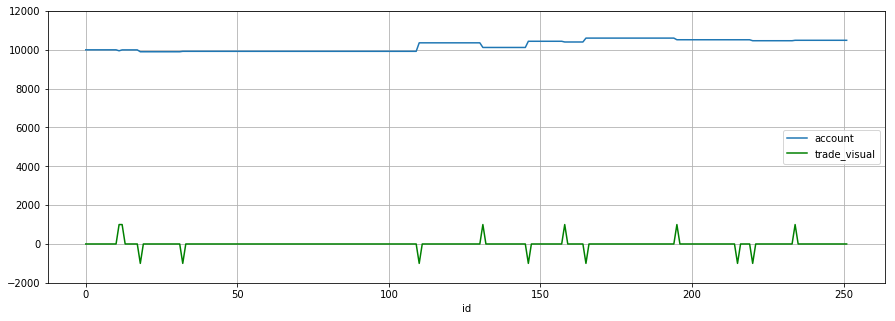

In [145]:
corn_account = get_performance(corn_clf, corn_reg_pca, corn_gains.loc[corn_gains.index > validate_date], corn_reg_validate, corn_reg_label_validate, stop_loss_long=300, stop_loss_short=300, regression=True, target=150)

In [146]:
(corn_account.account.values[-1]/corn_account.account.values[0])*100-100

4.9112499999999955

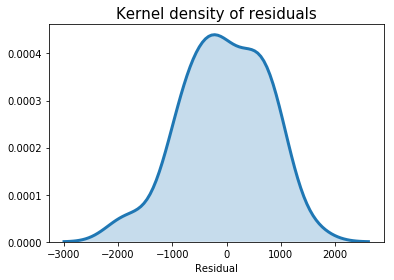

In [132]:
plot_residual_distribution(corn_clf)

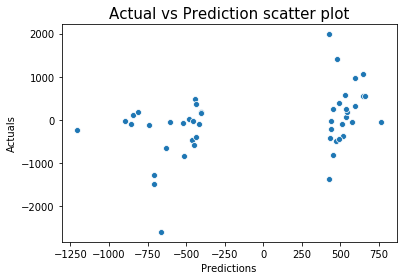

In [133]:
plot_scatter_pred_actual(corn_clf)

In [150]:
earnings_per_trade(corn_account)

37.77884615384615

In [151]:
earnings_per_shorts(corn_account)

118.94642857142857

In [152]:
earning_per_longs(corn_account)

-56.916666666666664

In [134]:
X = pca_transform(coffee_reg_train, coffee_reg_pca)
y = coffee_reg_label_train.values
train_data = lgb.Dataset(X, label=y)
X_test = pca_transform(coffee_reg_test, coffee_reg_pca)
y_test = coffee_reg_label_test.values
test_data = lgb.Dataset(X_test, label=y_test)

coffee_clf = lgb.train(param, train_data, num_round, valid_sets=[test_data])

[1]	valid_0's l2: 172467
[2]	valid_0's l2: 172467
[3]	valid_0's l2: 172467
[4]	valid_0's l2: 172467
[5]	valid_0's l2: 172467
[6]	valid_0's l2: 172467
[7]	valid_0's l2: 172467
[8]	valid_0's l2: 172467
[9]	valid_0's l2: 172467
[10]	valid_0's l2: 172467
[11]	valid_0's l2: 172467
[12]	valid_0's l2: 172467
[13]	valid_0's l2: 172467
[14]	valid_0's l2: 172467
[15]	valid_0's l2: 172467
[16]	valid_0's l2: 172467
[17]	valid_0's l2: 172467
[18]	valid_0's l2: 172467
[19]	valid_0's l2: 172467
[20]	valid_0's l2: 172467
[21]	valid_0's l2: 172467
[22]	valid_0's l2: 172467
[23]	valid_0's l2: 172467
[24]	valid_0's l2: 172467
[25]	valid_0's l2: 172467
[26]	valid_0's l2: 172467
[27]	valid_0's l2: 172467
[28]	valid_0's l2: 172467
[29]	valid_0's l2: 172467
[30]	valid_0's l2: 172467
[31]	valid_0's l2: 172467
[32]	valid_0's l2: 172467
[33]	valid_0's l2: 172467
[34]	valid_0's l2: 172467
[35]	valid_0's l2: 172467
[36]	valid_0's l2: 172467
[37]	valid_0's l2: 172467
[38]	valid_0's l2: 172467
[39]	valid_0's l2: 17

[315]	valid_0's l2: 172467
[316]	valid_0's l2: 172467
[317]	valid_0's l2: 172467
[318]	valid_0's l2: 172467
[319]	valid_0's l2: 172467
[320]	valid_0's l2: 172467
[321]	valid_0's l2: 172467
[322]	valid_0's l2: 172467
[323]	valid_0's l2: 172467
[324]	valid_0's l2: 172467
[325]	valid_0's l2: 172467
[326]	valid_0's l2: 172467
[327]	valid_0's l2: 172467
[328]	valid_0's l2: 172467
[329]	valid_0's l2: 172467
[330]	valid_0's l2: 172467
[331]	valid_0's l2: 172467
[332]	valid_0's l2: 172467
[333]	valid_0's l2: 172467
[334]	valid_0's l2: 172467
[335]	valid_0's l2: 172467
[336]	valid_0's l2: 172467
[337]	valid_0's l2: 172467
[338]	valid_0's l2: 172467
[339]	valid_0's l2: 172467
[340]	valid_0's l2: 172467
[341]	valid_0's l2: 172467
[342]	valid_0's l2: 172467
[343]	valid_0's l2: 172467
[344]	valid_0's l2: 172467
[345]	valid_0's l2: 172467
[346]	valid_0's l2: 172467
[347]	valid_0's l2: 172467
[348]	valid_0's l2: 172467
[349]	valid_0's l2: 172467
[350]	valid_0's l2: 172467
[351]	valid_0's l2: 172467
[

[688]	valid_0's l2: 172467
[689]	valid_0's l2: 172467
[690]	valid_0's l2: 172467
[691]	valid_0's l2: 172467
[692]	valid_0's l2: 172467
[693]	valid_0's l2: 172467
[694]	valid_0's l2: 172467
[695]	valid_0's l2: 172467
[696]	valid_0's l2: 172467
[697]	valid_0's l2: 172467
[698]	valid_0's l2: 172467
[699]	valid_0's l2: 172467
[700]	valid_0's l2: 172467
[701]	valid_0's l2: 172467
[702]	valid_0's l2: 172467
[703]	valid_0's l2: 172467
[704]	valid_0's l2: 172467
[705]	valid_0's l2: 172467
[706]	valid_0's l2: 172467
[707]	valid_0's l2: 172467
[708]	valid_0's l2: 172467
[709]	valid_0's l2: 172467
[710]	valid_0's l2: 172467
[711]	valid_0's l2: 172467
[712]	valid_0's l2: 172467
[713]	valid_0's l2: 172467
[714]	valid_0's l2: 172467
[715]	valid_0's l2: 172467
[716]	valid_0's l2: 172467
[717]	valid_0's l2: 172467
[718]	valid_0's l2: 172467
[719]	valid_0's l2: 172467
[720]	valid_0's l2: 172467
[721]	valid_0's l2: 172467
[722]	valid_0's l2: 172467
[723]	valid_0's l2: 172467
[724]	valid_0's l2: 172467
[

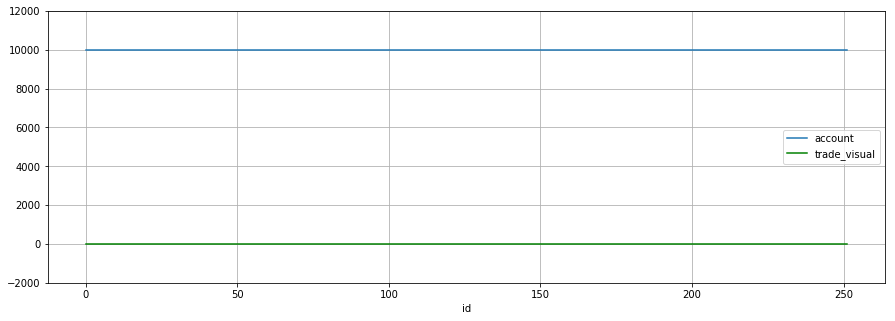

In [135]:
coffee_account = get_performance(coffee_clf, coffee_reg_pca, coffee_gains.loc[coffee_gains.index > validate_date], coffee_reg_validate, coffee_reg_label_validate, stop_loss_long=1000, stop_loss_short=1000, regression=True, target=20)

# Neural Networks classifier

- gold 187% gains (only shorts were triggered)
- corn 

In [157]:
def create_target(x):
    if x == 1.0:
        return [0,0,1]
    elif x == 0.0:
        return [1,0,0]
    else:
        return [0,1,0]

In [158]:
X = pca_transform(gold_train, gold_pca)
y = gold_label_train
# remove outliers
X, y = remove_outliers(X, y, out_gold)

X_test = pca_transform(gold_test, gold_pca)
y_test = gold_label_test
X_test, y_test = remove_outliers(X_test, y_test, out_gold)
y = np.array(list(map(create_target, y)))
y_test = np.array(list(map(create_target, y_test)))

In [165]:
# %%capture training_gold
from keras.layers import Dropout, Flatten, Dense, Activation, LeakyReLU
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Nadam
from keras.models import Sequential
from keras.metrics import categorical_accuracy, binary_accuracy, sparse_categorical_accuracy
from keras import regularizers
from keras.wrappers.scikit_learn import KerasRegressor

input_shape = 200
num_classes = 3

def define_model(input_shape, num_classes):
    # Define a model
    model = Sequential()  
    model.add(Dense(32, input_dim=input_shape, activity_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.4))
    model.add(Dense(16, activity_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.3))
    model.add(Dense(8, activity_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.2))
    model.add(Dense(num_classes))
    model.add(Activation('tanh'))

    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# opt = SGD(lr=0.1, momentum=0.9, decay=0.0, nesterov=False)
# opt = Nadam(lr=0.002)
model = define_model(input_shape, num_classes)

In [166]:
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(filepath='saved_models/weights.gold.hdf5',
                               monitor='val_loss',
                               verbose=1,
                               save_best_only=True,
                               save_weights_only=True)

In [167]:
# model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X, y, validation_data=(X_test, y_test), batch_size=20, epochs=20, callbacks=[checkpointer])

model.summary()

Train on 1930 samples, validate on 484 samples
Epoch 1/20
1930/1930 [==============================] - 1s 550us/step - loss: 48768524738.9845 - acc: 0.3311 - val_loss: 27388628843.9008 - val_acc: 0.3202

Epoch 00001: val_loss improved from inf to 27388628843.90083, saving model to saved_models/weights.gold.hdf5
Epoch 2/20
1930/1930 [==============================] - 0s 199us/step - loss: 17814424098.4870 - acc: 0.3358 - val_loss: 9171800317.8843 - val_acc: 0.3120

Epoch 00002: val_loss improved from 27388628843.90083 to 9171800317.88430, saving model to saved_models/weights.gold.hdf5
Epoch 3/20
1930/1930 [==============================] - 0s 197us/step - loss: 5507175739.6891 - acc: 0.3554 - val_loss: 2064220317.6198 - val_acc: 0.2707

Epoch 00003: val_loss improved from 9171800317.88430 to 2064220317.61983, saving model to saved_models/weights.gold.hdf5
Epoch 4/20
1930/1930 [==============================] - 0s 204us/step - loss: 896542144.6425 - acc: 0.3466 - val_loss: 83176365.0744 

In [168]:
model.load_weights('saved_models/weights.gold.hdf5')
gold_clf_nn = model

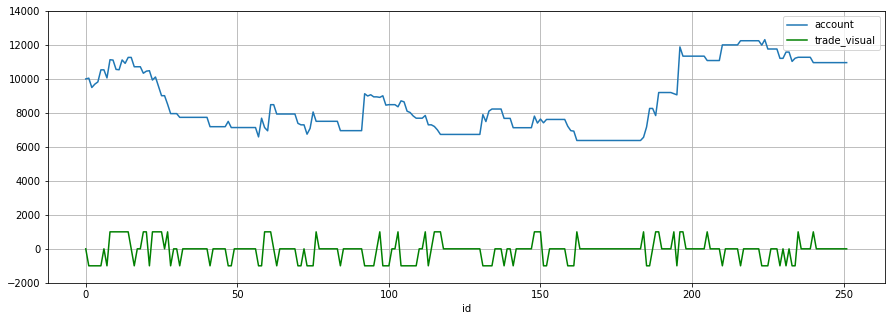

In [169]:
gold_account_nn = get_performance(gold_clf_nn, gold_pca, gold_gains.loc[gold_gains.index > validate_date], gold_validate, gold_label_validate, stop_loss_long=1000, stop_loss_short=800)

In [170]:
gold_account_nn[gold_account_nn['short'] == 1].gains.sum()

-473.4999999999875

In [171]:
gold_account_nn[gold_account_nn['long'] == 1].gains.sum()

1434.5000000000125

In [172]:
(gold_account_nn.account.values[-1]/gold_account_nn.account.values[0])*100-100

9.610000000000298

In [174]:
X = pca_transform(corn_train, corn_pca)
y = corn_label_train
# remove outliers
X, y = remove_outliers(X, y, out_corn)

X_test = pca_transform(corn_test, corn_pca)
y_test = corn_label_test
X_test, y_test = remove_outliers(X_test, y_test, out_corn)
y = np.array(list(map(create_target, y)))
y_test = np.array(list(map(create_target, y_test)))

model = define_model(input_shape, num_classes)

checkpointer = ModelCheckpoint(filepath='saved_models/weights.corn.hdf5',
                               monitor='val_loss',
                               verbose=1,
                               save_best_only=True,
                               save_weights_only=True)

model.fit(X, y, validation_data=(X_test, y_test), batch_size=20, epochs=20, callbacks=[checkpointer])

model.summary()
model.load_weights('saved_models/weights.corn.hdf5')
corn_clf_nn = model

Train on 1930 samples, validate on 483 samples
Epoch 1/20
1930/1930 [==============================] - 1s 657us/step - loss: 42753119332.8083 - acc: 0.3098 - val_loss: 23238677937.5569 - val_acc: 0.3106

Epoch 00001: val_loss improved from inf to 23238677937.55693, saving model to saved_models/weights.corn.hdf5
Epoch 2/20
1930/1930 [==============================] - 0s 200us/step - loss: 15059157228.1036 - acc: 0.3223 - val_loss: 7908938887.9503 - val_acc: 0.3188

Epoch 00002: val_loss improved from 23238677937.55693 to 7908938887.95031, saving model to saved_models/weights.corn.hdf5
Epoch 3/20
1930/1930 [==============================] - 0s 202us/step - loss: 4905320032.1658 - acc: 0.3181 - val_loss: 2009028233.0766 - val_acc: 0.3043

Epoch 00003: val_loss improved from 7908938887.95031 to 2009028233.07660, saving model to saved_models/weights.corn.hdf5
Epoch 4/20
1930/1930 [==============================] - 0s 200us/step - loss: 955000592.2487 - acc: 0.3192 - val_loss: 133740886.6522

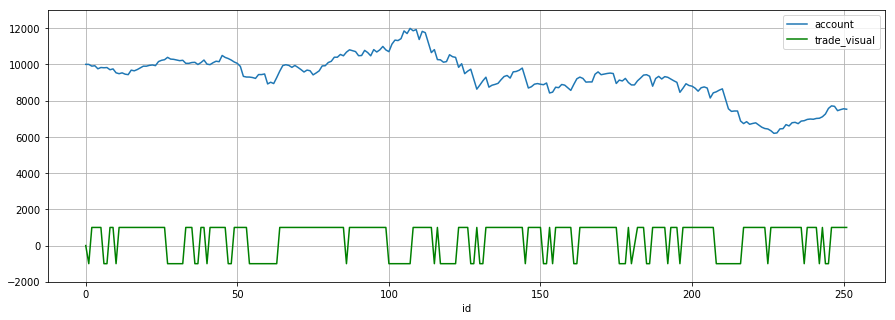

In [175]:
corn_account_nn = get_performance(corn_clf_nn, corn_pca, corn_gains.loc[corn_gains.index > validate_date], corn_validate, corn_label_validate, stop_loss_long=300, stop_loss_short=300)

In [176]:
(corn_account_nn.account.values[-1]/corn_account_nn.account.values[0])*100-100

-24.76625

In [330]:
import keras
import tensorflow as tf
# from sklearn.metrics import mean_squared_error
from tensorflow.losses import mean_squared_error


def huber_loss(y_true, y_pred):
    return tf.losses.huber_loss(y_true,y_pred)


def weighted_mean_squared_error(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, weights=0.75)


# loss = huber_loss
loss = weighted_mean_squared_error
optimizer = 'Adam'

def regressor_model():
    global input_shape
    global loss
    global optimizer
    # Define a model
    #     model = Sequential()  
    #     model.add(Dense(32, input_dim=input_shape, activity_regularizer=regularizers.l2(0.01)))
    #     model.add(BatchNormalization())
    #     model.add(LeakyReLU())
    #     model.add(Dropout(0.4))
    #     model.add(Dense(16, activity_regularizer=regularizers.l2(0.01)))
    #     model.add(BatchNormalization())
    #     model.add(LeakyReLU())
    #     model.add(Dropout(0.3))
    #     model.add(Dense(8, activity_regularizer=regularizers.l2(0.01)))
    #     model.add(BatchNormalization())
    #     model.add(LeakyReLU())
    #     model.add(Dropout(0.2))
    #     # model.add(Dense(1))
    #     # model.add(Activation('tanh'))
    #     model.add(Dense(1, kernel_initializer='normal'))
    
    alpha=.0001
    model = Sequential()
    model.add(Dense(500, input_dim=input_shape, kernel_initializer='normal', activation='relu',))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.4))
    model.add(Dense(250, kernel_initializer='normal',activation='relu',))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.4))
    model.add(Dense(128, kernel_initializer='normal',activation='relu',))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.4))
    model.add(Dense(64, kernel_initializer='normal',activation='relu',))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.4))
    model.add(Dense(32, kernel_initializer='normal',activation='relu',))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.4))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss=loss, optimizer=optimizer)
    return model

    # model.compile(optimizer=opt, loss='mean_squared_error', metrics=['accuracy'])
    # model.compile(loss='l1', optimizer='sgd', metrics=['mse'])
    # return model

In [331]:
X = pca_transform(gold_reg_train, gold_reg_pca)
y = gold_reg_label_train
# remove outliers
X, y = remove_outliers(X, y, out_gold)

X_test = pca_transform(gold_reg_test, gold_reg_pca)
y_test = gold_reg_label_test
X_test, y_test = remove_outliers(X_test, y_test, out_gold)

epochs = 10000
batch_size = 50

checkpointer = ModelCheckpoint(filepath='saved_models/weights.gold_reg.hdf5',
                               monitor='val_loss',
                               verbose=1,
                               save_best_only=True,
                               save_weights_only=True)

estimator = KerasRegressor(build_fn=regressor_model, epochs=epochs, batch_size=batch_size)

In [332]:
estimator.fit(X, y, validation_data=(X_test, y_test), batch_size=batch_size, epochs=epochs, callbacks=[checkpointer])

Train on 1930 samples, validate on 484 samples
Epoch 1/10000
1930/1930 [==============================] - 6s 3ms/step - loss: 1278231.0207 - val_loss: 1215207.3048

Epoch 00001: val_loss improved from inf to 1215207.30475, saving model to saved_models/weights.gold_reg.hdf5
Epoch 2/10000
1930/1930 [==============================] - 0s 161us/step - loss: 1278209.7024 - val_loss: 1215208.5927

Epoch 00002: val_loss did not improve from 1215207.30475
Epoch 3/10000
1930/1930 [==============================] - 0s 160us/step - loss: 1278140.3711 - val_loss: 1215194.6271

Epoch 00003: val_loss improved from 1215207.30475 to 1215194.62707, saving model to saved_models/weights.gold_reg.hdf5
Epoch 4/10000
1930/1930 [==============================] - 0s 165us/step - loss: 1278001.8442 - val_loss: 1215081.2807

Epoch 00004: val_loss improved from 1215194.62707 to 1215081.28073, saving model to saved_models/weights.gold_reg.hdf5
Epoch 5/10000
1930/1930 [==============================] - 0s 163us/ste

1930/1930 [==============================] - 0s 186us/step - loss: 1029171.3638 - val_loss: 1224169.4618

Epoch 00043: val_loss did not improve from 1211779.38817
Epoch 44/10000
1930/1930 [==============================] - 0s 183us/step - loss: 1026125.3807 - val_loss: 1223098.1686

Epoch 00044: val_loss did not improve from 1211779.38817
Epoch 45/10000
1930/1930 [==============================] - 0s 200us/step - loss: 1006291.1438 - val_loss: 1226058.1237

Epoch 00045: val_loss did not improve from 1211779.38817
Epoch 46/10000
1930/1930 [==============================] - 0s 198us/step - loss: 997114.8653 - val_loss: 1227973.1733

Epoch 00046: val_loss did not improve from 1211779.38817
Epoch 47/10000
1930/1930 [==============================] - 0s 199us/step - loss: 994416.6279 - val_loss: 1225408.3221

Epoch 00047: val_loss did not improve from 1211779.38817
Epoch 48/10000
1930/1930 [==============================] - 0s 197us/step - loss: 984966.7252 - val_loss: 1233795.1733

Epoch 0

1930/1930 [==============================] - 0s 163us/step - loss: 623686.3979 - val_loss: 1377449.4992

Epoch 00089: val_loss did not improve from 1211779.38817
Epoch 90/10000
1930/1930 [==============================] - 0s 161us/step - loss: 614852.9615 - val_loss: 1377681.2926

Epoch 00090: val_loss did not improve from 1211779.38817
Epoch 91/10000
1930/1930 [==============================] - 0s 162us/step - loss: 609939.6518 - val_loss: 1373469.9383

Epoch 00091: val_loss did not improve from 1211779.38817
Epoch 92/10000
1930/1930 [==============================] - 0s 161us/step - loss: 600015.7310 - val_loss: 1384056.7924

Epoch 00092: val_loss did not improve from 1211779.38817
Epoch 93/10000
1930/1930 [==============================] - 0s 161us/step - loss: 579738.2448 - val_loss: 1397879.8342

Epoch 00093: val_loss did not improve from 1211779.38817
Epoch 94/10000
1930/1930 [==============================] - 0s 170us/step - loss: 580349.2808 - val_loss: 1405422.6506

Epoch 0009

1930/1930 [==============================] - 0s 187us/step - loss: 364029.2537 - val_loss: 1678626.6552

Epoch 00135: val_loss did not improve from 1211779.38817
Epoch 136/10000
1930/1930 [==============================] - 0s 187us/step - loss: 367723.2151 - val_loss: 1685917.9029

Epoch 00136: val_loss did not improve from 1211779.38817
Epoch 137/10000
1930/1930 [==============================] - 0s 189us/step - loss: 331904.5238 - val_loss: 1628843.8949

Epoch 00137: val_loss did not improve from 1211779.38817
Epoch 138/10000
1930/1930 [==============================] - 0s 189us/step - loss: 358377.3314 - val_loss: 1619383.4835

Epoch 00138: val_loss did not improve from 1211779.38817
Epoch 139/10000
1930/1930 [==============================] - 0s 188us/step - loss: 354149.9314 - val_loss: 1666369.1526

Epoch 00139: val_loss did not improve from 1211779.38817
Epoch 140/10000
1930/1930 [==============================] - 0s 187us/step - loss: 330948.8652 - val_loss: 1647892.5514

Epoch

1930/1930 [==============================] - 0s 161us/step - loss: 260061.9705 - val_loss: 1817395.9979

Epoch 00181: val_loss did not improve from 1211779.38817
Epoch 182/10000
1930/1930 [==============================] - 0s 163us/step - loss: 258382.5176 - val_loss: 1871590.4228

Epoch 00182: val_loss did not improve from 1211779.38817
Epoch 183/10000
1930/1930 [==============================] - 0s 177us/step - loss: 286988.4804 - val_loss: 1816189.2438

Epoch 00183: val_loss did not improve from 1211779.38817
Epoch 184/10000
1930/1930 [==============================] - 0s 175us/step - loss: 248611.9798 - val_loss: 1915740.3463

Epoch 00184: val_loss did not improve from 1211779.38817
Epoch 185/10000
1930/1930 [==============================] - 0s 178us/step - loss: 273453.0809 - val_loss: 1891869.0336

Epoch 00185: val_loss did not improve from 1211779.38817
Epoch 186/10000
1930/1930 [==============================] - 0s 183us/step - loss: 230634.8833 - val_loss: 1892547.3959

Epoch

1930/1930 [==============================] - 0s 165us/step - loss: 210885.0723 - val_loss: 2029231.5369

Epoch 00227: val_loss did not improve from 1211779.38817
Epoch 228/10000
1930/1930 [==============================] - 0s 166us/step - loss: 216283.3824 - val_loss: 2145366.7743

Epoch 00228: val_loss did not improve from 1211779.38817
Epoch 229/10000
1930/1930 [==============================] - 0s 164us/step - loss: 224485.8867 - val_loss: 1982029.1774

Epoch 00229: val_loss did not improve from 1211779.38817
Epoch 230/10000
1930/1930 [==============================] - 0s 169us/step - loss: 207940.1070 - val_loss: 2106821.9269

Epoch 00230: val_loss did not improve from 1211779.38817
Epoch 231/10000
1930/1930 [==============================] - 0s 172us/step - loss: 231444.3238 - val_loss: 1985130.4344

Epoch 00231: val_loss did not improve from 1211779.38817
Epoch 232/10000
1930/1930 [==============================] - 0s 168us/step - loss: 226567.2706 - val_loss: 1969387.7497

Epoch

1930/1930 [==============================] - 0s 173us/step - loss: 201842.7629 - val_loss: 2017242.9393

Epoch 00273: val_loss did not improve from 1211779.38817
Epoch 274/10000
1930/1930 [==============================] - 0s 171us/step - loss: 213927.8910 - val_loss: 2100601.1867

Epoch 00274: val_loss did not improve from 1211779.38817
Epoch 275/10000
1930/1930 [==============================] - 0s 168us/step - loss: 203884.1823 - val_loss: 2094691.6945

Epoch 00275: val_loss did not improve from 1211779.38817
Epoch 276/10000
1930/1930 [==============================] - 0s 168us/step - loss: 207548.4178 - val_loss: 2163498.8450

Epoch 00276: val_loss did not improve from 1211779.38817
Epoch 277/10000
1930/1930 [==============================] - 0s 187us/step - loss: 196943.4925 - val_loss: 2112832.3184

Epoch 00277: val_loss did not improve from 1211779.38817
Epoch 278/10000
1930/1930 [==============================] - 0s 187us/step - loss: 226743.6759 - val_loss: 2153562.8262

Epoch

1930/1930 [==============================] - 0s 242us/step - loss: 214589.4094 - val_loss: 2235133.0085

Epoch 00319: val_loss did not improve from 1211779.38817
Epoch 320/10000
1930/1930 [==============================] - 0s 240us/step - loss: 198421.6223 - val_loss: 2222993.1036

Epoch 00320: val_loss did not improve from 1211779.38817
Epoch 321/10000
1930/1930 [==============================] - 0s 241us/step - loss: 210512.6223 - val_loss: 2333074.1761

Epoch 00321: val_loss did not improve from 1211779.38817
Epoch 322/10000
1930/1930 [==============================] - 0s 242us/step - loss: 181888.1417 - val_loss: 2231681.0940

Epoch 00322: val_loss did not improve from 1211779.38817
Epoch 323/10000
1930/1930 [==============================] - 0s 244us/step - loss: 202967.4922 - val_loss: 2232720.5191

Epoch 00323: val_loss did not improve from 1211779.38817
Epoch 324/10000
1930/1930 [==============================] - 0s 241us/step - loss: 190634.6904 - val_loss: 2264266.0057

Epoch

1930/1930 [==============================] - 0s 173us/step - loss: 192484.7146 - val_loss: 2189061.5194

Epoch 00365: val_loss did not improve from 1211779.38817
Epoch 366/10000
1930/1930 [==============================] - 0s 175us/step - loss: 193072.9143 - val_loss: 2214222.9352

Epoch 00366: val_loss did not improve from 1211779.38817
Epoch 367/10000
1930/1930 [==============================] - 0s 173us/step - loss: 204365.3361 - val_loss: 2142565.7508

Epoch 00367: val_loss did not improve from 1211779.38817
Epoch 368/10000
1930/1930 [==============================] - 0s 167us/step - loss: 203676.7656 - val_loss: 2289521.5770

Epoch 00368: val_loss did not improve from 1211779.38817
Epoch 369/10000
1930/1930 [==============================] - 0s 166us/step - loss: 204656.7496 - val_loss: 2255215.1627

Epoch 00369: val_loss did not improve from 1211779.38817
Epoch 370/10000
1930/1930 [==============================] - 0s 167us/step - loss: 210965.1552 - val_loss: 2200098.5359

Epoch

1930/1930 [==============================] - 0s 161us/step - loss: 204534.0998 - val_loss: 2102262.2593

Epoch 00411: val_loss did not improve from 1211779.38817
Epoch 412/10000
1930/1930 [==============================] - 0s 160us/step - loss: 181068.3344 - val_loss: 2232693.4778

Epoch 00412: val_loss did not improve from 1211779.38817
Epoch 413/10000
1930/1930 [==============================] - 0s 158us/step - loss: 170275.7399 - val_loss: 2125600.0251

Epoch 00413: val_loss did not improve from 1211779.38817
Epoch 414/10000
1930/1930 [==============================] - 0s 158us/step - loss: 182675.0483 - val_loss: 2095906.6534

Epoch 00414: val_loss did not improve from 1211779.38817
Epoch 415/10000
1930/1930 [==============================] - 0s 161us/step - loss: 180597.1716 - val_loss: 2146702.1423

Epoch 00415: val_loss did not improve from 1211779.38817
Epoch 416/10000
1930/1930 [==============================] - 0s 160us/step - loss: 188175.0398 - val_loss: 2196366.8900

Epoch

1930/1930 [==============================] - 0s 178us/step - loss: 184227.2105 - val_loss: 2218521.3861

Epoch 00457: val_loss did not improve from 1211779.38817
Epoch 458/10000
1930/1930 [==============================] - 0s 233us/step - loss: 178309.2853 - val_loss: 2253107.2100

Epoch 00458: val_loss did not improve from 1211779.38817
Epoch 459/10000
1930/1930 [==============================] - 0s 237us/step - loss: 177235.3266 - val_loss: 2397527.6847

Epoch 00459: val_loss did not improve from 1211779.38817
Epoch 460/10000
1930/1930 [==============================] - 0s 180us/step - loss: 194315.2427 - val_loss: 2203202.5687

Epoch 00460: val_loss did not improve from 1211779.38817
Epoch 461/10000
1930/1930 [==============================] - 0s 160us/step - loss: 179966.6909 - val_loss: 2387445.8608

Epoch 00461: val_loss did not improve from 1211779.38817
Epoch 462/10000
1930/1930 [==============================] - 0s 159us/step - loss: 186061.0310 - val_loss: 2175039.6092

Epoch

1930/1930 [==============================] - 1s 295us/step - loss: 173049.4636 - val_loss: 2243343.0891

Epoch 00503: val_loss did not improve from 1211779.38817
Epoch 504/10000
1930/1930 [==============================] - 1s 302us/step - loss: 181228.8472 - val_loss: 2206035.7676

Epoch 00504: val_loss did not improve from 1211779.38817
Epoch 505/10000
1930/1930 [==============================] - 1s 301us/step - loss: 191078.4875 - val_loss: 2159919.2195

Epoch 00505: val_loss did not improve from 1211779.38817
Epoch 506/10000
1930/1930 [==============================] - 1s 292us/step - loss: 174222.0767 - val_loss: 2268560.7931

Epoch 00506: val_loss did not improve from 1211779.38817
Epoch 507/10000
1930/1930 [==============================] - 0s 186us/step - loss: 208879.6272 - val_loss: 2331304.5860

Epoch 00507: val_loss did not improve from 1211779.38817
Epoch 508/10000
1930/1930 [==============================] - 0s 189us/step - loss: 195083.3005 - val_loss: 2214502.8058

Epoch

1930/1930 [==============================] - 0s 172us/step - loss: 186392.0793 - val_loss: 2429031.6676

Epoch 00549: val_loss did not improve from 1211779.38817
Epoch 550/10000
1930/1930 [==============================] - 0s 171us/step - loss: 175014.9630 - val_loss: 2421978.8290

Epoch 00550: val_loss did not improve from 1211779.38817
Epoch 551/10000
1930/1930 [==============================] - 0s 172us/step - loss: 166821.1127 - val_loss: 2327191.1834

Epoch 00551: val_loss did not improve from 1211779.38817
Epoch 552/10000
1930/1930 [==============================] - 0s 174us/step - loss: 161563.9662 - val_loss: 2297250.0333

Epoch 00552: val_loss did not improve from 1211779.38817
Epoch 553/10000
1930/1930 [==============================] - 0s 153us/step - loss: 184594.0254 - val_loss: 2293837.3732

Epoch 00553: val_loss did not improve from 1211779.38817
Epoch 554/10000
1930/1930 [==============================] - 0s 168us/step - loss: 188068.3744 - val_loss: 2343914.9708

Epoch

1930/1930 [==============================] - 0s 240us/step - loss: 162849.2606 - val_loss: 2351419.6849

Epoch 00595: val_loss did not improve from 1211779.38817
Epoch 596/10000
1930/1930 [==============================] - 0s 246us/step - loss: 161600.0853 - val_loss: 2525318.0129

Epoch 00596: val_loss did not improve from 1211779.38817
Epoch 597/10000
1930/1930 [==============================] - 0s 242us/step - loss: 173630.7895 - val_loss: 2478398.8982

Epoch 00597: val_loss did not improve from 1211779.38817
Epoch 598/10000
1930/1930 [==============================] - 0s 244us/step - loss: 162882.4962 - val_loss: 2336044.4959

Epoch 00598: val_loss did not improve from 1211779.38817
Epoch 599/10000
1930/1930 [==============================] - 1s 332us/step - loss: 169172.7655 - val_loss: 2381727.8386

Epoch 00599: val_loss did not improve from 1211779.38817
Epoch 600/10000
1930/1930 [==============================] - 0s 203us/step - loss: 165787.1042 - val_loss: 2426829.3582

Epoch

1930/1930 [==============================] - 0s 154us/step - loss: 161483.2670 - val_loss: 2438708.5201

Epoch 00641: val_loss did not improve from 1211779.38817
Epoch 642/10000
1930/1930 [==============================] - 0s 183us/step - loss: 181183.0188 - val_loss: 2448373.4881

Epoch 00642: val_loss did not improve from 1211779.38817
Epoch 643/10000
1930/1930 [==============================] - 0s 156us/step - loss: 153428.7269 - val_loss: 2337057.8742

Epoch 00643: val_loss did not improve from 1211779.38817
Epoch 644/10000
1930/1930 [==============================] - 0s 162us/step - loss: 180224.8867 - val_loss: 2354237.6389

Epoch 00644: val_loss did not improve from 1211779.38817
Epoch 645/10000
1930/1930 [==============================] - 0s 203us/step - loss: 143749.8365 - val_loss: 2504310.3662

Epoch 00645: val_loss did not improve from 1211779.38817
Epoch 646/10000
1930/1930 [==============================] - 1s 279us/step - loss: 176611.3899 - val_loss: 2601881.6575

Epoch

1930/1930 [==============================] - 0s 250us/step - loss: 149459.8862 - val_loss: 2434957.9024

Epoch 00687: val_loss did not improve from 1211779.38817
Epoch 688/10000
1930/1930 [==============================] - 1s 281us/step - loss: 174040.2069 - val_loss: 2405714.7474

Epoch 00688: val_loss did not improve from 1211779.38817
Epoch 689/10000
1930/1930 [==============================] - 1s 281us/step - loss: 139957.2159 - val_loss: 2554593.6152

Epoch 00689: val_loss did not improve from 1211779.38817
Epoch 690/10000
1930/1930 [==============================] - 1s 409us/step - loss: 168212.9912 - val_loss: 2556214.8275

Epoch 00690: val_loss did not improve from 1211779.38817
Epoch 691/10000
1930/1930 [==============================] - 1s 342us/step - loss: 158245.2565 - val_loss: 2548210.1118

Epoch 00691: val_loss did not improve from 1211779.38817
Epoch 692/10000
1930/1930 [==============================] - 0s 156us/step - loss: 148646.4934 - val_loss: 2492994.3657

Epoch

1930/1930 [==============================] - 0s 236us/step - loss: 157528.2811 - val_loss: 2573145.9223

Epoch 00733: val_loss did not improve from 1211779.38817
Epoch 734/10000
1930/1930 [==============================] - 1s 354us/step - loss: 166867.4958 - val_loss: 2404695.4272

Epoch 00734: val_loss did not improve from 1211779.38817
Epoch 735/10000
1930/1930 [==============================] - 1s 306us/step - loss: 157793.3353 - val_loss: 2474546.0103

Epoch 00735: val_loss did not improve from 1211779.38817
Epoch 736/10000
1930/1930 [==============================] - 0s 192us/step - loss: 150356.6934 - val_loss: 2310055.9277

Epoch 00736: val_loss did not improve from 1211779.38817
Epoch 737/10000
1930/1930 [==============================] - 1s 260us/step - loss: 153703.5778 - val_loss: 2572075.6885

Epoch 00737: val_loss did not improve from 1211779.38817
Epoch 738/10000
1930/1930 [==============================] - 1s 331us/step - loss: 150043.4864 - val_loss: 2552877.8675

Epoch

1930/1930 [==============================] - 0s 195us/step - loss: 145788.1402 - val_loss: 2455596.8691

Epoch 00779: val_loss did not improve from 1211779.38817
Epoch 780/10000
1930/1930 [==============================] - 0s 151us/step - loss: 168958.8668 - val_loss: 2412297.4112

Epoch 00780: val_loss did not improve from 1211779.38817
Epoch 781/10000
1930/1930 [==============================] - 0s 172us/step - loss: 143974.8683 - val_loss: 2745393.5424

Epoch 00781: val_loss did not improve from 1211779.38817
Epoch 782/10000
1930/1930 [==============================] - 0s 159us/step - loss: 158518.5816 - val_loss: 2584421.9584

Epoch 00782: val_loss did not improve from 1211779.38817
Epoch 783/10000
1930/1930 [==============================] - 0s 194us/step - loss: 155406.0360 - val_loss: 2540152.9791

Epoch 00783: val_loss did not improve from 1211779.38817
Epoch 784/10000
1930/1930 [==============================] - 0s 199us/step - loss: 162834.7239 - val_loss: 2460949.1121

Epoch

1930/1930 [==============================] - 0s 195us/step - loss: 156733.6094 - val_loss: 2706081.7559

Epoch 00825: val_loss did not improve from 1211779.38817
Epoch 826/10000
1930/1930 [==============================] - 0s 177us/step - loss: 138361.0827 - val_loss: 2682633.3270

Epoch 00826: val_loss did not improve from 1211779.38817
Epoch 827/10000
1930/1930 [==============================] - 0s 176us/step - loss: 147114.9556 - val_loss: 2705353.4618

Epoch 00827: val_loss did not improve from 1211779.38817
Epoch 828/10000
1930/1930 [==============================] - 0s 171us/step - loss: 141279.0217 - val_loss: 2437088.1420

Epoch 00828: val_loss did not improve from 1211779.38817
Epoch 829/10000
1930/1930 [==============================] - 0s 176us/step - loss: 138832.4571 - val_loss: 2477070.7761

Epoch 00829: val_loss did not improve from 1211779.38817
Epoch 830/10000
1930/1930 [==============================] - 0s 175us/step - loss: 145307.4007 - val_loss: 2477374.3778

Epoch

1930/1930 [==============================] - 0s 178us/step - loss: 157730.3370 - val_loss: 2608902.5382

Epoch 00871: val_loss did not improve from 1211779.38817
Epoch 872/10000
1930/1930 [==============================] - 0s 184us/step - loss: 133466.6018 - val_loss: 2656991.1131

Epoch 00872: val_loss did not improve from 1211779.38817
Epoch 873/10000
1930/1930 [==============================] - 0s 210us/step - loss: 137910.3998 - val_loss: 2585168.3915

Epoch 00873: val_loss did not improve from 1211779.38817
Epoch 874/10000
1930/1930 [==============================] - 0s 213us/step - loss: 138537.0098 - val_loss: 2633115.1361

Epoch 00874: val_loss did not improve from 1211779.38817
Epoch 875/10000
1930/1930 [==============================] - 0s 205us/step - loss: 145630.0738 - val_loss: 2654409.6173

Epoch 00875: val_loss did not improve from 1211779.38817
Epoch 876/10000
1930/1930 [==============================] - 0s 174us/step - loss: 144007.4758 - val_loss: 2507476.8812

Epoch

1930/1930 [==============================] - 0s 198us/step - loss: 148649.6259 - val_loss: 2580487.8975

Epoch 00917: val_loss did not improve from 1211779.38817
Epoch 918/10000
1930/1930 [==============================] - 0s 245us/step - loss: 128489.5023 - val_loss: 2616220.7164

Epoch 00918: val_loss did not improve from 1211779.38817
Epoch 919/10000
1930/1930 [==============================] - 1s 284us/step - loss: 149816.1843 - val_loss: 2564497.0504

Epoch 00919: val_loss did not improve from 1211779.38817
Epoch 920/10000
1930/1930 [==============================] - 1s 280us/step - loss: 142992.6448 - val_loss: 2669582.7856

Epoch 00920: val_loss did not improve from 1211779.38817
Epoch 921/10000
1930/1930 [==============================] - 1s 279us/step - loss: 137711.1758 - val_loss: 2670079.9489

Epoch 00921: val_loss did not improve from 1211779.38817
Epoch 922/10000
1930/1930 [==============================] - 1s 281us/step - loss: 138014.6025 - val_loss: 2748453.4729

Epoch

1930/1930 [==============================] - 0s 161us/step - loss: 138204.1261 - val_loss: 2568577.6198

Epoch 00963: val_loss did not improve from 1211779.38817
Epoch 964/10000
1930/1930 [==============================] - 0s 154us/step - loss: 150791.3820 - val_loss: 2634646.3538

Epoch 00964: val_loss did not improve from 1211779.38817
Epoch 965/10000
1930/1930 [==============================] - 0s 165us/step - loss: 139376.3795 - val_loss: 2616209.6209

Epoch 00965: val_loss did not improve from 1211779.38817
Epoch 966/10000
1930/1930 [==============================] - 0s 166us/step - loss: 147040.9766 - val_loss: 2745215.7033

Epoch 00966: val_loss did not improve from 1211779.38817
Epoch 967/10000
1930/1930 [==============================] - 0s 180us/step - loss: 129849.1240 - val_loss: 2726908.3448

Epoch 00967: val_loss did not improve from 1211779.38817
Epoch 968/10000
1930/1930 [==============================] - 0s 182us/step - loss: 147368.6573 - val_loss: 2929664.8213

Epoch

1930/1930 [==============================] - 0s 153us/step - loss: 147691.2259 - val_loss: 2650579.3990

Epoch 01009: val_loss did not improve from 1211779.38817
Epoch 1010/10000
1930/1930 [==============================] - 0s 153us/step - loss: 142730.8942 - val_loss: 2770458.0912

Epoch 01010: val_loss did not improve from 1211779.38817
Epoch 1011/10000
1930/1930 [==============================] - 0s 174us/step - loss: 128541.1676 - val_loss: 2854475.4179

Epoch 01011: val_loss did not improve from 1211779.38817
Epoch 1012/10000
1930/1930 [==============================] - 0s 181us/step - loss: 140052.6746 - val_loss: 2751722.1989

Epoch 01012: val_loss did not improve from 1211779.38817
Epoch 1013/10000
1930/1930 [==============================] - 0s 181us/step - loss: 123339.9791 - val_loss: 2508869.9409

Epoch 01013: val_loss did not improve from 1211779.38817
Epoch 1014/10000
1930/1930 [==============================] - 0s 200us/step - loss: 136236.7821 - val_loss: 2497894.6826



1930/1930 [==============================] - 0s 192us/step - loss: 135997.2320 - val_loss: 3045132.1402

Epoch 01055: val_loss did not improve from 1211779.38817
Epoch 1056/10000
1930/1930 [==============================] - 0s 190us/step - loss: 141962.6226 - val_loss: 2760124.3365

Epoch 01056: val_loss did not improve from 1211779.38817
Epoch 1057/10000
1930/1930 [==============================] - 0s 221us/step - loss: 163605.1100 - val_loss: 2862554.8319

Epoch 01057: val_loss did not improve from 1211779.38817
Epoch 1058/10000
1930/1930 [==============================] - 0s 224us/step - loss: 129387.9230 - val_loss: 2867390.3598

Epoch 01058: val_loss did not improve from 1211779.38817
Epoch 1059/10000
1930/1930 [==============================] - 0s 243us/step - loss: 122289.0872 - val_loss: 2866626.0806

Epoch 01059: val_loss did not improve from 1211779.38817
Epoch 1060/10000
1930/1930 [==============================] - 1s 315us/step - loss: 113582.5388 - val_loss: 2965489.5997



1930/1930 [==============================] - 0s 167us/step - loss: 126135.5012 - val_loss: 2973978.5922

Epoch 01101: val_loss did not improve from 1211779.38817
Epoch 1102/10000
1930/1930 [==============================] - 0s 167us/step - loss: 134530.9174 - val_loss: 3119770.1635

Epoch 01102: val_loss did not improve from 1211779.38817
Epoch 1103/10000
1930/1930 [==============================] - 0s 167us/step - loss: 129759.5131 - val_loss: 2870146.4440

Epoch 01103: val_loss did not improve from 1211779.38817
Epoch 1104/10000
1930/1930 [==============================] - 0s 165us/step - loss: 139852.5177 - val_loss: 3120583.2221

Epoch 01104: val_loss did not improve from 1211779.38817
Epoch 1105/10000
1930/1930 [==============================] - 0s 168us/step - loss: 142434.8636 - val_loss: 2944875.3190

Epoch 01105: val_loss did not improve from 1211779.38817
Epoch 1106/10000
1930/1930 [==============================] - 0s 168us/step - loss: 140343.3918 - val_loss: 3019373.8605



1930/1930 [==============================] - 0s 196us/step - loss: 120441.5282 - val_loss: 2717929.4706

Epoch 01147: val_loss did not improve from 1211779.38817
Epoch 1148/10000
1930/1930 [==============================] - 0s 190us/step - loss: 162400.6674 - val_loss: 2967326.9636

Epoch 01148: val_loss did not improve from 1211779.38817
Epoch 1149/10000
1930/1930 [==============================] - 0s 190us/step - loss: 137138.3981 - val_loss: 2869653.3326

Epoch 01149: val_loss did not improve from 1211779.38817
Epoch 1150/10000
1930/1930 [==============================] - 0s 203us/step - loss: 134137.3740 - val_loss: 2979278.9861

Epoch 01150: val_loss did not improve from 1211779.38817
Epoch 1151/10000
1930/1930 [==============================] - 0s 204us/step - loss: 138814.0725 - val_loss: 2743642.0343

Epoch 01151: val_loss did not improve from 1211779.38817
Epoch 1152/10000
1930/1930 [==============================] - 0s 202us/step - loss: 121387.5055 - val_loss: 2989200.1250



1930/1930 [==============================] - 0s 221us/step - loss: 136490.3918 - val_loss: 3363158.5331

Epoch 01193: val_loss did not improve from 1211779.38817
Epoch 1194/10000
1930/1930 [==============================] - 0s 220us/step - loss: 124118.8377 - val_loss: 2824275.4016

Epoch 01194: val_loss did not improve from 1211779.38817
Epoch 1195/10000
1930/1930 [==============================] - 0s 221us/step - loss: 141152.5814 - val_loss: 2772792.1002

Epoch 01195: val_loss did not improve from 1211779.38817
Epoch 1196/10000
1930/1930 [==============================] - 0s 224us/step - loss: 127914.6260 - val_loss: 2827657.6911

Epoch 01196: val_loss did not improve from 1211779.38817
Epoch 1197/10000
1930/1930 [==============================] - 0s 244us/step - loss: 129934.5988 - val_loss: 2798422.4318

Epoch 01197: val_loss did not improve from 1211779.38817
Epoch 1198/10000
1930/1930 [==============================] - 0s 243us/step - loss: 127048.0415 - val_loss: 2901621.6250



1930/1930 [==============================] - 0s 154us/step - loss: 132367.1205 - val_loss: 3122551.0251

Epoch 01239: val_loss did not improve from 1211779.38817
Epoch 1240/10000
1930/1930 [==============================] - 0s 152us/step - loss: 126183.0398 - val_loss: 3230620.6413

Epoch 01240: val_loss did not improve from 1211779.38817
Epoch 1241/10000
1930/1930 [==============================] - 0s 154us/step - loss: 138928.4605 - val_loss: 3024233.4039

Epoch 01241: val_loss did not improve from 1211779.38817
Epoch 1242/10000
1930/1930 [==============================] - 0s 166us/step - loss: 133142.8710 - val_loss: 2921551.5801

Epoch 01242: val_loss did not improve from 1211779.38817
Epoch 1243/10000
1930/1930 [==============================] - 0s 166us/step - loss: 118361.0786 - val_loss: 3053387.0424

Epoch 01243: val_loss did not improve from 1211779.38817
Epoch 1244/10000
1930/1930 [==============================] - 0s 166us/step - loss: 115354.1353 - val_loss: 3260413.0635



1930/1930 [==============================] - 0s 190us/step - loss: 121841.5827 - val_loss: 2851794.2074

Epoch 01285: val_loss did not improve from 1211779.38817
Epoch 1286/10000
1930/1930 [==============================] - 0s 161us/step - loss: 116860.0972 - val_loss: 2761056.9729

Epoch 01286: val_loss did not improve from 1211779.38817
Epoch 1287/10000
1930/1930 [==============================] - 0s 161us/step - loss: 121697.9394 - val_loss: 2919999.3202

Epoch 01287: val_loss did not improve from 1211779.38817
Epoch 1288/10000
1930/1930 [==============================] - 0s 164us/step - loss: 116321.9846 - val_loss: 2921005.9202

Epoch 01288: val_loss did not improve from 1211779.38817
Epoch 1289/10000
1930/1930 [==============================] - 0s 174us/step - loss: 132804.0623 - val_loss: 3335918.6160

Epoch 01289: val_loss did not improve from 1211779.38817
Epoch 1290/10000
1930/1930 [==============================] - 0s 173us/step - loss: 113143.6515 - val_loss: 3202837.5134



1930/1930 [==============================] - 0s 254us/step - loss: 122111.8727 - val_loss: 3548152.2311

Epoch 01331: val_loss did not improve from 1211779.38817
Epoch 1332/10000
1930/1930 [==============================] - 0s 252us/step - loss: 115964.2241 - val_loss: 3280652.3407

Epoch 01332: val_loss did not improve from 1211779.38817
Epoch 1333/10000
1930/1930 [==============================] - 0s 258us/step - loss: 120633.3869 - val_loss: 3232181.8272

Epoch 01333: val_loss did not improve from 1211779.38817
Epoch 1334/10000
1930/1930 [==============================] - 1s 314us/step - loss: 130689.1940 - val_loss: 2971176.8048

Epoch 01334: val_loss did not improve from 1211779.38817
Epoch 1335/10000
1930/1930 [==============================] - 1s 368us/step - loss: 141110.7089 - val_loss: 3079547.5023

Epoch 01335: val_loss did not improve from 1211779.38817
Epoch 1336/10000
1930/1930 [==============================] - 1s 377us/step - loss: 122874.5425 - val_loss: 2995656.1707



1930/1930 [==============================] - 1s 295us/step - loss: 130936.4419 - val_loss: 3377291.0062

Epoch 01377: val_loss did not improve from 1211779.38817
Epoch 1378/10000
1930/1930 [==============================] - 1s 340us/step - loss: 135711.8481 - val_loss: 3139004.6893

Epoch 01378: val_loss did not improve from 1211779.38817
Epoch 1379/10000
1930/1930 [==============================] - 1s 316us/step - loss: 118796.4060 - val_loss: 3241788.1276

Epoch 01379: val_loss did not improve from 1211779.38817
Epoch 1380/10000
1930/1930 [==============================] - 0s 155us/step - loss: 120849.1332 - val_loss: 3310515.8887

Epoch 01380: val_loss did not improve from 1211779.38817
Epoch 1381/10000
1930/1930 [==============================] - 0s 152us/step - loss: 110995.4839 - val_loss: 2864885.2696

Epoch 01381: val_loss did not improve from 1211779.38817
Epoch 1382/10000
1930/1930 [==============================] - 0s 157us/step - loss: 128220.9566 - val_loss: 3391743.5491



1930/1930 [==============================] - 1s 262us/step - loss: 111799.6578 - val_loss: 3283709.1451

Epoch 01423: val_loss did not improve from 1211779.38817
Epoch 1424/10000
1930/1930 [==============================] - 1s 421us/step - loss: 113089.7911 - val_loss: 2881908.9654

Epoch 01424: val_loss did not improve from 1211779.38817
Epoch 1425/10000
1930/1930 [==============================] - 1s 428us/step - loss: 114419.5009 - val_loss: 2783217.9055

Epoch 01425: val_loss did not improve from 1211779.38817
Epoch 1426/10000
1930/1930 [==============================] - 1s 423us/step - loss: 119014.9211 - val_loss: 2825702.8799

Epoch 01426: val_loss did not improve from 1211779.38817
Epoch 1427/10000
1930/1930 [==============================] - 1s 417us/step - loss: 123013.5308 - val_loss: 2838376.2825

Epoch 01427: val_loss did not improve from 1211779.38817
Epoch 1428/10000
1930/1930 [==============================] - 1s 403us/step - loss: 105191.2090 - val_loss: 3020577.5279



1930/1930 [==============================] - 0s 180us/step - loss: 113606.3017 - val_loss: 2938321.9179

Epoch 01469: val_loss did not improve from 1211779.38817
Epoch 1470/10000
1930/1930 [==============================] - 0s 178us/step - loss: 118055.7497 - val_loss: 2717968.7686

Epoch 01470: val_loss did not improve from 1211779.38817
Epoch 1471/10000
1930/1930 [==============================] - 0s 180us/step - loss: 116941.8549 - val_loss: 2821272.0723

Epoch 01471: val_loss did not improve from 1211779.38817
Epoch 1472/10000
1930/1930 [==============================] - 0s 225us/step - loss: 108957.9093 - val_loss: 2800942.4380

Epoch 01472: val_loss did not improve from 1211779.38817
Epoch 1473/10000
1930/1930 [==============================] - 0s 225us/step - loss: 116293.1436 - val_loss: 2596761.1320

Epoch 01473: val_loss did not improve from 1211779.38817
Epoch 1474/10000
1930/1930 [==============================] - 0s 227us/step - loss: 121660.0976 - val_loss: 2897798.1624



1930/1930 [==============================] - 0s 200us/step - loss: 132619.4939 - val_loss: 3582035.6451

Epoch 01515: val_loss did not improve from 1211779.38817
Epoch 1516/10000
1930/1930 [==============================] - 0s 199us/step - loss: 121537.9275 - val_loss: 3314579.8409

Epoch 01516: val_loss did not improve from 1211779.38817
Epoch 1517/10000
1930/1930 [==============================] - 0s 200us/step - loss: 110152.7335 - val_loss: 3355792.0057

Epoch 01517: val_loss did not improve from 1211779.38817
Epoch 1518/10000
1930/1930 [==============================] - 0s 200us/step - loss: 123514.9967 - val_loss: 3518971.0733

Epoch 01518: val_loss did not improve from 1211779.38817
Epoch 1519/10000
1930/1930 [==============================] - 0s 199us/step - loss: 126126.8971 - val_loss: 3385711.9638

Epoch 01519: val_loss did not improve from 1211779.38817
Epoch 1520/10000
1930/1930 [==============================] - 0s 201us/step - loss: 113554.0582 - val_loss: 3635460.8342



1930/1930 [==============================] - 0s 183us/step - loss: 119131.9579 - val_loss: 3426521.7234

Epoch 01561: val_loss did not improve from 1211779.38817
Epoch 1562/10000
1930/1930 [==============================] - 0s 181us/step - loss: 108457.4355 - val_loss: 3722567.9850

Epoch 01562: val_loss did not improve from 1211779.38817
Epoch 1563/10000
1930/1930 [==============================] - 0s 199us/step - loss: 119032.8134 - val_loss: 3430053.2890

Epoch 01563: val_loss did not improve from 1211779.38817
Epoch 1564/10000
1930/1930 [==============================] - 0s 200us/step - loss: 104130.3348 - val_loss: 3547166.5201

Epoch 01564: val_loss did not improve from 1211779.38817
Epoch 1565/10000
1930/1930 [==============================] - 0s 204us/step - loss: 121084.7668 - val_loss: 3443633.4205

Epoch 01565: val_loss did not improve from 1211779.38817
Epoch 1566/10000
1930/1930 [==============================] - 0s 201us/step - loss: 117333.2021 - val_loss: 3433727.5682



1930/1930 [==============================] - 0s 151us/step - loss: 99037.8360 - val_loss: 2864751.8667

Epoch 01607: val_loss did not improve from 1211779.38817
Epoch 1608/10000
1930/1930 [==============================] - 0s 154us/step - loss: 111643.0802 - val_loss: 3104935.9086

Epoch 01608: val_loss did not improve from 1211779.38817
Epoch 1609/10000
1930/1930 [==============================] - 0s 153us/step - loss: 107438.6617 - val_loss: 2980368.0599

Epoch 01609: val_loss did not improve from 1211779.38817
Epoch 1610/10000
1930/1930 [==============================] - 0s 152us/step - loss: 109737.0672 - val_loss: 3002746.4205

Epoch 01610: val_loss did not improve from 1211779.38817
Epoch 1611/10000
1930/1930 [==============================] - 0s 167us/step - loss: 121296.7992 - val_loss: 2962861.8902

Epoch 01611: val_loss did not improve from 1211779.38817
Epoch 1612/10000
1930/1930 [==============================] - 0s 174us/step - loss: 125240.8888 - val_loss: 3120484.0145

E

1930/1930 [==============================] - 0s 210us/step - loss: 112115.2540 - val_loss: 3121360.2681

Epoch 01653: val_loss did not improve from 1211779.38817
Epoch 1654/10000
1930/1930 [==============================] - 0s 207us/step - loss: 117012.9379 - val_loss: 3186443.6426

Epoch 01654: val_loss did not improve from 1211779.38817
Epoch 1655/10000
1930/1930 [==============================] - 0s 207us/step - loss: 113163.2069 - val_loss: 3183728.1627

Epoch 01655: val_loss did not improve from 1211779.38817
Epoch 1656/10000
1930/1930 [==============================] - 0s 207us/step - loss: 111606.7119 - val_loss: 3340720.2244

Epoch 01656: val_loss did not improve from 1211779.38817
Epoch 1657/10000
1930/1930 [==============================] - 0s 207us/step - loss: 128788.9954 - val_loss: 3120385.4814

Epoch 01657: val_loss did not improve from 1211779.38817
Epoch 1658/10000
1930/1930 [==============================] - 0s 207us/step - loss: 124030.3611 - val_loss: 3406357.6389



1930/1930 [==============================] - 1s 343us/step - loss: 114309.5311 - val_loss: 3431781.8817

Epoch 01699: val_loss did not improve from 1211779.38817
Epoch 1700/10000
1930/1930 [==============================] - 1s 423us/step - loss: 106775.4529 - val_loss: 3442402.6284

Epoch 01700: val_loss did not improve from 1211779.38817
Epoch 1701/10000
1930/1930 [==============================] - 1s 418us/step - loss: 126012.5547 - val_loss: 3675668.6501

Epoch 01701: val_loss did not improve from 1211779.38817
Epoch 1702/10000
1930/1930 [==============================] - 1s 339us/step - loss: 117459.8087 - val_loss: 3328772.0829

Epoch 01702: val_loss did not improve from 1211779.38817
Epoch 1703/10000
1930/1930 [==============================] - 1s 326us/step - loss: 117083.3613 - val_loss: 3339732.2515

Epoch 01703: val_loss did not improve from 1211779.38817
Epoch 1704/10000
1930/1930 [==============================] - 1s 324us/step - loss: 129202.7971 - val_loss: 3148361.3957



1930/1930 [==============================] - 0s 153us/step - loss: 130074.1051 - val_loss: 3525318.1816

Epoch 01745: val_loss did not improve from 1211779.38817
Epoch 1746/10000
1930/1930 [==============================] - 0s 154us/step - loss: 116025.9403 - val_loss: 3428607.6798

Epoch 01746: val_loss did not improve from 1211779.38817
Epoch 1747/10000
1930/1930 [==============================] - 0s 155us/step - loss: 108735.8543 - val_loss: 3639196.7464

Epoch 01747: val_loss did not improve from 1211779.38817
Epoch 1748/10000
1930/1930 [==============================] - 0s 227us/step - loss: 119343.7962 - val_loss: 3750643.8110

Epoch 01748: val_loss did not improve from 1211779.38817
Epoch 1749/10000
1930/1930 [==============================] - 0s 256us/step - loss: 137792.7518 - val_loss: 3652875.6446

Epoch 01749: val_loss did not improve from 1211779.38817
Epoch 1750/10000
1930/1930 [==============================] - 1s 293us/step - loss: 97903.2017 - val_loss: 3335150.1730

E

1930/1930 [==============================] - 1s 297us/step - loss: 100051.8067 - val_loss: 3659252.1051

Epoch 01791: val_loss did not improve from 1211779.38817
Epoch 1792/10000
1930/1930 [==============================] - 1s 292us/step - loss: 102124.5501 - val_loss: 3559480.2800

Epoch 01792: val_loss did not improve from 1211779.38817
Epoch 1793/10000
1930/1930 [==============================] - 1s 295us/step - loss: 113374.9090 - val_loss: 3885626.7970

Epoch 01793: val_loss did not improve from 1211779.38817
Epoch 1794/10000
1930/1930 [==============================] - 0s 171us/step - loss: 103376.0118 - val_loss: 4166846.5212

Epoch 01794: val_loss did not improve from 1211779.38817
Epoch 1795/10000
1930/1930 [==============================] - 0s 165us/step - loss: 122695.0451 - val_loss: 3875349.7164

Epoch 01795: val_loss did not improve from 1211779.38817
Epoch 1796/10000
1930/1930 [==============================] - 0s 186us/step - loss: 111745.3555 - val_loss: 3739787.3029



1930/1930 [==============================] - 0s 166us/step - loss: 102368.2542 - val_loss: 3961520.6136

Epoch 01837: val_loss did not improve from 1211779.38817
Epoch 1838/10000
1930/1930 [==============================] - 0s 183us/step - loss: 123935.9422 - val_loss: 3817377.2056

Epoch 01838: val_loss did not improve from 1211779.38817
Epoch 1839/10000
1930/1930 [==============================] - 0s 183us/step - loss: 116790.2289 - val_loss: 3955101.6033

Epoch 01839: val_loss did not improve from 1211779.38817
Epoch 1840/10000
1930/1930 [==============================] - 0s 186us/step - loss: 117158.5681 - val_loss: 3823629.4752

Epoch 01840: val_loss did not improve from 1211779.38817
Epoch 1841/10000
1930/1930 [==============================] - 0s 201us/step - loss: 109031.9137 - val_loss: 3834729.3502

Epoch 01841: val_loss did not improve from 1211779.38817
Epoch 1842/10000
1930/1930 [==============================] - 0s 201us/step - loss: 134818.8155 - val_loss: 3490282.7033



1930/1930 [==============================] - 0s 183us/step - loss: 108925.0733 - val_loss: 3895768.3959

Epoch 01883: val_loss did not improve from 1211779.38817
Epoch 1884/10000
1930/1930 [==============================] - 0s 179us/step - loss: 114384.3420 - val_loss: 3564978.5891

Epoch 01884: val_loss did not improve from 1211779.38817
Epoch 1885/10000
1930/1930 [==============================] - 0s 185us/step - loss: 97225.6043 - val_loss: 3639191.1562

Epoch 01885: val_loss did not improve from 1211779.38817
Epoch 1886/10000
1930/1930 [==============================] - 0s 183us/step - loss: 119718.5420 - val_loss: 4153426.7531

Epoch 01886: val_loss did not improve from 1211779.38817
Epoch 1887/10000
1930/1930 [==============================] - 0s 230us/step - loss: 109533.1278 - val_loss: 3813896.1942

Epoch 01887: val_loss did not improve from 1211779.38817
Epoch 1888/10000
1930/1930 [==============================] - 0s 254us/step - loss: 118274.9546 - val_loss: 4212873.2433

E

1930/1930 [==============================] - 0s 160us/step - loss: 98073.9982 - val_loss: 3318829.3642

Epoch 01929: val_loss did not improve from 1211779.38817
Epoch 1930/10000
1930/1930 [==============================] - 0s 162us/step - loss: 116391.5792 - val_loss: 3377309.2887

Epoch 01930: val_loss did not improve from 1211779.38817
Epoch 1931/10000
1930/1930 [==============================] - 0s 174us/step - loss: 118971.0568 - val_loss: 3236473.7939

Epoch 01931: val_loss did not improve from 1211779.38817
Epoch 1932/10000
1930/1930 [==============================] - 0s 177us/step - loss: 104539.5364 - val_loss: 3394762.3001

Epoch 01932: val_loss did not improve from 1211779.38817
Epoch 1933/10000
1930/1930 [==============================] - 0s 175us/step - loss: 115628.3425 - val_loss: 3211971.1327

Epoch 01933: val_loss did not improve from 1211779.38817
Epoch 1934/10000
1930/1930 [==============================] - 0s 174us/step - loss: 88762.1034 - val_loss: 3337756.6668

Ep

1930/1930 [==============================] - 0s 244us/step - loss: 113505.1507 - val_loss: 3656581.8164

Epoch 01975: val_loss did not improve from 1211779.38817
Epoch 1976/10000
1930/1930 [==============================] - 0s 244us/step - loss: 114894.1562 - val_loss: 3624192.6286

Epoch 01976: val_loss did not improve from 1211779.38817
Epoch 1977/10000
1930/1930 [==============================] - 0s 244us/step - loss: 119032.4637 - val_loss: 3526789.0806

Epoch 01977: val_loss did not improve from 1211779.38817
Epoch 1978/10000
1930/1930 [==============================] - 0s 243us/step - loss: 90293.2408 - val_loss: 3543722.1921

Epoch 01978: val_loss did not improve from 1211779.38817
Epoch 1979/10000
1930/1930 [==============================] - 0s 219us/step - loss: 97753.6953 - val_loss: 3723659.9039

Epoch 01979: val_loss did not improve from 1211779.38817
Epoch 1980/10000
1930/1930 [==============================] - 0s 151us/step - loss: 113673.3874 - val_loss: 3383536.4892

Ep

1930/1930 [==============================] - 0s 252us/step - loss: 120953.6596 - val_loss: 3608044.9127

Epoch 02021: val_loss did not improve from 1211779.38817
Epoch 2022/10000
1930/1930 [==============================] - 0s 252us/step - loss: 102919.9101 - val_loss: 4177520.2433

Epoch 02022: val_loss did not improve from 1211779.38817
Epoch 2023/10000
1930/1930 [==============================] - 0s 253us/step - loss: 102562.1447 - val_loss: 3805662.3858

Epoch 02023: val_loss did not improve from 1211779.38817
Epoch 2024/10000
1930/1930 [==============================] - 0s 253us/step - loss: 112918.9895 - val_loss: 3920827.7087

Epoch 02024: val_loss did not improve from 1211779.38817
Epoch 2025/10000
1930/1930 [==============================] - 0s 252us/step - loss: 97821.1872 - val_loss: 3726130.2681

Epoch 02025: val_loss did not improve from 1211779.38817
Epoch 2026/10000
1930/1930 [==============================] - 0s 254us/step - loss: 100748.2023 - val_loss: 3707384.2975

E

1930/1930 [==============================] - 0s 201us/step - loss: 105082.0654 - val_loss: 3585009.6818

Epoch 02067: val_loss did not improve from 1211779.38817
Epoch 2068/10000
1930/1930 [==============================] - 0s 204us/step - loss: 96875.9194 - val_loss: 3742988.9019

Epoch 02068: val_loss did not improve from 1211779.38817
Epoch 2069/10000
1930/1930 [==============================] - 0s 202us/step - loss: 119464.0643 - val_loss: 3774788.5754

Epoch 02069: val_loss did not improve from 1211779.38817
Epoch 2070/10000
1930/1930 [==============================] - 0s 203us/step - loss: 96856.8876 - val_loss: 3630371.8877

Epoch 02070: val_loss did not improve from 1211779.38817
Epoch 2071/10000
1930/1930 [==============================] - 0s 225us/step - loss: 121137.0337 - val_loss: 3527124.5393

Epoch 02071: val_loss did not improve from 1211779.38817
Epoch 2072/10000
1930/1930 [==============================] - 1s 261us/step - loss: 115866.3742 - val_loss: 3435941.4135

Ep

1930/1930 [==============================] - 0s 233us/step - loss: 119046.4088 - val_loss: 3625580.1782

Epoch 02113: val_loss did not improve from 1211779.38817
Epoch 2114/10000
1930/1930 [==============================] - 0s 237us/step - loss: 110756.6297 - val_loss: 3555334.8337

Epoch 02114: val_loss did not improve from 1211779.38817
Epoch 2115/10000
1930/1930 [==============================] - 0s 234us/step - loss: 116011.4339 - val_loss: 3749089.2505

Epoch 02115: val_loss did not improve from 1211779.38817
Epoch 2116/10000
1930/1930 [==============================] - 0s 234us/step - loss: 109428.1552 - val_loss: 3439644.9564

Epoch 02116: val_loss did not improve from 1211779.38817
Epoch 2117/10000
1930/1930 [==============================] - 0s 237us/step - loss: 114781.7397 - val_loss: 4024188.8662

Epoch 02117: val_loss did not improve from 1211779.38817
Epoch 2118/10000
1930/1930 [==============================] - 0s 233us/step - loss: 107884.2182 - val_loss: 3802159.7665



1930/1930 [==============================] - 0s 192us/step - loss: 118342.0140 - val_loss: 3313612.9117

Epoch 02159: val_loss did not improve from 1211779.38817
Epoch 2160/10000
1930/1930 [==============================] - 0s 218us/step - loss: 125498.4027 - val_loss: 2992228.2335

Epoch 02160: val_loss did not improve from 1211779.38817
Epoch 2161/10000
1930/1930 [==============================] - 1s 326us/step - loss: 118123.0741 - val_loss: 3139947.9106

Epoch 02161: val_loss did not improve from 1211779.38817
Epoch 2162/10000
1930/1930 [==============================] - 1s 321us/step - loss: 102979.2156 - val_loss: 3234788.4721

Epoch 02162: val_loss did not improve from 1211779.38817
Epoch 2163/10000
1930/1930 [==============================] - 1s 273us/step - loss: 98519.7014 - val_loss: 3301580.7144

Epoch 02163: val_loss did not improve from 1211779.38817
Epoch 2164/10000
1930/1930 [==============================] - 1s 267us/step - loss: 115894.8608 - val_loss: 3944485.5465

E

1930/1930 [==============================] - 1s 306us/step - loss: 105803.2628 - val_loss: 3282473.6581

Epoch 02205: val_loss did not improve from 1211779.38817
Epoch 2206/10000
1930/1930 [==============================] - 1s 309us/step - loss: 118054.2350 - val_loss: 3499107.7076

Epoch 02206: val_loss did not improve from 1211779.38817
Epoch 2207/10000
1930/1930 [==============================] - 1s 309us/step - loss: 111449.7975 - val_loss: 3571153.7071

Epoch 02207: val_loss did not improve from 1211779.38817
Epoch 2208/10000
1930/1930 [==============================] - 1s 312us/step - loss: 99086.3116 - val_loss: 3510399.0687

Epoch 02208: val_loss did not improve from 1211779.38817
Epoch 2209/10000
1930/1930 [==============================] - 1s 268us/step - loss: 113293.7924 - val_loss: 3336515.8528

Epoch 02209: val_loss did not improve from 1211779.38817
Epoch 2210/10000
1930/1930 [==============================] - 0s 252us/step - loss: 101389.3046 - val_loss: 3097855.9685

E

1930/1930 [==============================] - 0s 242us/step - loss: 97164.6790 - val_loss: 3716199.1958

Epoch 02251: val_loss did not improve from 1211779.38817
Epoch 2252/10000
1930/1930 [==============================] - 1s 307us/step - loss: 89444.7205 - val_loss: 3769985.0191

Epoch 02252: val_loss did not improve from 1211779.38817
Epoch 2253/10000
1930/1930 [==============================] - 1s 374us/step - loss: 102023.0270 - val_loss: 3473796.9483

Epoch 02253: val_loss did not improve from 1211779.38817
Epoch 2254/10000
1930/1930 [==============================] - 1s 374us/step - loss: 122849.3253 - val_loss: 3792944.6028

Epoch 02254: val_loss did not improve from 1211779.38817
Epoch 2255/10000
1930/1930 [==============================] - 1s 354us/step - loss: 105588.2459 - val_loss: 3577908.4365

Epoch 02255: val_loss did not improve from 1211779.38817
Epoch 2256/10000
1930/1930 [==============================] - 1s 282us/step - loss: 92005.0474 - val_loss: 3931364.7521

Epo

1930/1930 [==============================] - 0s 245us/step - loss: 90477.2051 - val_loss: 3848909.8337

Epoch 02297: val_loss did not improve from 1211779.38817
Epoch 2298/10000
1930/1930 [==============================] - 0s 246us/step - loss: 101283.0352 - val_loss: 3646569.5997

Epoch 02298: val_loss did not improve from 1211779.38817
Epoch 2299/10000
1930/1930 [==============================] - 0s 246us/step - loss: 113940.3652 - val_loss: 3872256.9086

Epoch 02299: val_loss did not improve from 1211779.38817
Epoch 2300/10000
1930/1930 [==============================] - 1s 392us/step - loss: 101320.1687 - val_loss: 3893029.1952

Epoch 02300: val_loss did not improve from 1211779.38817
Epoch 2301/10000
1930/1930 [==============================] - 1s 391us/step - loss: 96979.5542 - val_loss: 3814962.9360

Epoch 02301: val_loss did not improve from 1211779.38817
Epoch 2302/10000
1930/1930 [==============================] - 1s 392us/step - loss: 92127.1841 - val_loss: 3620679.9700

Epo

1930/1930 [==============================] - 1s 279us/step - loss: 106611.5681 - val_loss: 4040534.7722

Epoch 02343: val_loss did not improve from 1211779.38817
Epoch 2344/10000
1930/1930 [==============================] - 1s 278us/step - loss: 95539.4635 - val_loss: 3769697.0733

Epoch 02344: val_loss did not improve from 1211779.38817
Epoch 2345/10000
1930/1930 [==============================] - 0s 239us/step - loss: 89663.7793 - val_loss: 4116091.8471

Epoch 02345: val_loss did not improve from 1211779.38817
Epoch 2346/10000
1930/1930 [==============================] - 0s 232us/step - loss: 113044.0758 - val_loss: 3976946.1736

Epoch 02346: val_loss did not improve from 1211779.38817
Epoch 2347/10000
1930/1930 [==============================] - 0s 234us/step - loss: 97361.7356 - val_loss: 3912345.0501

Epoch 02347: val_loss did not improve from 1211779.38817
Epoch 2348/10000
1930/1930 [==============================] - 0s 234us/step - loss: 101660.1399 - val_loss: 3784943.4695

Epo

1930/1930 [==============================] - 0s 169us/step - loss: 95098.5688 - val_loss: 3766409.5661

Epoch 02389: val_loss did not improve from 1211779.38817
Epoch 2390/10000
1930/1930 [==============================] - 0s 165us/step - loss: 94844.9469 - val_loss: 3803910.1787

Epoch 02390: val_loss did not improve from 1211779.38817
Epoch 2391/10000
1930/1930 [==============================] - 0s 168us/step - loss: 100620.8090 - val_loss: 3551334.5196

Epoch 02391: val_loss did not improve from 1211779.38817
Epoch 2392/10000
1930/1930 [==============================] - 0s 165us/step - loss: 104038.4027 - val_loss: 3441334.6751

Epoch 02392: val_loss did not improve from 1211779.38817
Epoch 2393/10000
1930/1930 [==============================] - 0s 165us/step - loss: 101257.5198 - val_loss: 3402366.4902

Epoch 02393: val_loss did not improve from 1211779.38817
Epoch 2394/10000
1930/1930 [==============================] - 0s 167us/step - loss: 91079.8742 - val_loss: 3321544.5894

Epo

1930/1930 [==============================] - 1s 295us/step - loss: 107389.2503 - val_loss: 3841419.3388

Epoch 02435: val_loss did not improve from 1211779.38817
Epoch 2436/10000
1930/1930 [==============================] - 1s 292us/step - loss: 107824.3094 - val_loss: 3426614.3807

Epoch 02436: val_loss did not improve from 1211779.38817
Epoch 2437/10000
1930/1930 [==============================] - 1s 292us/step - loss: 87807.9747 - val_loss: 3471020.6622

Epoch 02437: val_loss did not improve from 1211779.38817
Epoch 2438/10000
1930/1930 [==============================] - 1s 292us/step - loss: 106805.7316 - val_loss: 3252953.0527

Epoch 02438: val_loss did not improve from 1211779.38817
Epoch 2439/10000
1930/1930 [==============================] - 1s 310us/step - loss: 109426.8586 - val_loss: 3487861.0212

Epoch 02439: val_loss did not improve from 1211779.38817
Epoch 2440/10000
1930/1930 [==============================] - 1s 279us/step - loss: 92769.6411 - val_loss: 3460613.4029

Ep

1930/1930 [==============================] - 0s 233us/step - loss: 97508.6876 - val_loss: 3566095.9452

Epoch 02481: val_loss did not improve from 1211779.38817
Epoch 2482/10000
1930/1930 [==============================] - 1s 304us/step - loss: 105054.1000 - val_loss: 3735692.6080

Epoch 02482: val_loss did not improve from 1211779.38817
Epoch 2483/10000
1930/1930 [==============================] - 1s 365us/step - loss: 108767.6711 - val_loss: 3799505.8228

Epoch 02483: val_loss did not improve from 1211779.38817
Epoch 2484/10000
1930/1930 [==============================] - 1s 333us/step - loss: 91963.2255 - val_loss: 3760077.9731

Epoch 02484: val_loss did not improve from 1211779.38817
Epoch 2485/10000
1930/1930 [==============================] - 1s 292us/step - loss: 152600.0936 - val_loss: 3887438.5222

Epoch 02485: val_loss did not improve from 1211779.38817
Epoch 2486/10000
1930/1930 [==============================] - 1s 291us/step - loss: 102236.7569 - val_loss: 4138465.5465

Ep

1930/1930 [==============================] - 1s 342us/step - loss: 91747.4195 - val_loss: 3927775.4380

Epoch 02527: val_loss did not improve from 1211779.38817
Epoch 2528/10000
1930/1930 [==============================] - 1s 457us/step - loss: 102757.9842 - val_loss: 3788576.4323

Epoch 02528: val_loss did not improve from 1211779.38817
Epoch 2529/10000
1930/1930 [==============================] - 1s 451us/step - loss: 104532.9102 - val_loss: 3899805.3590

Epoch 02529: val_loss did not improve from 1211779.38817
Epoch 2530/10000
1930/1930 [==============================] - 1s 455us/step - loss: 97968.1844 - val_loss: 3971716.2614

Epoch 02530: val_loss did not improve from 1211779.38817
Epoch 2531/10000
1930/1930 [==============================] - 1s 453us/step - loss: 104598.7210 - val_loss: 3862650.3223

Epoch 02531: val_loss did not improve from 1211779.38817
Epoch 2532/10000
1930/1930 [==============================] - 1s 423us/step - loss: 104153.6366 - val_loss: 4163434.9923

Ep

1930/1930 [==============================] - 0s 154us/step - loss: 82903.3521 - val_loss: 4322711.6095

Epoch 02573: val_loss did not improve from 1211779.38817
Epoch 2574/10000
1930/1930 [==============================] - 0s 198us/step - loss: 92992.1836 - val_loss: 4420685.5129

Epoch 02574: val_loss did not improve from 1211779.38817
Epoch 2575/10000
1930/1930 [==============================] - 0s 251us/step - loss: 107452.8010 - val_loss: 3957496.2097

Epoch 02575: val_loss did not improve from 1211779.38817
Epoch 2576/10000
1930/1930 [==============================] - 0s 254us/step - loss: 94464.7218 - val_loss: 3818492.5945

Epoch 02576: val_loss did not improve from 1211779.38817
Epoch 2577/10000
1930/1930 [==============================] - 0s 254us/step - loss: 91525.9613 - val_loss: 3762081.0108

Epoch 02577: val_loss did not improve from 1211779.38817
Epoch 2578/10000
1930/1930 [==============================] - 0s 251us/step - loss: 97126.2465 - val_loss: 3959224.4065

Epoch

1930/1930 [==============================] - 1s 287us/step - loss: 91169.0352 - val_loss: 3465288.7831

Epoch 02619: val_loss did not improve from 1211779.38817
Epoch 2620/10000
1930/1930 [==============================] - 1s 281us/step - loss: 105334.1425 - val_loss: 3749847.8889

Epoch 02620: val_loss did not improve from 1211779.38817
Epoch 2621/10000
1930/1930 [==============================] - 1s 280us/step - loss: 104694.9974 - val_loss: 3560656.8187

Epoch 02621: val_loss did not improve from 1211779.38817
Epoch 2622/10000
1930/1930 [==============================] - 1s 278us/step - loss: 95797.0229 - val_loss: 3615601.3466

Epoch 02622: val_loss did not improve from 1211779.38817
Epoch 2623/10000
1930/1930 [==============================] - 1s 328us/step - loss: 91996.4347 - val_loss: 3372780.4112

Epoch 02623: val_loss did not improve from 1211779.38817
Epoch 2624/10000
1930/1930 [==============================] - 1s 386us/step - loss: 95994.0499 - val_loss: 3369458.6265

Epoc

1930/1930 [==============================] - 1s 310us/step - loss: 97873.2146 - val_loss: 3724124.0253

Epoch 02665: val_loss did not improve from 1211779.38817
Epoch 2666/10000
1930/1930 [==============================] - 1s 306us/step - loss: 93630.8528 - val_loss: 3844860.6668

Epoch 02666: val_loss did not improve from 1211779.38817
Epoch 2667/10000
1930/1930 [==============================] - 1s 311us/step - loss: 117007.7990 - val_loss: 3754116.2805

Epoch 02667: val_loss did not improve from 1211779.38817
Epoch 2668/10000
1930/1930 [==============================] - 1s 307us/step - loss: 93495.9964 - val_loss: 3555742.1792

Epoch 02668: val_loss did not improve from 1211779.38817
Epoch 2669/10000
1930/1930 [==============================] - 1s 304us/step - loss: 105183.1044 - val_loss: 3752218.6829

Epoch 02669: val_loss did not improve from 1211779.38817
Epoch 2670/10000
1930/1930 [==============================] - 1s 309us/step - loss: 101172.3798 - val_loss: 3623282.8590

Epo

1930/1930 [==============================] - 1s 323us/step - loss: 91262.2135 - val_loss: 3783488.2526

Epoch 02711: val_loss did not improve from 1211779.38817
Epoch 2712/10000
1930/1930 [==============================] - 1s 329us/step - loss: 110412.1287 - val_loss: 3498845.3332

Epoch 02712: val_loss did not improve from 1211779.38817
Epoch 2713/10000
1930/1930 [==============================] - 1s 337us/step - loss: 94469.8230 - val_loss: 3451407.8476

Epoch 02713: val_loss did not improve from 1211779.38817
Epoch 2714/10000
1930/1930 [==============================] - 0s 235us/step - loss: 103877.9673 - val_loss: 3361316.9478

Epoch 02714: val_loss did not improve from 1211779.38817
Epoch 2715/10000
1930/1930 [==============================] - 0s 233us/step - loss: 95289.6392 - val_loss: 3520784.3363

Epoch 02715: val_loss did not improve from 1211779.38817
Epoch 2716/10000
1930/1930 [==============================] - 0s 235us/step - loss: 97841.5049 - val_loss: 3630371.5837

Epoc

1930/1930 [==============================] - 1s 263us/step - loss: 94532.2784 - val_loss: 3774551.3321

Epoch 02757: val_loss did not improve from 1211779.38817
Epoch 2758/10000
1930/1930 [==============================] - 1s 264us/step - loss: 95751.3698 - val_loss: 3934844.1493

Epoch 02758: val_loss did not improve from 1211779.38817
Epoch 2759/10000
1930/1930 [==============================] - 1s 314us/step - loss: 103590.2330 - val_loss: 3672832.1482

Epoch 02759: val_loss did not improve from 1211779.38817
Epoch 2760/10000
1930/1930 [==============================] - 1s 310us/step - loss: 97341.4834 - val_loss: 3407086.4101

Epoch 02760: val_loss did not improve from 1211779.38817
Epoch 2761/10000
1930/1930 [==============================] - 1s 311us/step - loss: 98878.6175 - val_loss: 3542115.9442

Epoch 02761: val_loss did not improve from 1211779.38817
Epoch 2762/10000
1930/1930 [==============================] - 1s 307us/step - loss: 86712.2522 - val_loss: 3640838.8735

Epoch

1930/1930 [==============================] - 0s 222us/step - loss: 97348.5977 - val_loss: 3383143.4509

Epoch 02803: val_loss did not improve from 1211779.38817
Epoch 2804/10000
1930/1930 [==============================] - 0s 227us/step - loss: 82776.6813 - val_loss: 3078414.4452

Epoch 02804: val_loss did not improve from 1211779.38817
Epoch 2805/10000
1930/1930 [==============================] - 0s 254us/step - loss: 93824.7178 - val_loss: 3123488.6684

Epoch 02805: val_loss did not improve from 1211779.38817
Epoch 2806/10000
1930/1930 [==============================] - 0s 251us/step - loss: 89108.1991 - val_loss: 3231162.3461

Epoch 02806: val_loss did not improve from 1211779.38817
Epoch 2807/10000
1930/1930 [==============================] - 1s 295us/step - loss: 104508.9611 - val_loss: 3279995.5542

Epoch 02807: val_loss did not improve from 1211779.38817
Epoch 2808/10000
1930/1930 [==============================] - 1s 293us/step - loss: 83690.4769 - val_loss: 3274629.4830

Epoch

1930/1930 [==============================] - 1s 293us/step - loss: 91918.4995 - val_loss: 3914722.4220

Epoch 02849: val_loss did not improve from 1211779.38817
Epoch 2850/10000
1930/1930 [==============================] - 1s 293us/step - loss: 89160.1193 - val_loss: 3949204.4804

Epoch 02850: val_loss did not improve from 1211779.38817
Epoch 2851/10000
1930/1930 [==============================] - 1s 293us/step - loss: 93854.0775 - val_loss: 3694611.1436

Epoch 02851: val_loss did not improve from 1211779.38817
Epoch 2852/10000
1930/1930 [==============================] - 1s 403us/step - loss: 103002.6112 - val_loss: 4149422.2231

Epoch 02852: val_loss did not improve from 1211779.38817
Epoch 2853/10000
1930/1930 [==============================] - 0s 156us/step - loss: 84199.6652 - val_loss: 4014928.3631

Epoch 02853: val_loss did not improve from 1211779.38817
Epoch 2854/10000
1930/1930 [==============================] - 0s 152us/step - loss: 105226.7831 - val_loss: 3978955.5232

Epoc

1930/1930 [==============================] - 0s 194us/step - loss: 85190.0361 - val_loss: 4227246.6870

Epoch 02895: val_loss did not improve from 1211779.38817
Epoch 2896/10000
1930/1930 [==============================] - 0s 194us/step - loss: 106916.0687 - val_loss: 3909708.3166

Epoch 02896: val_loss did not improve from 1211779.38817
Epoch 2897/10000
1930/1930 [==============================] - 0s 219us/step - loss: 87910.5910 - val_loss: 3820878.8337

Epoch 02897: val_loss did not improve from 1211779.38817
Epoch 2898/10000
1930/1930 [==============================] - 0s 219us/step - loss: 103532.7045 - val_loss: 3866244.6798

Epoch 02898: val_loss did not improve from 1211779.38817
Epoch 2899/10000
1930/1930 [==============================] - 1s 327us/step - loss: 102634.5780 - val_loss: 3990576.2257

Epoch 02899: val_loss did not improve from 1211779.38817
Epoch 2900/10000
1930/1930 [==============================] - 1s 323us/step - loss: 85967.4885 - val_loss: 4030190.7464

Epo

1930/1930 [==============================] - 1s 306us/step - loss: 91669.2880 - val_loss: 4256088.5677

Epoch 02941: val_loss did not improve from 1211779.38817
Epoch 2942/10000
1930/1930 [==============================] - 1s 305us/step - loss: 95748.5135 - val_loss: 4499402.9055

Epoch 02942: val_loss did not improve from 1211779.38817
Epoch 2943/10000
1930/1930 [==============================] - 1s 317us/step - loss: 102708.5043 - val_loss: 4423359.9855

Epoch 02943: val_loss did not improve from 1211779.38817
Epoch 2944/10000
1930/1930 [==============================] - 1s 454us/step - loss: 95159.4709 - val_loss: 4479980.9545

Epoch 02944: val_loss did not improve from 1211779.38817
Epoch 2945/10000
1930/1930 [==============================] - 1s 429us/step - loss: 98846.1658 - val_loss: 4784394.5491

Epoch 02945: val_loss did not improve from 1211779.38817
Epoch 2946/10000
1930/1930 [==============================] - 1s 342us/step - loss: 95387.7996 - val_loss: 4161485.7577

Epoch

1930/1930 [==============================] - 0s 244us/step - loss: 83911.1155 - val_loss: 4836300.9840

Epoch 02987: val_loss did not improve from 1211779.38817
Epoch 2988/10000
1930/1930 [==============================] - 0s 240us/step - loss: 99873.5361 - val_loss: 4085299.7614

Epoch 02988: val_loss did not improve from 1211779.38817
Epoch 2989/10000
1930/1930 [==============================] - 0s 243us/step - loss: 87067.2477 - val_loss: 3965337.1400

Epoch 02989: val_loss did not improve from 1211779.38817
Epoch 2990/10000
1930/1930 [==============================] - 1s 282us/step - loss: 83525.7811 - val_loss: 4037473.9778

Epoch 02990: val_loss did not improve from 1211779.38817
Epoch 2991/10000
1930/1930 [==============================] - 1s 283us/step - loss: 83133.3990 - val_loss: 4117973.6694

Epoch 02991: val_loss did not improve from 1211779.38817
Epoch 2992/10000
1930/1930 [==============================] - 1s 323us/step - loss: 106174.4900 - val_loss: 4034626.5532

Epoch

1930/1930 [==============================] - 1s 297us/step - loss: 94988.2197 - val_loss: 4114714.2423

Epoch 03033: val_loss did not improve from 1211779.38817
Epoch 3034/10000
1930/1930 [==============================] - 1s 422us/step - loss: 88773.3223 - val_loss: 3886094.6291

Epoch 03034: val_loss did not improve from 1211779.38817
Epoch 3035/10000
1930/1930 [==============================] - 1s 335us/step - loss: 103058.0402 - val_loss: 3758255.7805

Epoch 03035: val_loss did not improve from 1211779.38817
Epoch 3036/10000
1930/1930 [==============================] - 1s 322us/step - loss: 81176.3650 - val_loss: 3696949.0532

Epoch 03036: val_loss did not improve from 1211779.38817
Epoch 3037/10000
1930/1930 [==============================] - 1s 328us/step - loss: 94061.3949 - val_loss: 3726161.2831

Epoch 03037: val_loss did not improve from 1211779.38817
Epoch 3038/10000
1930/1930 [==============================] - 1s 324us/step - loss: 94205.1600 - val_loss: 3579366.5842

Epoch

1930/1930 [==============================] - 1s 265us/step - loss: 99947.2450 - val_loss: 4177258.7758

Epoch 03079: val_loss did not improve from 1211779.38817
Epoch 3080/10000
1930/1930 [==============================] - 1s 266us/step - loss: 82765.7262 - val_loss: 4091469.8058

Epoch 03080: val_loss did not improve from 1211779.38817
Epoch 3081/10000
1930/1930 [==============================] - 1s 265us/step - loss: 88374.0778 - val_loss: 4049268.1596

Epoch 03081: val_loss did not improve from 1211779.38817
Epoch 3082/10000
1930/1930 [==============================] - 1s 263us/step - loss: 99046.6386 - val_loss: 3729491.4664

Epoch 03082: val_loss did not improve from 1211779.38817
Epoch 3083/10000
1930/1930 [==============================] - 1s 269us/step - loss: 79387.3099 - val_loss: 3682512.3171

Epoch 03083: val_loss did not improve from 1211779.38817
Epoch 3084/10000
1930/1930 [==============================] - 1s 344us/step - loss: 97837.6753 - val_loss: 3658503.2898

Epoch 

1930/1930 [==============================] - 1s 297us/step - loss: 112301.4874 - val_loss: 3876918.1803

Epoch 03125: val_loss did not improve from 1211779.38817
Epoch 3126/10000
1930/1930 [==============================] - 1s 497us/step - loss: 97426.4600 - val_loss: 3897030.7133

Epoch 03126: val_loss did not improve from 1211779.38817
Epoch 3127/10000
1930/1930 [==============================] - 1s 365us/step - loss: 104123.3646 - val_loss: 3931546.5620

Epoch 03127: val_loss did not improve from 1211779.38817
Epoch 3128/10000
1930/1930 [==============================] - 0s 188us/step - loss: 103165.8628 - val_loss: 4074294.8858

Epoch 03128: val_loss did not improve from 1211779.38817
Epoch 3129/10000
1930/1930 [==============================] - 0s 180us/step - loss: 100892.2911 - val_loss: 4078908.4091

Epoch 03129: val_loss did not improve from 1211779.38817
Epoch 3130/10000
1930/1930 [==============================] - 0s 199us/step - loss: 81703.0489 - val_loss: 4156543.1054

Ep

1930/1930 [==============================] - 1s 383us/step - loss: 97039.6655 - val_loss: 4091659.2324

Epoch 03171: val_loss did not improve from 1211779.38817
Epoch 3172/10000
1930/1930 [==============================] - 1s 370us/step - loss: 84189.1576 - val_loss: 4093216.9287

Epoch 03172: val_loss did not improve from 1211779.38817
Epoch 3173/10000
1930/1930 [==============================] - 1s 370us/step - loss: 90915.0496 - val_loss: 4076506.6111

Epoch 03173: val_loss did not improve from 1211779.38817
Epoch 3174/10000
1930/1930 [==============================] - 1s 369us/step - loss: 77791.8264 - val_loss: 4379118.5036

Epoch 03174: val_loss did not improve from 1211779.38817
Epoch 3175/10000
1930/1930 [==============================] - 1s 366us/step - loss: 88967.2547 - val_loss: 4293036.6214

Epoch 03175: val_loss did not improve from 1211779.38817
Epoch 3176/10000
1930/1930 [==============================] - 1s 377us/step - loss: 99702.4818 - val_loss: 4014773.5103

Epoch 

1930/1930 [==============================] - 0s 164us/step - loss: 82234.1976 - val_loss: 4126469.0754

Epoch 03217: val_loss did not improve from 1211779.38817
Epoch 3218/10000
1930/1930 [==============================] - 0s 166us/step - loss: 95824.7555 - val_loss: 3933315.7846

Epoch 03218: val_loss did not improve from 1211779.38817
Epoch 3219/10000
1930/1930 [==============================] - 0s 166us/step - loss: 94385.0624 - val_loss: 3863108.3771

Epoch 03219: val_loss did not improve from 1211779.38817
Epoch 3220/10000
1930/1930 [==============================] - 0s 203us/step - loss: 84235.5860 - val_loss: 3840208.9504

Epoch 03220: val_loss did not improve from 1211779.38817
Epoch 3221/10000
1930/1930 [==============================] - 0s 200us/step - loss: 100907.1882 - val_loss: 3712309.7206

Epoch 03221: val_loss did not improve from 1211779.38817
Epoch 3222/10000
1930/1930 [==============================] - 0s 169us/step - loss: 88889.9680 - val_loss: 3737329.0780

Epoch

1930/1930 [==============================] - 0s 188us/step - loss: 92681.2624 - val_loss: 3719604.5992

Epoch 03263: val_loss did not improve from 1211779.38817
Epoch 3264/10000
1930/1930 [==============================] - 0s 162us/step - loss: 94906.0370 - val_loss: 3798497.1999

Epoch 03264: val_loss did not improve from 1211779.38817
Epoch 3265/10000
1930/1930 [==============================] - 0s 175us/step - loss: 91460.5094 - val_loss: 4348904.5780

Epoch 03265: val_loss did not improve from 1211779.38817
Epoch 3266/10000
1930/1930 [==============================] - 0s 213us/step - loss: 91994.7917 - val_loss: 4135031.0935

Epoch 03266: val_loss did not improve from 1211779.38817
Epoch 3267/10000
1930/1930 [==============================] - 0s 234us/step - loss: 96893.8031 - val_loss: 4009888.9551

Epoch 03267: val_loss did not improve from 1211779.38817
Epoch 3268/10000
1930/1930 [==============================] - 0s 244us/step - loss: 85654.1777 - val_loss: 3863621.1178

Epoch 

1930/1930 [==============================] - 0s 243us/step - loss: 88488.0041 - val_loss: 3901460.6694

Epoch 03309: val_loss did not improve from 1211779.38817
Epoch 3310/10000
1930/1930 [==============================] - 0s 240us/step - loss: 90542.9502 - val_loss: 4051099.0527

Epoch 03310: val_loss did not improve from 1211779.38817
Epoch 3311/10000
1930/1930 [==============================] - 0s 245us/step - loss: 86792.3126 - val_loss: 4085670.6627

Epoch 03311: val_loss did not improve from 1211779.38817
Epoch 3312/10000
1930/1930 [==============================] - 0s 245us/step - loss: 93017.7582 - val_loss: 4393024.8404

Epoch 03312: val_loss did not improve from 1211779.38817
Epoch 3313/10000
1930/1930 [==============================] - 0s 245us/step - loss: 93775.2869 - val_loss: 4027364.4452

Epoch 03313: val_loss did not improve from 1211779.38817
Epoch 3314/10000
1930/1930 [==============================] - 0s 244us/step - loss: 85197.4274 - val_loss: 3868398.8988

Epoch 

1930/1930 [==============================] - 0s 208us/step - loss: 90334.7579 - val_loss: 4820910.9623

Epoch 03355: val_loss did not improve from 1211779.38817
Epoch 3356/10000
1930/1930 [==============================] - 1s 260us/step - loss: 93579.7904 - val_loss: 4171776.0579

Epoch 03356: val_loss did not improve from 1211779.38817
Epoch 3357/10000
1930/1930 [==============================] - 1s 263us/step - loss: 93077.8121 - val_loss: 4576721.3073

Epoch 03357: val_loss did not improve from 1211779.38817
Epoch 3358/10000
1930/1930 [==============================] - 1s 263us/step - loss: 83541.1023 - val_loss: 4529517.6854

Epoch 03358: val_loss did not improve from 1211779.38817
Epoch 3359/10000
1930/1930 [==============================] - 1s 262us/step - loss: 92230.8268 - val_loss: 4203519.7443

Epoch 03359: val_loss did not improve from 1211779.38817
Epoch 3360/10000
1930/1930 [==============================] - 1s 263us/step - loss: 84669.2356 - val_loss: 3971582.9540

Epoch 

1930/1930 [==============================] - 0s 256us/step - loss: 88508.2610 - val_loss: 3980278.5501

Epoch 03401: val_loss did not improve from 1211779.38817
Epoch 3402/10000
1930/1930 [==============================] - 0s 256us/step - loss: 88069.5050 - val_loss: 4065498.1157

Epoch 03402: val_loss did not improve from 1211779.38817
Epoch 3403/10000
1930/1930 [==============================] - 0s 256us/step - loss: 86480.8158 - val_loss: 4409104.2051

Epoch 03403: val_loss did not improve from 1211779.38817
Epoch 3404/10000
1930/1930 [==============================] - 0s 255us/step - loss: 88872.7777 - val_loss: 4486544.6493

Epoch 03404: val_loss did not improve from 1211779.38817
Epoch 3405/10000
1930/1930 [==============================] - 0s 254us/step - loss: 109518.3052 - val_loss: 4177152.8533

Epoch 03405: val_loss did not improve from 1211779.38817
Epoch 3406/10000
1930/1930 [==============================] - 0s 259us/step - loss: 84199.2152 - val_loss: 4389223.9948

Epoch

1930/1930 [==============================] - 1s 263us/step - loss: 92502.2815 - val_loss: 4224808.3192

Epoch 03447: val_loss did not improve from 1211779.38817
Epoch 3448/10000
1930/1930 [==============================] - 1s 309us/step - loss: 92911.5268 - val_loss: 4088279.7128

Epoch 03448: val_loss did not improve from 1211779.38817
Epoch 3449/10000
1930/1930 [==============================] - 1s 334us/step - loss: 94776.1368 - val_loss: 4330239.9551

Epoch 03449: val_loss did not improve from 1211779.38817
Epoch 3450/10000
1930/1930 [==============================] - 0s 244us/step - loss: 88394.5490 - val_loss: 4180916.6890

Epoch 03450: val_loss did not improve from 1211779.38817
Epoch 3451/10000
1930/1930 [==============================] - 0s 230us/step - loss: 92903.9682 - val_loss: 4286853.0950

Epoch 03451: val_loss did not improve from 1211779.38817
Epoch 3452/10000
1930/1930 [==============================] - 0s 152us/step - loss: 84741.9687 - val_loss: 4409913.9928

Epoch 

1930/1930 [==============================] - 1s 320us/step - loss: 95617.7612 - val_loss: 4348826.8564

Epoch 03493: val_loss did not improve from 1211779.38817
Epoch 3494/10000
1930/1930 [==============================] - 1s 324us/step - loss: 85520.7904 - val_loss: 4173780.5320

Epoch 03494: val_loss did not improve from 1211779.38817
Epoch 3495/10000
1930/1930 [==============================] - 1s 324us/step - loss: 97225.3736 - val_loss: 3965051.9685

Epoch 03495: val_loss did not improve from 1211779.38817
Epoch 3496/10000
1930/1930 [==============================] - 1s 355us/step - loss: 83704.7857 - val_loss: 4191845.0424

Epoch 03496: val_loss did not improve from 1211779.38817
Epoch 3497/10000
1930/1930 [==============================] - 1s 339us/step - loss: 99272.4991 - val_loss: 4043880.3037

Epoch 03497: val_loss did not improve from 1211779.38817
Epoch 3498/10000
1930/1930 [==============================] - 1s 342us/step - loss: 89726.4199 - val_loss: 4036525.6467

Epoch 

1930/1930 [==============================] - 1s 326us/step - loss: 90122.1949 - val_loss: 4168563.8110

Epoch 03539: val_loss did not improve from 1211779.38817
Epoch 3540/10000
1930/1930 [==============================] - 1s 328us/step - loss: 91112.1531 - val_loss: 3919698.0868

Epoch 03540: val_loss did not improve from 1211779.38817
Epoch 3541/10000
1930/1930 [==============================] - 1s 385us/step - loss: 82640.2345 - val_loss: 3791712.5186

Epoch 03541: val_loss did not improve from 1211779.38817
Epoch 3542/10000
1930/1930 [==============================] - 1s 310us/step - loss: 85063.6773 - val_loss: 3569107.5945

Epoch 03542: val_loss did not improve from 1211779.38817
Epoch 3543/10000
1930/1930 [==============================] - 1s 307us/step - loss: 92814.7852 - val_loss: 4186483.9385

Epoch 03543: val_loss did not improve from 1211779.38817
Epoch 3544/10000
1930/1930 [==============================] - 1s 342us/step - loss: 92789.8123 - val_loss: 4078081.9525

Epoch 

1930/1930 [==============================] - 0s 214us/step - loss: 79745.3462 - val_loss: 3993608.3673

Epoch 03585: val_loss did not improve from 1211779.38817
Epoch 3586/10000
1930/1930 [==============================] - 0s 214us/step - loss: 94863.0847 - val_loss: 4351927.7738

Epoch 03586: val_loss did not improve from 1211779.38817
Epoch 3587/10000
1930/1930 [==============================] - 0s 218us/step - loss: 107861.5883 - val_loss: 4669296.7459

Epoch 03587: val_loss did not improve from 1211779.38817
Epoch 3588/10000
1930/1930 [==============================] - 1s 325us/step - loss: 77249.2707 - val_loss: 4519907.1550

Epoch 03588: val_loss did not improve from 1211779.38817
Epoch 3589/10000
1930/1930 [==============================] - 1s 328us/step - loss: 88313.1889 - val_loss: 4479740.4349

Epoch 03589: val_loss did not improve from 1211779.38817
Epoch 3590/10000
1930/1930 [==============================] - 1s 431us/step - loss: 96179.4377 - val_loss: 4888886.1457

Epoch

1930/1930 [==============================] - 1s 323us/step - loss: 85814.8139 - val_loss: 4256528.3781

Epoch 03631: val_loss did not improve from 1211779.38817
Epoch 3632/10000
1930/1930 [==============================] - 1s 326us/step - loss: 90591.8559 - val_loss: 4115115.8414

Epoch 03632: val_loss did not improve from 1211779.38817
Epoch 3633/10000
1930/1930 [==============================] - 1s 380us/step - loss: 82511.5196 - val_loss: 4024194.2443

Epoch 03633: val_loss did not improve from 1211779.38817
Epoch 3634/10000
1930/1930 [==============================] - 1s 366us/step - loss: 100849.7374 - val_loss: 4386455.5181

Epoch 03634: val_loss did not improve from 1211779.38817
Epoch 3635/10000
1930/1930 [==============================] - 1s 300us/step - loss: 75365.6983 - val_loss: 4061852.4365

Epoch 03635: val_loss did not improve from 1211779.38817
Epoch 3636/10000
1930/1930 [==============================] - 1s 292us/step - loss: 85520.4890 - val_loss: 3933350.1353

Epoch

1930/1930 [==============================] - 0s 182us/step - loss: 93191.9585 - val_loss: 3782716.0108

Epoch 03677: val_loss did not improve from 1211779.38817
Epoch 3678/10000
1930/1930 [==============================] - 0s 226us/step - loss: 102088.2854 - val_loss: 4089536.7113

Epoch 03678: val_loss did not improve from 1211779.38817
Epoch 3679/10000
1930/1930 [==============================] - 0s 225us/step - loss: 88138.0793 - val_loss: 4094069.6653

Epoch 03679: val_loss did not improve from 1211779.38817
Epoch 3680/10000
1930/1930 [==============================] - 0s 228us/step - loss: 83940.1458 - val_loss: 4025482.2557

Epoch 03680: val_loss did not improve from 1211779.38817
Epoch 3681/10000
1930/1930 [==============================] - 0s 227us/step - loss: 79021.0087 - val_loss: 4196779.1498

Epoch 03681: val_loss did not improve from 1211779.38817
Epoch 3682/10000
1930/1930 [==============================] - 0s 227us/step - loss: 86748.6920 - val_loss: 4067297.7159

Epoch

1930/1930 [==============================] - 0s 248us/step - loss: 80204.3930 - val_loss: 4046304.2603

Epoch 03723: val_loss did not improve from 1211779.38817
Epoch 3724/10000
1930/1930 [==============================] - 1s 324us/step - loss: 85521.4767 - val_loss: 3976720.0579

Epoch 03724: val_loss did not improve from 1211779.38817
Epoch 3725/10000
1930/1930 [==============================] - 1s 327us/step - loss: 80954.4538 - val_loss: 4192662.2877

Epoch 03725: val_loss did not improve from 1211779.38817
Epoch 3726/10000
1930/1930 [==============================] - 1s 315us/step - loss: 93049.8021 - val_loss: 4092138.2820

Epoch 03726: val_loss did not improve from 1211779.38817
Epoch 3727/10000
1930/1930 [==============================] - 0s 224us/step - loss: 104990.8897 - val_loss: 3802067.1834

Epoch 03727: val_loss did not improve from 1211779.38817
Epoch 3728/10000
1930/1930 [==============================] - 0s 222us/step - loss: 83244.0904 - val_loss: 3666692.3843

Epoch

1930/1930 [==============================] - 0s 255us/step - loss: 79171.2637 - val_loss: 4170042.1767

Epoch 03769: val_loss did not improve from 1211779.38817
Epoch 3770/10000
1930/1930 [==============================] - 0s 255us/step - loss: 88428.3193 - val_loss: 3823328.7479

Epoch 03770: val_loss did not improve from 1211779.38817
Epoch 3771/10000
1930/1930 [==============================] - 1s 304us/step - loss: 91897.8250 - val_loss: 3820719.1550

Epoch 03771: val_loss did not improve from 1211779.38817
Epoch 3772/10000
1930/1930 [==============================] - 1s 295us/step - loss: 86614.5583 - val_loss: 3730209.7366

Epoch 03772: val_loss did not improve from 1211779.38817
Epoch 3773/10000
1930/1930 [==============================] - 1s 294us/step - loss: 92702.9912 - val_loss: 3736855.2402

Epoch 03773: val_loss did not improve from 1211779.38817
Epoch 3774/10000
1930/1930 [==============================] - 1s 294us/step - loss: 102952.5578 - val_loss: 3649111.5341

Epoch

1930/1930 [==============================] - 1s 262us/step - loss: 91313.8469 - val_loss: 3726032.7030

Epoch 03815: val_loss did not improve from 1211779.38817
Epoch 3816/10000
1930/1930 [==============================] - 0s 157us/step - loss: 79718.4042 - val_loss: 3636668.5103

Epoch 03816: val_loss did not improve from 1211779.38817
Epoch 3817/10000
1930/1930 [==============================] - 0s 153us/step - loss: 86748.7640 - val_loss: 3980499.2929

Epoch 03817: val_loss did not improve from 1211779.38817
Epoch 3818/10000
1930/1930 [==============================] - 0s 152us/step - loss: 83023.3006 - val_loss: 4008960.9752

Epoch 03818: val_loss did not improve from 1211779.38817
Epoch 3819/10000
1930/1930 [==============================] - 0s 152us/step - loss: 76516.2471 - val_loss: 4238308.3647

Epoch 03819: val_loss did not improve from 1211779.38817
Epoch 3820/10000
1930/1930 [==============================] - 0s 153us/step - loss: 96228.3961 - val_loss: 4314164.2934

Epoch 

1930/1930 [==============================] - 0s 215us/step - loss: 80026.5441 - val_loss: 3871151.2598

Epoch 03861: val_loss did not improve from 1211779.38817
Epoch 3862/10000
1930/1930 [==============================] - 0s 215us/step - loss: 96840.5938 - val_loss: 3692205.6849

Epoch 03862: val_loss did not improve from 1211779.38817
Epoch 3863/10000
1930/1930 [==============================] - 0s 219us/step - loss: 75096.0892 - val_loss: 3682264.7061

Epoch 03863: val_loss did not improve from 1211779.38817
Epoch 3864/10000
1930/1930 [==============================] - 0s 215us/step - loss: 90561.9118 - val_loss: 3758468.3735

Epoch 03864: val_loss did not improve from 1211779.38817
Epoch 3865/10000
1930/1930 [==============================] - 0s 216us/step - loss: 80371.9462 - val_loss: 3821882.3053

Epoch 03865: val_loss did not improve from 1211779.38817
Epoch 3866/10000
1930/1930 [==============================] - 0s 217us/step - loss: 83944.1074 - val_loss: 3918987.5584

Epoch 

1930/1930 [==============================] - 0s 244us/step - loss: 90759.4235 - val_loss: 4115644.2898

Epoch 03907: val_loss did not improve from 1211779.38817
Epoch 3908/10000
1930/1930 [==============================] - 1s 263us/step - loss: 75873.1688 - val_loss: 4290469.2066

Epoch 03908: val_loss did not improve from 1211779.38817
Epoch 3909/10000
1930/1930 [==============================] - 1s 305us/step - loss: 84363.0650 - val_loss: 4077421.0393

Epoch 03909: val_loss did not improve from 1211779.38817
Epoch 3910/10000
1930/1930 [==============================] - 0s 226us/step - loss: 101532.9546 - val_loss: 4494661.7887

Epoch 03910: val_loss did not improve from 1211779.38817
Epoch 3911/10000
1930/1930 [==============================] - 0s 215us/step - loss: 84696.6591 - val_loss: 4490324.5325

Epoch 03911: val_loss did not improve from 1211779.38817
Epoch 3912/10000
1930/1930 [==============================] - 0s 220us/step - loss: 78900.4632 - val_loss: 4397644.8900

Epoch

1930/1930 [==============================] - 0s 256us/step - loss: 74366.5720 - val_loss: 4166943.4592

Epoch 03953: val_loss did not improve from 1211779.38817
Epoch 3954/10000
1930/1930 [==============================] - 0s 253us/step - loss: 80550.9922 - val_loss: 4265011.7107

Epoch 03954: val_loss did not improve from 1211779.38817
Epoch 3955/10000
1930/1930 [==============================] - 0s 252us/step - loss: 76239.3311 - val_loss: 3791024.3580

Epoch 03955: val_loss did not improve from 1211779.38817
Epoch 3956/10000
1930/1930 [==============================] - 0s 253us/step - loss: 96753.3869 - val_loss: 4024038.5806

Epoch 03956: val_loss did not improve from 1211779.38817
Epoch 3957/10000
1930/1930 [==============================] - 0s 255us/step - loss: 83944.5066 - val_loss: 3701275.2392

Epoch 03957: val_loss did not improve from 1211779.38817
Epoch 3958/10000
1930/1930 [==============================] - 1s 336us/step - loss: 100456.1791 - val_loss: 3783362.9881

Epoch

1930/1930 [==============================] - 0s 237us/step - loss: 84461.7195 - val_loss: 3999791.8471

Epoch 03999: val_loss did not improve from 1211779.38817
Epoch 4000/10000
1930/1930 [==============================] - 0s 232us/step - loss: 88464.5246 - val_loss: 4445243.4649

Epoch 04000: val_loss did not improve from 1211779.38817
Epoch 4001/10000
1930/1930 [==============================] - 1s 263us/step - loss: 89736.7552 - val_loss: 4204720.3698

Epoch 04001: val_loss did not improve from 1211779.38817
Epoch 4002/10000
1930/1930 [==============================] - 1s 373us/step - loss: 77376.7046 - val_loss: 4291935.9819

Epoch 04002: val_loss did not improve from 1211779.38817
Epoch 4003/10000
1930/1930 [==============================] - 1s 358us/step - loss: 81175.8422 - val_loss: 4454442.6890

Epoch 04003: val_loss did not improve from 1211779.38817
Epoch 4004/10000
1930/1930 [==============================] - 1s 396us/step - loss: 90210.7250 - val_loss: 4552115.1648

Epoch 

1930/1930 [==============================] - 0s 241us/step - loss: 73096.8326 - val_loss: 3917813.9241

Epoch 04045: val_loss did not improve from 1211779.38817
Epoch 4046/10000
1930/1930 [==============================] - 0s 201us/step - loss: 92797.1840 - val_loss: 4074158.4948

Epoch 04046: val_loss did not improve from 1211779.38817
Epoch 4047/10000
1930/1930 [==============================] - 0s 201us/step - loss: 82285.2882 - val_loss: 3757134.9127

Epoch 04047: val_loss did not improve from 1211779.38817
Epoch 4048/10000
1930/1930 [==============================] - 0s 198us/step - loss: 90095.4053 - val_loss: 3667542.8879

Epoch 04048: val_loss did not improve from 1211779.38817
Epoch 4049/10000
1930/1930 [==============================] - 0s 199us/step - loss: 88130.3423 - val_loss: 3598253.7448

Epoch 04049: val_loss did not improve from 1211779.38817
Epoch 4050/10000
1930/1930 [==============================] - 0s 200us/step - loss: 92715.3627 - val_loss: 3790098.8704

Epoch 

1930/1930 [==============================] - 1s 281us/step - loss: 78590.9156 - val_loss: 4131187.8316

Epoch 04091: val_loss did not improve from 1211779.38817
Epoch 4092/10000
1930/1930 [==============================] - 1s 394us/step - loss: 93674.5159 - val_loss: 4297140.8146

Epoch 04092: val_loss did not improve from 1211779.38817
Epoch 4093/10000
1930/1930 [==============================] - 1s 396us/step - loss: 76008.1918 - val_loss: 3878457.7257

Epoch 04093: val_loss did not improve from 1211779.38817
Epoch 4094/10000
1930/1930 [==============================] - 1s 428us/step - loss: 97575.1268 - val_loss: 4350990.8450

Epoch 04094: val_loss did not improve from 1211779.38817
Epoch 4095/10000
1930/1930 [==============================] - 1s 304us/step - loss: 75011.9810 - val_loss: 4151653.6028

Epoch 04095: val_loss did not improve from 1211779.38817
Epoch 4096/10000
1930/1930 [==============================] - 1s 322us/step - loss: 89753.3102 - val_loss: 4014032.8982

Epoch 

1930/1930 [==============================] - 1s 262us/step - loss: 90437.7462 - val_loss: 4380727.9308

Epoch 04137: val_loss did not improve from 1211779.38817
Epoch 4138/10000
1930/1930 [==============================] - 1s 285us/step - loss: 89662.0221 - val_loss: 4385692.0289

Epoch 04138: val_loss did not improve from 1211779.38817
Epoch 4139/10000
1930/1930 [==============================] - 1s 312us/step - loss: 89246.5294 - val_loss: 4708128.4318

Epoch 04139: val_loss did not improve from 1211779.38817
Epoch 4140/10000
1930/1930 [==============================] - 1s 307us/step - loss: 103332.4773 - val_loss: 4978100.8982

Epoch 04140: val_loss did not improve from 1211779.38817
Epoch 4141/10000
1930/1930 [==============================] - 1s 308us/step - loss: 94476.7544 - val_loss: 4517826.3879

Epoch 04141: val_loss did not improve from 1211779.38817
Epoch 4142/10000
1930/1930 [==============================] - 1s 307us/step - loss: 84297.4008 - val_loss: 4384837.9019

Epoch

1930/1930 [==============================] - 1s 291us/step - loss: 96209.6661 - val_loss: 4422478.2350

Epoch 04183: val_loss did not improve from 1211779.38817
Epoch 4184/10000
1930/1930 [==============================] - 1s 291us/step - loss: 84698.2177 - val_loss: 4193171.7030

Epoch 04184: val_loss did not improve from 1211779.38817
Epoch 4185/10000
1930/1930 [==============================] - 1s 344us/step - loss: 73535.1000 - val_loss: 4369202.9695

Epoch 04185: val_loss did not improve from 1211779.38817
Epoch 4186/10000
1930/1930 [==============================] - 0s 203us/step - loss: 78897.4780 - val_loss: 4309056.7820

Epoch 04186: val_loss did not improve from 1211779.38817
Epoch 4187/10000
1930/1930 [==============================] - 0s 165us/step - loss: 81111.0709 - val_loss: 4419847.3905

Epoch 04187: val_loss did not improve from 1211779.38817
Epoch 4188/10000
1930/1930 [==============================] - 0s 168us/step - loss: 77230.0001 - val_loss: 4141715.5950

Epoch 

1930/1930 [==============================] - 0s 228us/step - loss: 94472.9762 - val_loss: 4748792.0604

Epoch 04229: val_loss did not improve from 1211779.38817
Epoch 4230/10000
1930/1930 [==============================] - 0s 257us/step - loss: 96489.2722 - val_loss: 4846455.8089

Epoch 04230: val_loss did not improve from 1211779.38817
Epoch 4231/10000
1930/1930 [==============================] - 0s 251us/step - loss: 77434.0101 - val_loss: 5017259.9654

Epoch 04231: val_loss did not improve from 1211779.38817
Epoch 4232/10000
1930/1930 [==============================] - 0s 254us/step - loss: 81807.4915 - val_loss: 4608595.7381

Epoch 04232: val_loss did not improve from 1211779.38817
Epoch 4233/10000
1930/1930 [==============================] - 0s 254us/step - loss: 80783.2553 - val_loss: 4739953.8781

Epoch 04233: val_loss did not improve from 1211779.38817
Epoch 4234/10000
1930/1930 [==============================] - 1s 267us/step - loss: 93579.3568 - val_loss: 4634541.1209

Epoch 

1930/1930 [==============================] - 1s 305us/step - loss: 84565.0252 - val_loss: 4341524.5759

Epoch 04275: val_loss did not improve from 1211779.38817
Epoch 4276/10000
1930/1930 [==============================] - 0s 223us/step - loss: 85443.0745 - val_loss: 4231342.0145

Epoch 04276: val_loss did not improve from 1211779.38817
Epoch 4277/10000
1930/1930 [==============================] - 0s 223us/step - loss: 81810.4105 - val_loss: 4278983.0139

Epoch 04277: val_loss did not improve from 1211779.38817
Epoch 4278/10000
1930/1930 [==============================] - 0s 224us/step - loss: 94085.9359 - val_loss: 4514010.4582

Epoch 04278: val_loss did not improve from 1211779.38817
Epoch 4279/10000
1930/1930 [==============================] - 0s 227us/step - loss: 73560.9194 - val_loss: 4478561.2257

Epoch 04279: val_loss did not improve from 1211779.38817
Epoch 4280/10000
1930/1930 [==============================] - 0s 252us/step - loss: 81582.1758 - val_loss: 4787986.8538

Epoch 

1930/1930 [==============================] - 0s 252us/step - loss: 112097.6989 - val_loss: 4575152.6550

Epoch 04321: val_loss did not improve from 1211779.38817
Epoch 4322/10000
1930/1930 [==============================] - 0s 250us/step - loss: 88701.9822 - val_loss: 4585143.0486

Epoch 04322: val_loss did not improve from 1211779.38817
Epoch 4323/10000
1930/1930 [==============================] - 0s 253us/step - loss: 91193.7510 - val_loss: 4398492.4339

Epoch 04323: val_loss did not improve from 1211779.38817
Epoch 4324/10000
1930/1930 [==============================] - 0s 245us/step - loss: 92119.2305 - val_loss: 4866159.3993

Epoch 04324: val_loss did not improve from 1211779.38817
Epoch 4325/10000
1930/1930 [==============================] - 0s 156us/step - loss: 82733.6776 - val_loss: 4580414.7531

Epoch 04325: val_loss did not improve from 1211779.38817
Epoch 4326/10000
1930/1930 [==============================] - 0s 152us/step - loss: 82640.8333 - val_loss: 4432729.3032

Epoch

1930/1930 [==============================] - 0s 162us/step - loss: 88114.8429 - val_loss: 3570916.5888

Epoch 04367: val_loss did not improve from 1211779.38817
Epoch 4368/10000
1930/1930 [==============================] - 0s 163us/step - loss: 80824.8563 - val_loss: 3825553.6426

Epoch 04368: val_loss did not improve from 1211779.38817
Epoch 4369/10000
1930/1930 [==============================] - 0s 162us/step - loss: 72234.4031 - val_loss: 4063914.6043

Epoch 04369: val_loss did not improve from 1211779.38817
Epoch 4370/10000
1930/1930 [==============================] - 0s 163us/step - loss: 90643.1724 - val_loss: 3751202.7009

Epoch 04370: val_loss did not improve from 1211779.38817
Epoch 4371/10000
1930/1930 [==============================] - 0s 164us/step - loss: 102835.7880 - val_loss: 4231103.8549

Epoch 04371: val_loss did not improve from 1211779.38817
Epoch 4372/10000
1930/1930 [==============================] - 0s 162us/step - loss: 81272.0450 - val_loss: 4050988.5031

Epoch

1930/1930 [==============================] - 1s 352us/step - loss: 83306.1508 - val_loss: 4217694.8915

Epoch 04413: val_loss did not improve from 1211779.38817
Epoch 4414/10000
1930/1930 [==============================] - 1s 362us/step - loss: 98346.0440 - val_loss: 4465636.1477

Epoch 04414: val_loss did not improve from 1211779.38817
Epoch 4415/10000
1930/1930 [==============================] - 1s 325us/step - loss: 83294.1186 - val_loss: 4016065.8745

Epoch 04415: val_loss did not improve from 1211779.38817
Epoch 4416/10000
1930/1930 [==============================] - 1s 323us/step - loss: 77867.0912 - val_loss: 4056416.3156

Epoch 04416: val_loss did not improve from 1211779.38817
Epoch 4417/10000
1930/1930 [==============================] - 1s 322us/step - loss: 75409.6480 - val_loss: 4195562.8936

Epoch 04417: val_loss did not improve from 1211779.38817
Epoch 4418/10000
1930/1930 [==============================] - 1s 322us/step - loss: 81070.0509 - val_loss: 3959266.7464

Epoch 

1930/1930 [==============================] - 1s 293us/step - loss: 86720.6833 - val_loss: 4291645.0682

Epoch 04459: val_loss did not improve from 1211779.38817
Epoch 4460/10000
1930/1930 [==============================] - 1s 341us/step - loss: 90072.1918 - val_loss: 3973351.3306

Epoch 04460: val_loss did not improve from 1211779.38817
Epoch 4461/10000
1930/1930 [==============================] - 1s 345us/step - loss: 74532.2904 - val_loss: 3798476.9458

Epoch 04461: val_loss did not improve from 1211779.38817
Epoch 4462/10000
1930/1930 [==============================] - 1s 387us/step - loss: 81753.7897 - val_loss: 3783881.5950

Epoch 04462: val_loss did not improve from 1211779.38817
Epoch 4463/10000
1930/1930 [==============================] - 1s 421us/step - loss: 84755.3647 - val_loss: 3457056.3915

Epoch 04463: val_loss did not improve from 1211779.38817
Epoch 4464/10000
1930/1930 [==============================] - 1s 423us/step - loss: 95657.6982 - val_loss: 3714164.6555

Epoch 

1930/1930 [==============================] - 1s 292us/step - loss: 89448.9808 - val_loss: 4372306.7639

Epoch 04505: val_loss did not improve from 1211779.38817
Epoch 4506/10000
1930/1930 [==============================] - 1s 296us/step - loss: 67203.8857 - val_loss: 4222774.7438

Epoch 04506: val_loss did not improve from 1211779.38817
Epoch 4507/10000
1930/1930 [==============================] - 1s 291us/step - loss: 86198.9045 - val_loss: 3998073.6069

Epoch 04507: val_loss did not improve from 1211779.38817
Epoch 4508/10000
1930/1930 [==============================] - 1s 294us/step - loss: 89020.7646 - val_loss: 4001016.8523

Epoch 04508: val_loss did not improve from 1211779.38817
Epoch 4509/10000
1930/1930 [==============================] - 1s 293us/step - loss: 81476.0922 - val_loss: 3763424.8011

Epoch 04509: val_loss did not improve from 1211779.38817
Epoch 4510/10000
1930/1930 [==============================] - 1s 298us/step - loss: 93070.6106 - val_loss: 3844616.6978

Epoch 

1930/1930 [==============================] - 1s 324us/step - loss: 101287.1522 - val_loss: 4379281.5759

Epoch 04551: val_loss did not improve from 1211779.38817
Epoch 4552/10000
1930/1930 [==============================] - 1s 328us/step - loss: 89627.1708 - val_loss: 4049234.2226

Epoch 04552: val_loss did not improve from 1211779.38817
Epoch 4553/10000
1930/1930 [==============================] - 1s 337us/step - loss: 86672.0723 - val_loss: 4300962.5826

Epoch 04553: val_loss did not improve from 1211779.38817
Epoch 4554/10000
1930/1930 [==============================] - 0s 216us/step - loss: 88123.5422 - val_loss: 4587742.5935

Epoch 04554: val_loss did not improve from 1211779.38817
Epoch 4555/10000
1930/1930 [==============================] - 0s 166us/step - loss: 81211.4225 - val_loss: 4420843.7505

Epoch 04555: val_loss did not improve from 1211779.38817
Epoch 4556/10000
1930/1930 [==============================] - 0s 178us/step - loss: 92016.0552 - val_loss: 4316054.5005

Epoch

1930/1930 [==============================] - 1s 292us/step - loss: 88787.3694 - val_loss: 4485109.0687

Epoch 04597: val_loss did not improve from 1211779.38817
Epoch 4598/10000
1930/1930 [==============================] - 1s 291us/step - loss: 86123.3487 - val_loss: 4436853.6379

Epoch 04598: val_loss did not improve from 1211779.38817
Epoch 4599/10000
1930/1930 [==============================] - 1s 296us/step - loss: 76503.4957 - val_loss: 4336408.7691

Epoch 04599: val_loss did not improve from 1211779.38817
Epoch 4600/10000
1930/1930 [==============================] - 1s 291us/step - loss: 73649.4638 - val_loss: 4169351.0532

Epoch 04600: val_loss did not improve from 1211779.38817
Epoch 4601/10000
1930/1930 [==============================] - 1s 294us/step - loss: 90975.6681 - val_loss: 4329610.7882

Epoch 04601: val_loss did not improve from 1211779.38817
Epoch 4602/10000
1930/1930 [==============================] - 1s 292us/step - loss: 95518.1107 - val_loss: 4538001.8099

Epoch 

1930/1930 [==============================] - 0s 233us/step - loss: 94115.6240 - val_loss: 3847363.1173

Epoch 04643: val_loss did not improve from 1211779.38817
Epoch 4644/10000
1930/1930 [==============================] - 1s 307us/step - loss: 79758.8450 - val_loss: 4058814.5677

Epoch 04644: val_loss did not improve from 1211779.38817
Epoch 4645/10000
1930/1930 [==============================] - 1s 308us/step - loss: 79889.0094 - val_loss: 4553435.0708

Epoch 04645: val_loss did not improve from 1211779.38817
Epoch 4646/10000
1930/1930 [==============================] - 1s 308us/step - loss: 77372.9073 - val_loss: 4369118.4416

Epoch 04646: val_loss did not improve from 1211779.38817
Epoch 4647/10000
1930/1930 [==============================] - 1s 366us/step - loss: 78995.6698 - val_loss: 4186564.0191

Epoch 04647: val_loss did not improve from 1211779.38817
Epoch 4648/10000
1930/1930 [==============================] - 1s 363us/step - loss: 80748.7177 - val_loss: 4242715.8249

Epoch 

1930/1930 [==============================] - 0s 168us/step - loss: 79187.7489 - val_loss: 4251381.9447

Epoch 04689: val_loss did not improve from 1211779.38817
Epoch 4690/10000
1930/1930 [==============================] - 0s 181us/step - loss: 77149.4539 - val_loss: 4250970.2102

Epoch 04690: val_loss did not improve from 1211779.38817
Epoch 4691/10000
1930/1930 [==============================] - 0s 230us/step - loss: 91800.3439 - val_loss: 4308055.9706

Epoch 04691: val_loss did not improve from 1211779.38817
Epoch 4692/10000
1930/1930 [==============================] - 0s 227us/step - loss: 88434.5721 - val_loss: 4215463.9287

Epoch 04692: val_loss did not improve from 1211779.38817
Epoch 4693/10000
1930/1930 [==============================] - 1s 290us/step - loss: 91822.8948 - val_loss: 4583032.5945

Epoch 04693: val_loss did not improve from 1211779.38817
Epoch 4694/10000
1930/1930 [==============================] - 1s 293us/step - loss: 85993.2112 - val_loss: 4655274.1012

Epoch 

1930/1930 [==============================] - 0s 197us/step - loss: 85806.4558 - val_loss: 4134730.2639

Epoch 04735: val_loss did not improve from 1211779.38817
Epoch 4736/10000
1930/1930 [==============================] - 0s 199us/step - loss: 99010.9824 - val_loss: 4009617.0201

Epoch 04736: val_loss did not improve from 1211779.38817
Epoch 4737/10000
1930/1930 [==============================] - 0s 203us/step - loss: 81191.9095 - val_loss: 4290991.8853

Epoch 04737: val_loss did not improve from 1211779.38817
Epoch 4738/10000
1930/1930 [==============================] - 0s 221us/step - loss: 79669.2037 - val_loss: 4000478.9969

Epoch 04738: val_loss did not improve from 1211779.38817
Epoch 4739/10000
1930/1930 [==============================] - 0s 221us/step - loss: 84398.1359 - val_loss: 4272095.1839

Epoch 04739: val_loss did not improve from 1211779.38817
Epoch 4740/10000
1930/1930 [==============================] - 0s 218us/step - loss: 77670.3289 - val_loss: 3783865.4189

Epoch 

1930/1930 [==============================] - 1s 329us/step - loss: 85142.9528 - val_loss: 4163184.7882

Epoch 04781: val_loss did not improve from 1211779.38817
Epoch 4782/10000
1930/1930 [==============================] - 1s 277us/step - loss: 86351.0236 - val_loss: 4759259.8864

Epoch 04782: val_loss did not improve from 1211779.38817
Epoch 4783/10000
1930/1930 [==============================] - 0s 156us/step - loss: 81441.8271 - val_loss: 5326546.9050

Epoch 04783: val_loss did not improve from 1211779.38817
Epoch 4784/10000
1930/1930 [==============================] - 0s 155us/step - loss: 91478.5232 - val_loss: 4359378.2288

Epoch 04784: val_loss did not improve from 1211779.38817
Epoch 4785/10000
1930/1930 [==============================] - 0s 158us/step - loss: 95877.5496 - val_loss: 4195560.0160

Epoch 04785: val_loss did not improve from 1211779.38817
Epoch 4786/10000
1930/1930 [==============================] - 0s 158us/step - loss: 103552.0545 - val_loss: 4636291.3714

Epoch

1930/1930 [==============================] - 1s 284us/step - loss: 91280.3169 - val_loss: 5203513.9530

Epoch 04827: val_loss did not improve from 1211779.38817
Epoch 4828/10000
1930/1930 [==============================] - 1s 285us/step - loss: 98553.1780 - val_loss: 4433486.4174

Epoch 04828: val_loss did not improve from 1211779.38817
Epoch 4829/10000
1930/1930 [==============================] - 1s 281us/step - loss: 82315.0682 - val_loss: 4422942.7836

Epoch 04829: val_loss did not improve from 1211779.38817
Epoch 4830/10000
1930/1930 [==============================] - 1s 329us/step - loss: 73897.0984 - val_loss: 4554484.4013

Epoch 04830: val_loss did not improve from 1211779.38817
Epoch 4831/10000
1930/1930 [==============================] - 1s 396us/step - loss: 83690.5443 - val_loss: 4359379.5057

Epoch 04831: val_loss did not improve from 1211779.38817
Epoch 4832/10000
1930/1930 [==============================] - 1s 377us/step - loss: 81818.7706 - val_loss: 3946281.6849

Epoch 

1930/1930 [==============================] - 0s 168us/step - loss: 73825.4268 - val_loss: 4383614.4979

Epoch 04873: val_loss did not improve from 1211779.38817
Epoch 4874/10000
1930/1930 [==============================] - 0s 168us/step - loss: 81202.7430 - val_loss: 4602274.9137

Epoch 04874: val_loss did not improve from 1211779.38817
Epoch 4875/10000
1930/1930 [==============================] - 0s 168us/step - loss: 84673.0549 - val_loss: 4761504.2996

Epoch 04875: val_loss did not improve from 1211779.38817
Epoch 4876/10000
1930/1930 [==============================] - 0s 182us/step - loss: 78739.1140 - val_loss: 4880149.5015

Epoch 04876: val_loss did not improve from 1211779.38817
Epoch 4877/10000
1930/1930 [==============================] - 0s 186us/step - loss: 76425.6365 - val_loss: 4683089.0269

Epoch 04877: val_loss did not improve from 1211779.38817
Epoch 4878/10000
1930/1930 [==============================] - 0s 193us/step - loss: 90492.8134 - val_loss: 4905131.8259

Epoch 

1930/1930 [==============================] - 0s 216us/step - loss: 89076.6542 - val_loss: 4389074.3316

Epoch 04919: val_loss did not improve from 1211779.38817
Epoch 4920/10000
1930/1930 [==============================] - 0s 164us/step - loss: 76915.6842 - val_loss: 4150153.7784

Epoch 04920: val_loss did not improve from 1211779.38817
Epoch 4921/10000
1930/1930 [==============================] - 0s 168us/step - loss: 77718.2380 - val_loss: 4139236.7541

Epoch 04921: val_loss did not improve from 1211779.38817
Epoch 4922/10000
1930/1930 [==============================] - 0s 169us/step - loss: 86917.9432 - val_loss: 4442522.5165

Epoch 04922: val_loss did not improve from 1211779.38817
Epoch 4923/10000
1930/1930 [==============================] - 0s 168us/step - loss: 77893.7665 - val_loss: 4309841.1209

Epoch 04923: val_loss did not improve from 1211779.38817
Epoch 4924/10000
1930/1930 [==============================] - 0s 167us/step - loss: 83975.8768 - val_loss: 4427940.8394

Epoch 

1930/1930 [==============================] - 0s 186us/step - loss: 81805.8479 - val_loss: 4623697.7056

Epoch 04965: val_loss did not improve from 1211779.38817
Epoch 4966/10000
1930/1930 [==============================] - 0s 185us/step - loss: 91152.5243 - val_loss: 4795832.2614

Epoch 04966: val_loss did not improve from 1211779.38817
Epoch 4967/10000
1930/1930 [==============================] - 0s 185us/step - loss: 84704.9774 - val_loss: 5002459.9106

Epoch 04967: val_loss did not improve from 1211779.38817
Epoch 4968/10000
1930/1930 [==============================] - 0s 188us/step - loss: 84804.5287 - val_loss: 4374148.5537

Epoch 04968: val_loss did not improve from 1211779.38817
Epoch 4969/10000
1930/1930 [==============================] - 0s 202us/step - loss: 88286.2843 - val_loss: 4020637.8166

Epoch 04969: val_loss did not improve from 1211779.38817
Epoch 4970/10000
1930/1930 [==============================] - 0s 205us/step - loss: 74262.2083 - val_loss: 4132901.4437

Epoch 

1930/1930 [==============================] - 1s 283us/step - loss: 79687.2220 - val_loss: 4464738.8869

Epoch 05011: val_loss did not improve from 1211779.38817
Epoch 5012/10000
1930/1930 [==============================] - 1s 330us/step - loss: 89069.7362 - val_loss: 4290009.2820

Epoch 05012: val_loss did not improve from 1211779.38817
Epoch 5013/10000
1930/1930 [==============================] - 1s 324us/step - loss: 87163.2328 - val_loss: 4392082.3259

Epoch 05013: val_loss did not improve from 1211779.38817
Epoch 5014/10000
1930/1930 [==============================] - 1s 325us/step - loss: 103371.7231 - val_loss: 4637926.4050

Epoch 05014: val_loss did not improve from 1211779.38817
Epoch 5015/10000
1930/1930 [==============================] - 1s 324us/step - loss: 87665.5494 - val_loss: 3973034.1808

Epoch 05015: val_loss did not improve from 1211779.38817
Epoch 5016/10000
1930/1930 [==============================] - 1s 328us/step - loss: 86155.3765 - val_loss: 3842332.8636

Epoch

1930/1930 [==============================] - 0s 184us/step - loss: 97405.9898 - val_loss: 4406062.1901

Epoch 05057: val_loss did not improve from 1211779.38817
Epoch 5058/10000
1930/1930 [==============================] - 0s 205us/step - loss: 85355.3106 - val_loss: 4019710.4050

Epoch 05058: val_loss did not improve from 1211779.38817
Epoch 5059/10000
1930/1930 [==============================] - 0s 205us/step - loss: 89892.9917 - val_loss: 4219307.9432

Epoch 05059: val_loss did not improve from 1211779.38817
Epoch 5060/10000
1930/1930 [==============================] - 0s 207us/step - loss: 81300.0165 - val_loss: 4158251.7448

Epoch 05060: val_loss did not improve from 1211779.38817
Epoch 5061/10000
1930/1930 [==============================] - 1s 261us/step - loss: 77170.0413 - val_loss: 4076701.4923

Epoch 05061: val_loss did not improve from 1211779.38817
Epoch 5062/10000
1930/1930 [==============================] - 0s 256us/step - loss: 85626.8835 - val_loss: 4193839.7536

Epoch 

1930/1930 [==============================] - 0s 184us/step - loss: 84056.5479 - val_loss: 4032115.9783

Epoch 05103: val_loss did not improve from 1211779.38817
Epoch 5104/10000
1930/1930 [==============================] - 0s 201us/step - loss: 86581.1424 - val_loss: 3950957.7469

Epoch 05104: val_loss did not improve from 1211779.38817
Epoch 5105/10000
1930/1930 [==============================] - 0s 200us/step - loss: 80643.4429 - val_loss: 3658034.0279

Epoch 05105: val_loss did not improve from 1211779.38817
Epoch 5106/10000
1930/1930 [==============================] - 0s 199us/step - loss: 77778.7080 - val_loss: 3866244.0713

Epoch 05106: val_loss did not improve from 1211779.38817
Epoch 5107/10000
1930/1930 [==============================] - 0s 203us/step - loss: 92449.8398 - val_loss: 3963873.0604

Epoch 05107: val_loss did not improve from 1211779.38817
Epoch 5108/10000
1930/1930 [==============================] - 0s 227us/step - loss: 81239.5296 - val_loss: 3991318.0904

Epoch 

1930/1930 [==============================] - 0s 191us/step - loss: 76039.2725 - val_loss: 3928691.5424

Epoch 05149: val_loss did not improve from 1211779.38817
Epoch 5150/10000
1930/1930 [==============================] - 0s 201us/step - loss: 78187.4144 - val_loss: 3773301.5212

Epoch 05150: val_loss did not improve from 1211779.38817
Epoch 5151/10000
1930/1930 [==============================] - 0s 204us/step - loss: 90103.8268 - val_loss: 3730541.6622

Epoch 05151: val_loss did not improve from 1211779.38817
Epoch 5152/10000
1930/1930 [==============================] - 0s 200us/step - loss: 78863.6847 - val_loss: 3657118.0475

Epoch 05152: val_loss did not improve from 1211779.38817
Epoch 5153/10000
1930/1930 [==============================] - 0s 200us/step - loss: 82570.4559 - val_loss: 3698334.2939

Epoch 05153: val_loss did not improve from 1211779.38817
Epoch 5154/10000
1930/1930 [==============================] - 0s 226us/step - loss: 89252.2880 - val_loss: 3674138.2986

Epoch 

1930/1930 [==============================] - 0s 161us/step - loss: 80181.7962 - val_loss: 3762886.5248

Epoch 05195: val_loss did not improve from 1211779.38817
Epoch 5196/10000
1930/1930 [==============================] - 0s 211us/step - loss: 75851.0987 - val_loss: 3638502.6772

Epoch 05196: val_loss did not improve from 1211779.38817
Epoch 5197/10000
1930/1930 [==============================] - 0s 206us/step - loss: 92882.4044 - val_loss: 4113954.1224

Epoch 05197: val_loss did not improve from 1211779.38817
Epoch 5198/10000
1930/1930 [==============================] - 0s 207us/step - loss: 92437.2749 - val_loss: 3861403.1265

Epoch 05198: val_loss did not improve from 1211779.38817
Epoch 5199/10000
1930/1930 [==============================] - 0s 208us/step - loss: 99702.5356 - val_loss: 3868635.5728

Epoch 05199: val_loss did not improve from 1211779.38817
Epoch 5200/10000
1930/1930 [==============================] - 0s 206us/step - loss: 87119.7053 - val_loss: 3603846.0930

Epoch 

1930/1930 [==============================] - 0s 253us/step - loss: 89875.1584 - val_loss: 4450232.0651

Epoch 05241: val_loss did not improve from 1211779.38817
Epoch 5242/10000
1930/1930 [==============================] - 0s 257us/step - loss: 93065.8206 - val_loss: 4280830.1648

Epoch 05242: val_loss did not improve from 1211779.38817
Epoch 5243/10000
1930/1930 [==============================] - 0s 249us/step - loss: 88024.1691 - val_loss: 4431563.4809

Epoch 05243: val_loss did not improve from 1211779.38817
Epoch 5244/10000
1930/1930 [==============================] - 0s 242us/step - loss: 80252.7579 - val_loss: 4269937.2386

Epoch 05244: val_loss did not improve from 1211779.38817
Epoch 5245/10000
1930/1930 [==============================] - 0s 242us/step - loss: 91495.4504 - val_loss: 4362361.5021

Epoch 05245: val_loss did not improve from 1211779.38817
Epoch 5246/10000
1930/1930 [==============================] - 0s 242us/step - loss: 89114.4093 - val_loss: 4284734.3512

Epoch 

1930/1930 [==============================] - 1s 284us/step - loss: 71330.5094 - val_loss: 5029715.6245

Epoch 05287: val_loss did not improve from 1211779.38817
Epoch 5288/10000
1930/1930 [==============================] - 1s 324us/step - loss: 82872.9261 - val_loss: 4767715.1472

Epoch 05288: val_loss did not improve from 1211779.38817
Epoch 5289/10000
1930/1930 [==============================] - 1s 322us/step - loss: 79577.4593 - val_loss: 4618094.9954

Epoch 05289: val_loss did not improve from 1211779.38817
Epoch 5290/10000
1930/1930 [==============================] - 1s 349us/step - loss: 85656.9386 - val_loss: 4708225.3564

Epoch 05290: val_loss did not improve from 1211779.38817
Epoch 5291/10000
1930/1930 [==============================] - 1s 308us/step - loss: 85543.1423 - val_loss: 4657131.0305

Epoch 05291: val_loss did not improve from 1211779.38817
Epoch 5292/10000
1930/1930 [==============================] - 1s 306us/step - loss: 97881.7683 - val_loss: 4621593.7779

Epoch 

1930/1930 [==============================] - 1s 348us/step - loss: 84504.5747 - val_loss: 4421550.3285

Epoch 05333: val_loss did not improve from 1211779.38817
Epoch 5334/10000
1930/1930 [==============================] - 1s 262us/step - loss: 92619.0127 - val_loss: 4492466.1705

Epoch 05334: val_loss did not improve from 1211779.38817
Epoch 5335/10000
1930/1930 [==============================] - 0s 153us/step - loss: 71162.3724 - val_loss: 4678728.2872

Epoch 05335: val_loss did not improve from 1211779.38817
Epoch 5336/10000
1930/1930 [==============================] - 0s 158us/step - loss: 70472.0952 - val_loss: 4627862.3037

Epoch 05336: val_loss did not improve from 1211779.38817
Epoch 5337/10000
1930/1930 [==============================] - 0s 156us/step - loss: 80422.9544 - val_loss: 4960760.4390

Epoch 05337: val_loss did not improve from 1211779.38817
Epoch 5338/10000
1930/1930 [==============================] - 0s 253us/step - loss: 85014.3779 - val_loss: 4808163.0744

Epoch 

1930/1930 [==============================] - 0s 235us/step - loss: 92476.3294 - val_loss: 4384583.4215

Epoch 05379: val_loss did not improve from 1211779.38817
Epoch 5380/10000
1930/1930 [==============================] - 1s 265us/step - loss: 72187.1354 - val_loss: 3996833.6875

Epoch 05380: val_loss did not improve from 1211779.38817
Epoch 5381/10000
1930/1930 [==============================] - 1s 264us/step - loss: 76012.0239 - val_loss: 4086708.4659

Epoch 05381: val_loss did not improve from 1211779.38817
Epoch 5382/10000
1930/1930 [==============================] - 1s 267us/step - loss: 75137.7328 - val_loss: 4298466.4086

Epoch 05382: val_loss did not improve from 1211779.38817
Epoch 5383/10000
1930/1930 [==============================] - 1s 268us/step - loss: 83504.0612 - val_loss: 4350292.9416

Epoch 05383: val_loss did not improve from 1211779.38817
Epoch 5384/10000
1930/1930 [==============================] - 1s 263us/step - loss: 79596.9751 - val_loss: 4363387.0811

Epoch 

1930/1930 [==============================] - 0s 243us/step - loss: 83773.5898 - val_loss: 4845785.3425

Epoch 05425: val_loss did not improve from 1211779.38817
Epoch 5426/10000
1930/1930 [==============================] - 0s 248us/step - loss: 89562.9068 - val_loss: 4929124.6834

Epoch 05426: val_loss did not improve from 1211779.38817
Epoch 5427/10000
1930/1930 [==============================] - 1s 281us/step - loss: 97506.1487 - val_loss: 4218900.7557

Epoch 05427: val_loss did not improve from 1211779.38817
Epoch 5428/10000
1930/1930 [==============================] - 1s 280us/step - loss: 85701.6786 - val_loss: 4240831.1767

Epoch 05428: val_loss did not improve from 1211779.38817
Epoch 5429/10000
1930/1930 [==============================] - 1s 281us/step - loss: 82453.3004 - val_loss: 4505583.6808

Epoch 05429: val_loss did not improve from 1211779.38817
Epoch 5430/10000
1930/1930 [==============================] - 1s 341us/step - loss: 83905.1494 - val_loss: 4689479.5232

Epoch 

1930/1930 [==============================] - 0s 225us/step - loss: 88384.8505 - val_loss: 4343524.9303

Epoch 05471: val_loss did not improve from 1211779.38817
Epoch 5472/10000
1930/1930 [==============================] - 0s 225us/step - loss: 75992.8609 - val_loss: 4461519.4081

Epoch 05472: val_loss did not improve from 1211779.38817
Epoch 5473/10000
1930/1930 [==============================] - 0s 226us/step - loss: 80560.7304 - val_loss: 4596094.9979

Epoch 05473: val_loss did not improve from 1211779.38817
Epoch 5474/10000
1930/1930 [==============================] - 0s 251us/step - loss: 74974.8330 - val_loss: 4346002.0604

Epoch 05474: val_loss did not improve from 1211779.38817
Epoch 5475/10000
1930/1930 [==============================] - 0s 252us/step - loss: 86372.0499 - val_loss: 4375241.1312

Epoch 05475: val_loss did not improve from 1211779.38817
Epoch 5476/10000
1930/1930 [==============================] - 0s 255us/step - loss: 83893.7442 - val_loss: 4455600.4700

Epoch 

1930/1930 [==============================] - 0s 180us/step - loss: 72284.8989 - val_loss: 4582060.3182

Epoch 05517: val_loss did not improve from 1211779.38817
Epoch 5518/10000
1930/1930 [==============================] - 0s 200us/step - loss: 69111.4308 - val_loss: 5061822.0465

Epoch 05518: val_loss did not improve from 1211779.38817
Epoch 5519/10000
1930/1930 [==============================] - 0s 201us/step - loss: 77818.1505 - val_loss: 5050788.0010

Epoch 05519: val_loss did not improve from 1211779.38817
Epoch 5520/10000
1930/1930 [==============================] - 0s 200us/step - loss: 88819.2602 - val_loss: 5103706.3264

Epoch 05520: val_loss did not improve from 1211779.38817
Epoch 5521/10000
1930/1930 [==============================] - 0s 201us/step - loss: 82900.4576 - val_loss: 4696057.7448

Epoch 05521: val_loss did not improve from 1211779.38817
Epoch 5522/10000
1930/1930 [==============================] - 0s 214us/step - loss: 81205.6353 - val_loss: 4639680.9106

Epoch 

1930/1930 [==============================] - 1s 307us/step - loss: 76309.0532 - val_loss: 4446172.2128

Epoch 05563: val_loss did not improve from 1211779.38817
Epoch 5564/10000
1930/1930 [==============================] - 1s 309us/step - loss: 72647.5506 - val_loss: 4257775.6803

Epoch 05564: val_loss did not improve from 1211779.38817
Epoch 5565/10000
1930/1930 [==============================] - 1s 306us/step - loss: 83270.9362 - val_loss: 4346371.6901

Epoch 05565: val_loss did not improve from 1211779.38817
Epoch 5566/10000
1930/1930 [==============================] - 1s 307us/step - loss: 72877.3316 - val_loss: 4368514.6235

Epoch 05566: val_loss did not improve from 1211779.38817
Epoch 5567/10000
1930/1930 [==============================] - 1s 379us/step - loss: 75815.3998 - val_loss: 4452826.8827

Epoch 05567: val_loss did not improve from 1211779.38817
Epoch 5568/10000
1930/1930 [==============================] - 1s 396us/step - loss: 89675.5509 - val_loss: 4863072.2040

Epoch 

1930/1930 [==============================] - 0s 168us/step - loss: 82250.3538 - val_loss: 4791439.8378

Epoch 05609: val_loss did not improve from 1211779.38817
Epoch 5610/10000
1930/1930 [==============================] - 0s 168us/step - loss: 80160.3598 - val_loss: 5147254.2877

Epoch 05610: val_loss did not improve from 1211779.38817
Epoch 5611/10000
1930/1930 [==============================] - 0s 186us/step - loss: 76786.4314 - val_loss: 4940708.0331

Epoch 05611: val_loss did not improve from 1211779.38817
Epoch 5612/10000
1930/1930 [==============================] - 0s 182us/step - loss: 84646.1624 - val_loss: 5136713.1927

Epoch 05612: val_loss did not improve from 1211779.38817
Epoch 5613/10000
1930/1930 [==============================] - 0s 180us/step - loss: 77769.5331 - val_loss: 5354008.8027

Epoch 05613: val_loss did not improve from 1211779.38817
Epoch 5614/10000
1930/1930 [==============================] - 0s 200us/step - loss: 84856.7980 - val_loss: 5156490.9334

Epoch 

1930/1930 [==============================] - 1s 324us/step - loss: 89027.9125 - val_loss: 4655236.7314

Epoch 05655: val_loss did not improve from 1211779.38817
Epoch 5656/10000
1930/1930 [==============================] - 0s 221us/step - loss: 87567.4378 - val_loss: 4526686.5708

Epoch 05656: val_loss did not improve from 1211779.38817
Epoch 5657/10000
1930/1930 [==============================] - 0s 242us/step - loss: 74605.2205 - val_loss: 4452904.3497

Epoch 05657: val_loss did not improve from 1211779.38817
Epoch 5658/10000
1930/1930 [==============================] - 0s 244us/step - loss: 87854.4356 - val_loss: 5087959.3347

Epoch 05658: val_loss did not improve from 1211779.38817
Epoch 5659/10000
1930/1930 [==============================] - 0s 242us/step - loss: 76520.5088 - val_loss: 4903913.4990

Epoch 05659: val_loss did not improve from 1211779.38817
Epoch 5660/10000
1930/1930 [==============================] - 0s 242us/step - loss: 74057.1906 - val_loss: 4361105.4623

Epoch 

1930/1930 [==============================] - 1s 264us/step - loss: 83581.5496 - val_loss: 4862261.5155

Epoch 05701: val_loss did not improve from 1211779.38817
Epoch 5702/10000
1930/1930 [==============================] - 1s 263us/step - loss: 90801.4690 - val_loss: 5210370.0826

Epoch 05702: val_loss did not improve from 1211779.38817
Epoch 5703/10000
1930/1930 [==============================] - 1s 267us/step - loss: 71473.0855 - val_loss: 4842777.5956

Epoch 05703: val_loss did not improve from 1211779.38817
Epoch 5704/10000
1930/1930 [==============================] - 1s 265us/step - loss: 75854.5039 - val_loss: 4910652.7293

Epoch 05704: val_loss did not improve from 1211779.38817
Epoch 5705/10000
1930/1930 [==============================] - 1s 267us/step - loss: 83566.6996 - val_loss: 5136169.8244

Epoch 05705: val_loss did not improve from 1211779.38817
Epoch 5706/10000
1930/1930 [==============================] - 0s 250us/step - loss: 95691.2306 - val_loss: 5261728.7665

Epoch 

1930/1930 [==============================] - 0s 242us/step - loss: 78487.0957 - val_loss: 4336420.0207

Epoch 05747: val_loss did not improve from 1211779.38817
Epoch 5748/10000
1930/1930 [==============================] - 0s 250us/step - loss: 78874.5479 - val_loss: 4172128.1162

Epoch 05748: val_loss did not improve from 1211779.38817
Epoch 5749/10000
1930/1930 [==============================] - 0s 244us/step - loss: 90960.7294 - val_loss: 4500084.3223

Epoch 05749: val_loss did not improve from 1211779.38817
Epoch 5750/10000
1930/1930 [==============================] - 0s 244us/step - loss: 78508.8160 - val_loss: 4334790.4530

Epoch 05750: val_loss did not improve from 1211779.38817
Epoch 5751/10000
1930/1930 [==============================] - 0s 251us/step - loss: 85476.8524 - val_loss: 4095959.1188

Epoch 05751: val_loss did not improve from 1211779.38817
Epoch 5752/10000
1930/1930 [==============================] - 1s 348us/step - loss: 72686.5087 - val_loss: 4299634.1550

Epoch 

1930/1930 [==============================] - 0s 255us/step - loss: 79903.4238 - val_loss: 4528526.7448

Epoch 05793: val_loss did not improve from 1211779.38817
Epoch 5794/10000
1930/1930 [==============================] - 0s 258us/step - loss: 72762.9843 - val_loss: 4352298.7324

Epoch 05794: val_loss did not improve from 1211779.38817
Epoch 5795/10000
1930/1930 [==============================] - 0s 252us/step - loss: 80477.8750 - val_loss: 4217621.0744

Epoch 05795: val_loss did not improve from 1211779.38817
Epoch 5796/10000
1930/1930 [==============================] - 0s 253us/step - loss: 77403.7801 - val_loss: 4642531.0795

Epoch 05796: val_loss did not improve from 1211779.38817
Epoch 5797/10000
1930/1930 [==============================] - 0s 251us/step - loss: 84845.5419 - val_loss: 4428211.2381

Epoch 05797: val_loss did not improve from 1211779.38817
Epoch 5798/10000
1930/1930 [==============================] - 0s 254us/step - loss: 85582.6557 - val_loss: 4306751.8342

Epoch 

1930/1930 [==============================] - 0s 228us/step - loss: 88615.7597 - val_loss: 4347379.1441

Epoch 05839: val_loss did not improve from 1211779.38817
Epoch 5840/10000
1930/1930 [==============================] - 0s 255us/step - loss: 89247.9827 - val_loss: 4150916.6405

Epoch 05840: val_loss did not improve from 1211779.38817
Epoch 5841/10000
1930/1930 [==============================] - 1s 268us/step - loss: 82853.0119 - val_loss: 4195870.1477

Epoch 05841: val_loss did not improve from 1211779.38817
Epoch 5842/10000
1930/1930 [==============================] - 1s 300us/step - loss: 78960.2689 - val_loss: 4152877.1829

Epoch 05842: val_loss did not improve from 1211779.38817
Epoch 5843/10000
1930/1930 [==============================] - 1s 486us/step - loss: 85365.5846 - val_loss: 4287412.9261

Epoch 05843: val_loss did not improve from 1211779.38817
Epoch 5844/10000
1930/1930 [==============================] - 1s 362us/step - loss: 67679.5198 - val_loss: 4444794.1534

Epoch 

1930/1930 [==============================] - 0s 252us/step - loss: 77928.5112 - val_loss: 4664560.3750

Epoch 05885: val_loss did not improve from 1211779.38817
Epoch 5886/10000
1930/1930 [==============================] - 0s 252us/step - loss: 77149.6042 - val_loss: 4231829.4721

Epoch 05886: val_loss did not improve from 1211779.38817
Epoch 5887/10000
1930/1930 [==============================] - 1s 281us/step - loss: 85274.8177 - val_loss: 4067320.6219

Epoch 05887: val_loss did not improve from 1211779.38817
Epoch 5888/10000
1930/1930 [==============================] - 1s 339us/step - loss: 82503.3534 - val_loss: 4444432.4008

Epoch 05888: val_loss did not improve from 1211779.38817
Epoch 5889/10000
1930/1930 [==============================] - 1s 340us/step - loss: 80758.8850 - val_loss: 4431757.1818

Epoch 05889: val_loss did not improve from 1211779.38817
Epoch 5890/10000
1930/1930 [==============================] - 1s 344us/step - loss: 91996.4156 - val_loss: 4195329.4556

Epoch 

1930/1930 [==============================] - 1s 268us/step - loss: 79409.0304 - val_loss: 4197769.8714

Epoch 05931: val_loss did not improve from 1211779.38817
Epoch 5932/10000
1930/1930 [==============================] - 1s 265us/step - loss: 85517.7084 - val_loss: 4209596.4013

Epoch 05932: val_loss did not improve from 1211779.38817
Epoch 5933/10000
1930/1930 [==============================] - 1s 263us/step - loss: 74429.5076 - val_loss: 3901231.2438

Epoch 05933: val_loss did not improve from 1211779.38817
Epoch 5934/10000
1930/1930 [==============================] - 1s 309us/step - loss: 70857.3780 - val_loss: 3833012.3812

Epoch 05934: val_loss did not improve from 1211779.38817
Epoch 5935/10000
1930/1930 [==============================] - 1s 307us/step - loss: 82007.5885 - val_loss: 3662586.2650

Epoch 05935: val_loss did not improve from 1211779.38817
Epoch 5936/10000
1930/1930 [==============================] - 0s 184us/step - loss: 86097.7038 - val_loss: 3908767.0305

Epoch 

1930/1930 [==============================] - 0s 233us/step - loss: 84605.7018 - val_loss: 4174834.6379

Epoch 05977: val_loss did not improve from 1211779.38817
Epoch 5978/10000
1930/1930 [==============================] - 0s 234us/step - loss: 76824.7988 - val_loss: 4127818.3264

Epoch 05978: val_loss did not improve from 1211779.38817
Epoch 5979/10000
1930/1930 [==============================] - 0s 232us/step - loss: 79759.8662 - val_loss: 4227860.2831

Epoch 05979: val_loss did not improve from 1211779.38817
Epoch 5980/10000
1930/1930 [==============================] - 0s 233us/step - loss: 86636.1608 - val_loss: 4136080.1152

Epoch 05980: val_loss did not improve from 1211779.38817
Epoch 5981/10000
1930/1930 [==============================] - 0s 233us/step - loss: 81928.0126 - val_loss: 4582367.9158

Epoch 05981: val_loss did not improve from 1211779.38817
Epoch 5982/10000
1930/1930 [==============================] - 0s 231us/step - loss: 79107.3642 - val_loss: 4475498.0661

Epoch 

1930/1930 [==============================] - 1s 315us/step - loss: 81657.1941 - val_loss: 4933918.1870

Epoch 06023: val_loss did not improve from 1211779.38817
Epoch 6024/10000
1930/1930 [==============================] - 1s 306us/step - loss: 85340.2585 - val_loss: 5163733.5196

Epoch 06024: val_loss did not improve from 1211779.38817
Epoch 6025/10000
1930/1930 [==============================] - 1s 306us/step - loss: 83654.2223 - val_loss: 5394414.6054

Epoch 06025: val_loss did not improve from 1211779.38817
Epoch 6026/10000
1930/1930 [==============================] - 1s 309us/step - loss: 87488.1668 - val_loss: 5485329.0077

Epoch 06026: val_loss did not improve from 1211779.38817
Epoch 6027/10000
1930/1930 [==============================] - 1s 308us/step - loss: 80422.3574 - val_loss: 5133330.3543

Epoch 06027: val_loss did not improve from 1211779.38817
Epoch 6028/10000
1930/1930 [==============================] - 1s 365us/step - loss: 75927.8234 - val_loss: 4694514.7908

Epoch 

1930/1930 [==============================] - 1s 348us/step - loss: 88014.9886 - val_loss: 4501022.3833

Epoch 06069: val_loss did not improve from 1211779.38817
Epoch 6070/10000
1930/1930 [==============================] - 1s 423us/step - loss: 82986.3980 - val_loss: 4431720.5325

Epoch 06070: val_loss did not improve from 1211779.38817
Epoch 6071/10000
1930/1930 [==============================] - 1s 360us/step - loss: 88002.8726 - val_loss: 3982318.9933

Epoch 06071: val_loss did not improve from 1211779.38817
Epoch 6072/10000
1930/1930 [==============================] - 1s 330us/step - loss: 82108.6401 - val_loss: 4188703.4556

Epoch 06072: val_loss did not improve from 1211779.38817
Epoch 6073/10000
1930/1930 [==============================] - 1s 413us/step - loss: 83676.1130 - val_loss: 4376425.5424

Epoch 06073: val_loss did not improve from 1211779.38817
Epoch 6074/10000
1930/1930 [==============================] - 1s 279us/step - loss: 81824.3481 - val_loss: 4524452.7454

Epoch 

1930/1930 [==============================] - 1s 266us/step - loss: 78913.0082 - val_loss: 4922691.0258

Epoch 06115: val_loss did not improve from 1211779.38817
Epoch 6116/10000
1930/1930 [==============================] - 1s 269us/step - loss: 76612.9657 - val_loss: 5116404.5269

Epoch 06116: val_loss did not improve from 1211779.38817
Epoch 6117/10000
1930/1930 [==============================] - 1s 263us/step - loss: 67832.8913 - val_loss: 4981992.9287

Epoch 06117: val_loss did not improve from 1211779.38817
Epoch 6118/10000
1930/1930 [==============================] - 1s 262us/step - loss: 73584.7014 - val_loss: 4817481.4638

Epoch 06118: val_loss did not improve from 1211779.38817
Epoch 6119/10000
1930/1930 [==============================] - 1s 264us/step - loss: 71785.6673 - val_loss: 4675439.3394

Epoch 06119: val_loss did not improve from 1211779.38817
Epoch 6120/10000
1930/1930 [==============================] - 1s 267us/step - loss: 90519.2050 - val_loss: 4320614.0537

Epoch 

1930/1930 [==============================] - 1s 267us/step - loss: 87902.7840 - val_loss: 4090037.4385

Epoch 06161: val_loss did not improve from 1211779.38817
Epoch 6162/10000
1930/1930 [==============================] - 0s 254us/step - loss: 82095.2090 - val_loss: 4229148.8213

Epoch 06162: val_loss did not improve from 1211779.38817
Epoch 6163/10000
1930/1930 [==============================] - 0s 228us/step - loss: 83639.8316 - val_loss: 4407008.6462

Epoch 06163: val_loss did not improve from 1211779.38817
Epoch 6164/10000
1930/1930 [==============================] - 0s 225us/step - loss: 79618.0565 - val_loss: 4268962.8714

Epoch 06164: val_loss did not improve from 1211779.38817
Epoch 6165/10000
1930/1930 [==============================] - 0s 225us/step - loss: 84629.7919 - val_loss: 4689571.5909

Epoch 06165: val_loss did not improve from 1211779.38817
Epoch 6166/10000
1930/1930 [==============================] - 0s 231us/step - loss: 76438.3828 - val_loss: 4343477.0176

Epoch 

1930/1930 [==============================] - 1s 297us/step - loss: 82025.9843 - val_loss: 4598068.7045

Epoch 06207: val_loss did not improve from 1211779.38817
Epoch 6208/10000
1930/1930 [==============================] - 1s 293us/step - loss: 76667.8028 - val_loss: 4761337.7045

Epoch 06208: val_loss did not improve from 1211779.38817
Epoch 6209/10000
1930/1930 [==============================] - 1s 293us/step - loss: 93323.4865 - val_loss: 4562762.4504

Epoch 06209: val_loss did not improve from 1211779.38817
Epoch 6210/10000
1930/1930 [==============================] - 1s 293us/step - loss: 73118.6812 - val_loss: 4899166.3652

Epoch 06210: val_loss did not improve from 1211779.38817
Epoch 6211/10000
1930/1930 [==============================] - 1s 296us/step - loss: 68180.2210 - val_loss: 4653330.3569

Epoch 06211: val_loss did not improve from 1211779.38817
Epoch 6212/10000
1930/1930 [==============================] - 1s 291us/step - loss: 73892.8385 - val_loss: 4508375.3518

Epoch 

1930/1930 [==============================] - 1s 284us/step - loss: 89448.3045 - val_loss: 4425033.7500

Epoch 06253: val_loss did not improve from 1211779.38817
Epoch 6254/10000
1930/1930 [==============================] - 1s 395us/step - loss: 88109.4589 - val_loss: 4577499.1007

Epoch 06254: val_loss did not improve from 1211779.38817
Epoch 6255/10000
1930/1930 [==============================] - 1s 334us/step - loss: 75442.7308 - val_loss: 4739216.9468

Epoch 06255: val_loss did not improve from 1211779.38817
Epoch 6256/10000
1930/1930 [==============================] - 0s 251us/step - loss: 76945.5190 - val_loss: 5174076.8311

Epoch 06256: val_loss did not improve from 1211779.38817
Epoch 6257/10000
1930/1930 [==============================] - 0s 253us/step - loss: 69527.7227 - val_loss: 4880965.5207

Epoch 06257: val_loss did not improve from 1211779.38817
Epoch 6258/10000
1930/1930 [==============================] - 0s 253us/step - loss: 77694.2063 - val_loss: 5251564.3941

Epoch 

1930/1930 [==============================] - 1s 294us/step - loss: 75244.1468 - val_loss: 3902807.7991

Epoch 06299: val_loss did not improve from 1211779.38817
Epoch 6300/10000
1930/1930 [==============================] - 1s 296us/step - loss: 79229.4201 - val_loss: 4046907.4303

Epoch 06300: val_loss did not improve from 1211779.38817
Epoch 6301/10000
1930/1930 [==============================] - 1s 293us/step - loss: 82510.8063 - val_loss: 3801072.0372

Epoch 06301: val_loss did not improve from 1211779.38817
Epoch 6302/10000
1930/1930 [==============================] - 1s 295us/step - loss: 82024.2480 - val_loss: 4181382.0992

Epoch 06302: val_loss did not improve from 1211779.38817
Epoch 6303/10000
1930/1930 [==============================] - 0s 219us/step - loss: 77350.7951 - val_loss: 4092036.0398

Epoch 06303: val_loss did not improve from 1211779.38817
Epoch 6304/10000
1930/1930 [==============================] - 0s 200us/step - loss: 79861.6106 - val_loss: 4131346.5077

Epoch 

1930/1930 [==============================] - 1s 342us/step - loss: 78719.9992 - val_loss: 4170387.4112

Epoch 06345: val_loss did not improve from 1211779.38817
Epoch 6346/10000
1930/1930 [==============================] - 1s 341us/step - loss: 86353.9239 - val_loss: 4169767.5852

Epoch 06346: val_loss did not improve from 1211779.38817
Epoch 6347/10000
1930/1930 [==============================] - 1s 378us/step - loss: 85369.9071 - val_loss: 4238307.8621

Epoch 06347: val_loss did not improve from 1211779.38817
Epoch 6348/10000
1930/1930 [==============================] - 1s 369us/step - loss: 70766.7792 - val_loss: 4235641.2200

Epoch 06348: val_loss did not improve from 1211779.38817
Epoch 6349/10000
1930/1930 [==============================] - 1s 366us/step - loss: 73212.7195 - val_loss: 4213158.4360

Epoch 06349: val_loss did not improve from 1211779.38817
Epoch 6350/10000
1930/1930 [==============================] - 1s 344us/step - loss: 70821.4492 - val_loss: 4299050.7841

Epoch 

1930/1930 [==============================] - 0s 210us/step - loss: 74767.5937 - val_loss: 4758270.7887

Epoch 06391: val_loss did not improve from 1211779.38817
Epoch 6392/10000
1930/1930 [==============================] - 0s 207us/step - loss: 76895.4302 - val_loss: 4562498.2691

Epoch 06392: val_loss did not improve from 1211779.38817
Epoch 6393/10000
1930/1930 [==============================] - 0s 207us/step - loss: 78355.3751 - val_loss: 4309073.3827

Epoch 06393: val_loss did not improve from 1211779.38817
Epoch 6394/10000
1930/1930 [==============================] - 0s 207us/step - loss: 89730.2569 - val_loss: 4689094.2805

Epoch 06394: val_loss did not improve from 1211779.38817
Epoch 6395/10000
1930/1930 [==============================] - 0s 207us/step - loss: 75737.3028 - val_loss: 4799324.1105

Epoch 06395: val_loss did not improve from 1211779.38817
Epoch 6396/10000
1930/1930 [==============================] - 0s 208us/step - loss: 77284.4819 - val_loss: 4959370.1622

Epoch 

1930/1930 [==============================] - 0s 249us/step - loss: 74986.5135 - val_loss: 4433869.0785

Epoch 06437: val_loss did not improve from 1211779.38817
Epoch 6438/10000
1930/1930 [==============================] - 1s 282us/step - loss: 68791.9609 - val_loss: 4440715.6235

Epoch 06438: val_loss did not improve from 1211779.38817
Epoch 6439/10000
1930/1930 [==============================] - 1s 277us/step - loss: 85678.6782 - val_loss: 4350782.0315

Epoch 06439: val_loss did not improve from 1211779.38817
Epoch 6440/10000
1930/1930 [==============================] - 1s 283us/step - loss: 97356.1770 - val_loss: 4211277.2180

Epoch 06440: val_loss did not improve from 1211779.38817
Epoch 6441/10000
1930/1930 [==============================] - 1s 278us/step - loss: 75156.4533 - val_loss: 4350512.5759

Epoch 06441: val_loss did not improve from 1211779.38817
Epoch 6442/10000
1930/1930 [==============================] - 1s 280us/step - loss: 89857.9455 - val_loss: 3754594.1818

Epoch 

1930/1930 [==============================] - 0s 172us/step - loss: 72081.4966 - val_loss: 4370395.0759

Epoch 06483: val_loss did not improve from 1211779.38817
Epoch 6484/10000
1930/1930 [==============================] - 0s 228us/step - loss: 78035.9942 - val_loss: 4203970.3750

Epoch 06484: val_loss did not improve from 1211779.38817
Epoch 6485/10000
1930/1930 [==============================] - 0s 224us/step - loss: 87592.9920 - val_loss: 4469192.9024

Epoch 06485: val_loss did not improve from 1211779.38817
Epoch 6486/10000
1930/1930 [==============================] - 0s 225us/step - loss: 85753.3528 - val_loss: 4496234.2784

Epoch 06486: val_loss did not improve from 1211779.38817
Epoch 6487/10000
1930/1930 [==============================] - 0s 254us/step - loss: 74130.4190 - val_loss: 4265210.7743

Epoch 06487: val_loss did not improve from 1211779.38817
Epoch 6488/10000
1930/1930 [==============================] - 0s 255us/step - loss: 67619.6904 - val_loss: 4193676.8192

Epoch 

1930/1930 [==============================] - 0s 210us/step - loss: 76478.2342 - val_loss: 5437745.9236

Epoch 06529: val_loss did not improve from 1211779.38817
Epoch 6530/10000
1930/1930 [==============================] - 0s 203us/step - loss: 82320.5006 - val_loss: 5283697.6617

Epoch 06530: val_loss did not improve from 1211779.38817
Epoch 6531/10000
1930/1930 [==============================] - 0s 200us/step - loss: 80389.4479 - val_loss: 5867374.1927

Epoch 06531: val_loss did not improve from 1211779.38817
Epoch 6532/10000
1930/1930 [==============================] - 0s 200us/step - loss: 85029.7186 - val_loss: 4824419.0759

Epoch 06532: val_loss did not improve from 1211779.38817
Epoch 6533/10000
1930/1930 [==============================] - 0s 227us/step - loss: 77283.1739 - val_loss: 4924606.3466

Epoch 06533: val_loss did not improve from 1211779.38817
Epoch 6534/10000
1930/1930 [==============================] - 1s 261us/step - loss: 79271.6317 - val_loss: 5149138.6798

Epoch 

1930/1930 [==============================] - 1s 312us/step - loss: 75639.7428 - val_loss: 4635589.3559

Epoch 06575: val_loss did not improve from 1211779.38817
Epoch 6576/10000
1930/1930 [==============================] - 1s 308us/step - loss: 73195.7009 - val_loss: 4731576.9091

Epoch 06576: val_loss did not improve from 1211779.38817
Epoch 6577/10000
1930/1930 [==============================] - 1s 283us/step - loss: 82555.4266 - val_loss: 4547472.0062

Epoch 06577: val_loss did not improve from 1211779.38817
Epoch 6578/10000
1930/1930 [==============================] - 0s 258us/step - loss: 75593.7308 - val_loss: 5095373.3900

Epoch 06578: val_loss did not improve from 1211779.38817
Epoch 6579/10000
1930/1930 [==============================] - 0s 253us/step - loss: 86309.6575 - val_loss: 5100537.9804

Epoch 06579: val_loss did not improve from 1211779.38817
Epoch 6580/10000
1930/1930 [==============================] - 1s 294us/step - loss: 81268.1406 - val_loss: 4882728.6477

Epoch 

1930/1930 [==============================] - 0s 257us/step - loss: 80167.5016 - val_loss: 4529868.6751

Epoch 06621: val_loss did not improve from 1211779.38817
Epoch 6622/10000
1930/1930 [==============================] - 0s 253us/step - loss: 79872.9099 - val_loss: 4435732.0785

Epoch 06622: val_loss did not improve from 1211779.38817
Epoch 6623/10000
1930/1930 [==============================] - 0s 253us/step - loss: 80219.3017 - val_loss: 4643814.9039

Epoch 06623: val_loss did not improve from 1211779.38817
Epoch 6624/10000
1930/1930 [==============================] - 0s 252us/step - loss: 78227.8625 - val_loss: 4568297.7479

Epoch 06624: val_loss did not improve from 1211779.38817
Epoch 6625/10000
1930/1930 [==============================] - 0s 255us/step - loss: 78437.9663 - val_loss: 4511482.2769

Epoch 06625: val_loss did not improve from 1211779.38817
Epoch 6626/10000
1930/1930 [==============================] - 1s 295us/step - loss: 79206.3698 - val_loss: 4773003.0212

Epoch 

1930/1930 [==============================] - 0s 202us/step - loss: 83501.7873 - val_loss: 4522413.8404

Epoch 06667: val_loss did not improve from 1211779.38817
Epoch 6668/10000
1930/1930 [==============================] - 0s 201us/step - loss: 91294.7068 - val_loss: 4440301.3735

Epoch 06668: val_loss did not improve from 1211779.38817
Epoch 6669/10000
1930/1930 [==============================] - 0s 201us/step - loss: 83601.6498 - val_loss: 4700293.6823

Epoch 06669: val_loss did not improve from 1211779.38817
Epoch 6670/10000
1930/1930 [==============================] - 0s 223us/step - loss: 75733.6623 - val_loss: 4826805.2423

Epoch 06670: val_loss did not improve from 1211779.38817
Epoch 6671/10000
1930/1930 [==============================] - 0s 225us/step - loss: 74626.9210 - val_loss: 4773765.2521

Epoch 06671: val_loss did not improve from 1211779.38817
Epoch 6672/10000
1930/1930 [==============================] - 0s 224us/step - loss: 81243.3432 - val_loss: 5069843.5429

Epoch 

1930/1930 [==============================] - 1s 307us/step - loss: 85981.1022 - val_loss: 4483314.7283

Epoch 06713: val_loss did not improve from 1211779.38817
Epoch 6714/10000
1930/1930 [==============================] - 1s 312us/step - loss: 69242.2328 - val_loss: 4355308.5160

Epoch 06714: val_loss did not improve from 1211779.38817
Epoch 6715/10000
1930/1930 [==============================] - 1s 386us/step - loss: 77129.8444 - val_loss: 4049912.2206

Epoch 06715: val_loss did not improve from 1211779.38817
Epoch 6716/10000
1930/1930 [==============================] - 1s 341us/step - loss: 80244.4775 - val_loss: 4351493.7335

Epoch 06716: val_loss did not improve from 1211779.38817
Epoch 6717/10000
1930/1930 [==============================] - 1s 354us/step - loss: 76985.4843 - val_loss: 4935225.2159

Epoch 06717: val_loss did not improve from 1211779.38817
Epoch 6718/10000
1930/1930 [==============================] - 1s 413us/step - loss: 94702.1647 - val_loss: 4761177.8895

Epoch 

1930/1930 [==============================] - 1s 334us/step - loss: 80480.1783 - val_loss: 4277933.0253

Epoch 06759: val_loss did not improve from 1211779.38817
Epoch 6760/10000
1930/1930 [==============================] - 1s 310us/step - loss: 81687.6014 - val_loss: 4085261.3156

Epoch 06760: val_loss did not improve from 1211779.38817
Epoch 6761/10000
1930/1930 [==============================] - 1s 292us/step - loss: 74457.1992 - val_loss: 4381180.4163

Epoch 06761: val_loss did not improve from 1211779.38817
Epoch 6762/10000
1930/1930 [==============================] - 1s 296us/step - loss: 73330.4538 - val_loss: 4021990.7546

Epoch 06762: val_loss did not improve from 1211779.38817
Epoch 6763/10000
1930/1930 [==============================] - 1s 291us/step - loss: 73036.6924 - val_loss: 4245292.8130

Epoch 06763: val_loss did not improve from 1211779.38817
Epoch 6764/10000
1930/1930 [==============================] - 1s 293us/step - loss: 82786.3627 - val_loss: 4445363.1684

Epoch 

1930/1930 [==============================] - 1s 293us/step - loss: 92205.8292 - val_loss: 4643976.6286

Epoch 06805: val_loss did not improve from 1211779.38817
Epoch 6806/10000
1930/1930 [==============================] - 1s 299us/step - loss: 75629.4642 - val_loss: 4681618.7169

Epoch 06806: val_loss did not improve from 1211779.38817
Epoch 6807/10000
1930/1930 [==============================] - 1s 425us/step - loss: 80040.9688 - val_loss: 4641731.3554

Epoch 06807: val_loss did not improve from 1211779.38817
Epoch 6808/10000
1930/1930 [==============================] - 1s 420us/step - loss: 87085.5825 - val_loss: 4399520.1503

Epoch 06808: val_loss did not improve from 1211779.38817
Epoch 6809/10000
1930/1930 [==============================] - 1s 332us/step - loss: 83305.3475 - val_loss: 4501014.1885

Epoch 06809: val_loss did not improve from 1211779.38817
Epoch 6810/10000
1930/1930 [==============================] - 1s 326us/step - loss: 83532.0054 - val_loss: 4552490.6524

Epoch 

1930/1930 [==============================] - 1s 278us/step - loss: 76590.9041 - val_loss: 4258920.7846

Epoch 06851: val_loss did not improve from 1211779.38817
Epoch 6852/10000
1930/1930 [==============================] - 1s 270us/step - loss: 83210.3732 - val_loss: 4239360.9649

Epoch 06852: val_loss did not improve from 1211779.38817
Epoch 6853/10000
1930/1930 [==============================] - 0s 178us/step - loss: 83410.4139 - val_loss: 4345260.5269

Epoch 06853: val_loss did not improve from 1211779.38817
Epoch 6854/10000
1930/1930 [==============================] - 0s 176us/step - loss: 74667.8934 - val_loss: 4454268.3166

Epoch 06854: val_loss did not improve from 1211779.38817
Epoch 6855/10000
1930/1930 [==============================] - 0s 228us/step - loss: 79208.2672 - val_loss: 4353159.5036

Epoch 06855: val_loss did not improve from 1211779.38817
Epoch 6856/10000
1930/1930 [==============================] - 1s 279us/step - loss: 71570.5561 - val_loss: 4318569.0434

Epoch 

1930/1930 [==============================] - 0s 214us/step - loss: 77141.3012 - val_loss: 4634666.9659

Epoch 06897: val_loss did not improve from 1211779.38817
Epoch 6898/10000
1930/1930 [==============================] - 0s 216us/step - loss: 69275.7209 - val_loss: 4676906.5816

Epoch 06898: val_loss did not improve from 1211779.38817
Epoch 6899/10000
1930/1930 [==============================] - 1s 282us/step - loss: 68454.3823 - val_loss: 4384625.6958

Epoch 06899: val_loss did not improve from 1211779.38817
Epoch 6900/10000
1930/1930 [==============================] - 1s 281us/step - loss: 78633.5016 - val_loss: 4477821.8678

Epoch 06900: val_loss did not improve from 1211779.38817
Epoch 6901/10000
1930/1930 [==============================] - 1s 281us/step - loss: 68712.1934 - val_loss: 4417789.9065

Epoch 06901: val_loss did not improve from 1211779.38817
Epoch 6902/10000
1930/1930 [==============================] - 1s 284us/step - loss: 79291.0654 - val_loss: 4537374.1436

Epoch 

1930/1930 [==============================] - 1s 265us/step - loss: 81316.1722 - val_loss: 4231014.6803

Epoch 06943: val_loss did not improve from 1211779.38817
Epoch 6944/10000
1930/1930 [==============================] - 1s 263us/step - loss: 72814.4590 - val_loss: 4416819.6999

Epoch 06944: val_loss did not improve from 1211779.38817
Epoch 6945/10000
1930/1930 [==============================] - 1s 266us/step - loss: 94728.2520 - val_loss: 4399302.1761

Epoch 06945: val_loss did not improve from 1211779.38817
Epoch 6946/10000
1930/1930 [==============================] - 1s 266us/step - loss: 92443.3458 - val_loss: 4591820.2665

Epoch 06946: val_loss did not improve from 1211779.38817
Epoch 6947/10000
1930/1930 [==============================] - 1s 368us/step - loss: 78911.2666 - val_loss: 4412139.1911

Epoch 06947: val_loss did not improve from 1211779.38817
Epoch 6948/10000
1930/1930 [==============================] - 1s 373us/step - loss: 77345.8631 - val_loss: 4241924.2030

Epoch 

1930/1930 [==============================] - 0s 224us/step - loss: 73766.4176 - val_loss: 4677441.2035

Epoch 06989: val_loss did not improve from 1211779.38817
Epoch 6990/10000
1930/1930 [==============================] - 0s 257us/step - loss: 74296.9982 - val_loss: 4478623.7242

Epoch 06990: val_loss did not improve from 1211779.38817
Epoch 6991/10000
1930/1930 [==============================] - 1s 351us/step - loss: 70067.2842 - val_loss: 4362253.6209

Epoch 06991: val_loss did not improve from 1211779.38817
Epoch 6992/10000
1930/1930 [==============================] - 1s 392us/step - loss: 81767.4708 - val_loss: 4928725.5227

Epoch 06992: val_loss did not improve from 1211779.38817
Epoch 6993/10000
1930/1930 [==============================] - 1s 321us/step - loss: 81874.2180 - val_loss: 4414481.2655

Epoch 06993: val_loss did not improve from 1211779.38817
Epoch 6994/10000
1930/1930 [==============================] - 1s 308us/step - loss: 69427.8834 - val_loss: 4529368.6741

Epoch 

1930/1930 [==============================] - 0s 158us/step - loss: 80812.0738 - val_loss: 4859165.9318

Epoch 07035: val_loss did not improve from 1211779.38817
Epoch 7036/10000
1930/1930 [==============================] - 0s 157us/step - loss: 88425.6277 - val_loss: 4450244.6715

Epoch 07036: val_loss did not improve from 1211779.38817
Epoch 7037/10000
1930/1930 [==============================] - 0s 155us/step - loss: 86439.9524 - val_loss: 4699680.0899

Epoch 07037: val_loss did not improve from 1211779.38817
Epoch 7038/10000
1930/1930 [==============================] - 0s 180us/step - loss: 94115.5914 - val_loss: 4684652.3487

Epoch 07038: val_loss did not improve from 1211779.38817
Epoch 7039/10000
1930/1930 [==============================] - 0s 183us/step - loss: 79464.9072 - val_loss: 4854346.7681

Epoch 07039: val_loss did not improve from 1211779.38817
Epoch 7040/10000
1930/1930 [==============================] - 0s 181us/step - loss: 71505.3601 - val_loss: 4945040.2247

Epoch 

1930/1930 [==============================] - 1s 285us/step - loss: 75578.4451 - val_loss: 5147575.2996

Epoch 07081: val_loss did not improve from 1211779.38817
Epoch 7082/10000
1930/1930 [==============================] - 1s 281us/step - loss: 81543.9338 - val_loss: 4626027.9850

Epoch 07082: val_loss did not improve from 1211779.38817
Epoch 7083/10000
1930/1930 [==============================] - 1s 283us/step - loss: 81838.8892 - val_loss: 4921023.8399

Epoch 07083: val_loss did not improve from 1211779.38817
Epoch 7084/10000
1930/1930 [==============================] - 1s 372us/step - loss: 77718.6369 - val_loss: 4825059.4153

Epoch 07084: val_loss did not improve from 1211779.38817
Epoch 7085/10000
1930/1930 [==============================] - 0s 166us/step - loss: 79550.3795 - val_loss: 4456304.2944

Epoch 07085: val_loss did not improve from 1211779.38817
Epoch 7086/10000
1930/1930 [==============================] - 0s 179us/step - loss: 87829.2822 - val_loss: 4362495.8306

Epoch 

1930/1930 [==============================] - 1s 314us/step - loss: 78972.6664 - val_loss: 4539929.2722

Epoch 07127: val_loss did not improve from 1211779.38817
Epoch 7128/10000
1930/1930 [==============================] - 1s 306us/step - loss: 69670.1295 - val_loss: 4519768.9830

Epoch 07128: val_loss did not improve from 1211779.38817
Epoch 7129/10000
1930/1930 [==============================] - 1s 305us/step - loss: 89420.9273 - val_loss: 4352191.1829

Epoch 07129: val_loss did not improve from 1211779.38817
Epoch 7130/10000
1930/1930 [==============================] - 1s 305us/step - loss: 80122.3239 - val_loss: 4000584.5702

Epoch 07130: val_loss did not improve from 1211779.38817
Epoch 7131/10000
1930/1930 [==============================] - 1s 309us/step - loss: 73891.0416 - val_loss: 4084072.1049

Epoch 07131: val_loss did not improve from 1211779.38817
Epoch 7132/10000
1930/1930 [==============================] - 1s 310us/step - loss: 76601.3887 - val_loss: 4438633.9194

Epoch 

1930/1930 [==============================] - 0s 229us/step - loss: 95622.8006 - val_loss: 4558970.6937

Epoch 07173: val_loss did not improve from 1211779.38817
Epoch 7174/10000
1930/1930 [==============================] - 0s 226us/step - loss: 83195.0002 - val_loss: 4707162.5950

Epoch 07174: val_loss did not improve from 1211779.38817
Epoch 7175/10000
1930/1930 [==============================] - 0s 225us/step - loss: 70851.3071 - val_loss: 4779980.1111

Epoch 07175: val_loss did not improve from 1211779.38817
Epoch 7176/10000
1930/1930 [==============================] - 0s 223us/step - loss: 83548.9453 - val_loss: 4382749.5919

Epoch 07176: val_loss did not improve from 1211779.38817
Epoch 7177/10000
1930/1930 [==============================] - 0s 227us/step - loss: 82683.0732 - val_loss: 4679740.5723

Epoch 07177: val_loss did not improve from 1211779.38817
Epoch 7178/10000
1930/1930 [==============================] - 1s 343us/step - loss: 83831.0410 - val_loss: 4617138.4985

Epoch 

1930/1930 [==============================] - 0s 152us/step - loss: 79274.8334 - val_loss: 4431897.1131

Epoch 07219: val_loss did not improve from 1211779.38817
Epoch 7220/10000
1930/1930 [==============================] - 0s 153us/step - loss: 89825.4668 - val_loss: 4370260.2464

Epoch 07220: val_loss did not improve from 1211779.38817
Epoch 7221/10000
1930/1930 [==============================] - 0s 156us/step - loss: 86798.6077 - val_loss: 4146192.5754

Epoch 07221: val_loss did not improve from 1211779.38817
Epoch 7222/10000
1930/1930 [==============================] - 0s 158us/step - loss: 69679.4983 - val_loss: 4329779.0057

Epoch 07222: val_loss did not improve from 1211779.38817
Epoch 7223/10000
1930/1930 [==============================] - 0s 156us/step - loss: 74317.4424 - val_loss: 4119211.2836

Epoch 07223: val_loss did not improve from 1211779.38817
Epoch 7224/10000
1930/1930 [==============================] - 0s 152us/step - loss: 70215.6623 - val_loss: 4590897.9024

Epoch 

1930/1930 [==============================] - 1s 285us/step - loss: 85539.4668 - val_loss: 4254699.8802

Epoch 07265: val_loss did not improve from 1211779.38817
Epoch 7266/10000
1930/1930 [==============================] - 1s 281us/step - loss: 71972.8608 - val_loss: 4303583.2769

Epoch 07266: val_loss did not improve from 1211779.38817
Epoch 7267/10000
1930/1930 [==============================] - 1s 285us/step - loss: 81250.7955 - val_loss: 4361613.5919

Epoch 07267: val_loss did not improve from 1211779.38817
Epoch 7268/10000
1930/1930 [==============================] - 1s 279us/step - loss: 74852.1812 - val_loss: 4545359.8011

Epoch 07268: val_loss did not improve from 1211779.38817
Epoch 7269/10000
1930/1930 [==============================] - 1s 282us/step - loss: 81081.5401 - val_loss: 4495743.4478

Epoch 07269: val_loss did not improve from 1211779.38817
Epoch 7270/10000
1930/1930 [==============================] - 1s 279us/step - loss: 81522.5379 - val_loss: 4395250.0191

Epoch 

1930/1930 [==============================] - 1s 293us/step - loss: 79523.6537 - val_loss: 4184020.3709

Epoch 07311: val_loss did not improve from 1211779.38817
Epoch 7312/10000
1930/1930 [==============================] - 1s 294us/step - loss: 73274.1519 - val_loss: 4074446.0558

Epoch 07312: val_loss did not improve from 1211779.38817
Epoch 7313/10000
1930/1930 [==============================] - 1s 259us/step - loss: 80974.3102 - val_loss: 4309964.1565

Epoch 07313: val_loss did not improve from 1211779.38817
Epoch 7314/10000
1930/1930 [==============================] - 0s 245us/step - loss: 78879.1156 - val_loss: 4147771.2381

Epoch 07314: val_loss did not improve from 1211779.38817
Epoch 7315/10000
1930/1930 [==============================] - 1s 279us/step - loss: 113385.5691 - val_loss: 4218514.3445

Epoch 07315: val_loss did not improve from 1211779.38817
Epoch 7316/10000
1930/1930 [==============================] - 1s 281us/step - loss: 89804.4532 - val_loss: 4483587.2216

Epoch

1930/1930 [==============================] - 1s 261us/step - loss: 84247.8727 - val_loss: 4510268.5083

Epoch 07357: val_loss did not improve from 1211779.38817
Epoch 7358/10000
1930/1930 [==============================] - 1s 263us/step - loss: 90458.1194 - val_loss: 4369991.8993

Epoch 07358: val_loss did not improve from 1211779.38817
Epoch 7359/10000
1930/1930 [==============================] - 1s 264us/step - loss: 98912.3619 - val_loss: 4205842.7660

Epoch 07359: val_loss did not improve from 1211779.38817
Epoch 7360/10000
1930/1930 [==============================] - 1s 263us/step - loss: 67074.6525 - val_loss: 4171196.7138

Epoch 07360: val_loss did not improve from 1211779.38817
Epoch 7361/10000
1930/1930 [==============================] - 1s 269us/step - loss: 92358.1156 - val_loss: 4177493.3704

Epoch 07361: val_loss did not improve from 1211779.38817
Epoch 7362/10000
1930/1930 [==============================] - 1s 308us/step - loss: 89716.8676 - val_loss: 4187544.7893

Epoch 

1930/1930 [==============================] - 0s 254us/step - loss: 71376.8626 - val_loss: 4568873.2149

Epoch 07403: val_loss did not improve from 1211779.38817
Epoch 7404/10000
1930/1930 [==============================] - 0s 254us/step - loss: 73004.7426 - val_loss: 4689108.7650

Epoch 07404: val_loss did not improve from 1211779.38817
Epoch 7405/10000
1930/1930 [==============================] - 0s 215us/step - loss: 74180.1396 - val_loss: 4701164.8399

Epoch 07405: val_loss did not improve from 1211779.38817
Epoch 7406/10000
1930/1930 [==============================] - 0s 179us/step - loss: 76340.8501 - val_loss: 4635401.4959

Epoch 07406: val_loss did not improve from 1211779.38817
Epoch 7407/10000
1930/1930 [==============================] - 0s 226us/step - loss: 73359.4402 - val_loss: 4841410.2500

Epoch 07407: val_loss did not improve from 1211779.38817
Epoch 7408/10000
1930/1930 [==============================] - 0s 223us/step - loss: 71412.8982 - val_loss: 4915338.0718

Epoch 

1930/1930 [==============================] - 0s 183us/step - loss: 84284.1912 - val_loss: 4460036.7020

Epoch 07449: val_loss did not improve from 1211779.38817
Epoch 7450/10000
1930/1930 [==============================] - 0s 179us/step - loss: 80538.5026 - val_loss: 4193509.4861

Epoch 07450: val_loss did not improve from 1211779.38817
Epoch 7451/10000
1930/1930 [==============================] - 0s 200us/step - loss: 99574.0756 - val_loss: 4036878.4112

Epoch 07451: val_loss did not improve from 1211779.38817
Epoch 7452/10000
1930/1930 [==============================] - 0s 205us/step - loss: 69653.0801 - val_loss: 4183546.8048

Epoch 07452: val_loss did not improve from 1211779.38817
Epoch 7453/10000
1930/1930 [==============================] - 0s 224us/step - loss: 82234.6143 - val_loss: 4406744.7526

Epoch 07453: val_loss did not improve from 1211779.38817
Epoch 7454/10000
1930/1930 [==============================] - 0s 230us/step - loss: 75717.7216 - val_loss: 4177570.5558

Epoch 

1930/1930 [==============================] - 1s 326us/step - loss: 87573.7480 - val_loss: 4669732.1343

Epoch 07495: val_loss did not improve from 1211779.38817
Epoch 7496/10000
1930/1930 [==============================] - 1s 330us/step - loss: 74263.5198 - val_loss: 4809593.1524

Epoch 07496: val_loss did not improve from 1211779.38817
Epoch 7497/10000
1930/1930 [==============================] - 1s 325us/step - loss: 96168.4843 - val_loss: 4646306.4473

Epoch 07497: val_loss did not improve from 1211779.38817
Epoch 7498/10000
1930/1930 [==============================] - 1s 368us/step - loss: 77922.5705 - val_loss: 4844206.9948

Epoch 07498: val_loss did not improve from 1211779.38817
Epoch 7499/10000
1930/1930 [==============================] - 1s 260us/step - loss: 85223.7832 - val_loss: 4828205.5243

Epoch 07499: val_loss did not improve from 1211779.38817
Epoch 7500/10000
1930/1930 [==============================] - 0s 255us/step - loss: 77914.2263 - val_loss: 4679637.9711

Epoch 

1930/1930 [==============================] - 0s 202us/step - loss: 89371.8764 - val_loss: 4711481.9039

Epoch 07541: val_loss did not improve from 1211779.38817
Epoch 7542/10000
1930/1930 [==============================] - 0s 203us/step - loss: 80936.6901 - val_loss: 4539776.9184

Epoch 07542: val_loss did not improve from 1211779.38817
Epoch 7543/10000
1930/1930 [==============================] - 0s 202us/step - loss: 75827.8300 - val_loss: 4811586.2448

Epoch 07543: val_loss did not improve from 1211779.38817
Epoch 7544/10000
1930/1930 [==============================] - 0s 200us/step - loss: 73682.3391 - val_loss: 5037677.4489

Epoch 07544: val_loss did not improve from 1211779.38817
Epoch 7545/10000
1930/1930 [==============================] - 0s 203us/step - loss: 84882.1372 - val_loss: 5397479.9504

Epoch 07545: val_loss did not improve from 1211779.38817
Epoch 7546/10000
1930/1930 [==============================] - 0s 200us/step - loss: 81060.4340 - val_loss: 5005057.1596

Epoch 

1930/1930 [==============================] - 0s 237us/step - loss: 72495.2975 - val_loss: 4160245.8425

Epoch 07587: val_loss did not improve from 1211779.38817
Epoch 7588/10000
1930/1930 [==============================] - 0s 236us/step - loss: 71314.4528 - val_loss: 4107979.6839

Epoch 07588: val_loss did not improve from 1211779.38817
Epoch 7589/10000
1930/1930 [==============================] - 0s 233us/step - loss: 75041.7109 - val_loss: 4245256.6136

Epoch 07589: val_loss did not improve from 1211779.38817
Epoch 7590/10000
1930/1930 [==============================] - 1s 263us/step - loss: 75148.4851 - val_loss: 4393847.4008

Epoch 07590: val_loss did not improve from 1211779.38817
Epoch 7591/10000
1930/1930 [==============================] - 1s 266us/step - loss: 75749.7629 - val_loss: 4353772.4814

Epoch 07591: val_loss did not improve from 1211779.38817
Epoch 7592/10000
1930/1930 [==============================] - 1s 362us/step - loss: 82844.5921 - val_loss: 4238605.1400

Epoch 

1930/1930 [==============================] - 1s 282us/step - loss: 79324.6512 - val_loss: 4841599.2283

Epoch 07633: val_loss did not improve from 1211779.38817
Epoch 7634/10000
1930/1930 [==============================] - 1s 279us/step - loss: 80203.2726 - val_loss: 4919342.2825

Epoch 07634: val_loss did not improve from 1211779.38817
Epoch 7635/10000
1930/1930 [==============================] - 1s 284us/step - loss: 83889.8387 - val_loss: 4540047.6792

Epoch 07635: val_loss did not improve from 1211779.38817
Epoch 7636/10000
1930/1930 [==============================] - 1s 279us/step - loss: 75107.2034 - val_loss: 4676219.7567

Epoch 07636: val_loss did not improve from 1211779.38817
Epoch 7637/10000
1930/1930 [==============================] - 1s 280us/step - loss: 84470.0588 - val_loss: 4720662.7717

Epoch 07637: val_loss did not improve from 1211779.38817
Epoch 7638/10000
1930/1930 [==============================] - 1s 282us/step - loss: 83043.5036 - val_loss: 4794728.6369

Epoch 

1930/1930 [==============================] - 0s 158us/step - loss: 79236.3761 - val_loss: 4953224.3889

Epoch 07679: val_loss did not improve from 1211779.38817
Epoch 7680/10000
1930/1930 [==============================] - 0s 153us/step - loss: 75217.4397 - val_loss: 4970216.7211

Epoch 07680: val_loss did not improve from 1211779.38817
Epoch 7681/10000
1930/1930 [==============================] - 0s 185us/step - loss: 73458.8273 - val_loss: 5183350.8254

Epoch 07681: val_loss did not improve from 1211779.38817
Epoch 7682/10000
1930/1930 [==============================] - 0s 183us/step - loss: 89012.1817 - val_loss: 5333641.0093

Epoch 07682: val_loss did not improve from 1211779.38817
Epoch 7683/10000
1930/1930 [==============================] - 0s 180us/step - loss: 72471.0108 - val_loss: 5430472.4623

Epoch 07683: val_loss did not improve from 1211779.38817
Epoch 7684/10000
1930/1930 [==============================] - 0s 203us/step - loss: 72680.3654 - val_loss: 5554985.4907

Epoch 

1930/1930 [==============================] - 1s 346us/step - loss: 87039.3437 - val_loss: 4677340.0873

Epoch 07725: val_loss did not improve from 1211779.38817
Epoch 7726/10000
1930/1930 [==============================] - 1s 453us/step - loss: 69747.9128 - val_loss: 4703163.5031

Epoch 07726: val_loss did not improve from 1211779.38817
Epoch 7727/10000
1930/1930 [==============================] - 1s 265us/step - loss: 80497.5828 - val_loss: 4742737.6575

Epoch 07727: val_loss did not improve from 1211779.38817
Epoch 7728/10000
1930/1930 [==============================] - 0s 198us/step - loss: 68510.9919 - val_loss: 4680027.1121

Epoch 07728: val_loss did not improve from 1211779.38817
Epoch 7729/10000
1930/1930 [==============================] - 0s 201us/step - loss: 77843.2784 - val_loss: 5098829.3765

Epoch 07729: val_loss did not improve from 1211779.38817
Epoch 7730/10000
1930/1930 [==============================] - 0s 224us/step - loss: 84081.0768 - val_loss: 4984034.8492

Epoch 

1930/1930 [==============================] - 0s 200us/step - loss: 81364.4892 - val_loss: 4258958.6617

Epoch 07771: val_loss did not improve from 1211779.38817
Epoch 7772/10000
1930/1930 [==============================] - 0s 199us/step - loss: 77455.8600 - val_loss: 4524075.6426

Epoch 07772: val_loss did not improve from 1211779.38817
Epoch 7773/10000
1930/1930 [==============================] - 0s 201us/step - loss: 78434.1561 - val_loss: 4654677.4680

Epoch 07773: val_loss did not improve from 1211779.38817
Epoch 7774/10000
1930/1930 [==============================] - 0s 225us/step - loss: 79282.7148 - val_loss: 4092226.5305

Epoch 07774: val_loss did not improve from 1211779.38817
Epoch 7775/10000
1930/1930 [==============================] - 0s 225us/step - loss: 75988.6238 - val_loss: 4249761.2820

Epoch 07775: val_loss did not improve from 1211779.38817
Epoch 7776/10000
1930/1930 [==============================] - 1s 294us/step - loss: 83394.9720 - val_loss: 4199715.1147

Epoch 

1930/1930 [==============================] - 0s 153us/step - loss: 90466.1507 - val_loss: 5063701.2474

Epoch 07817: val_loss did not improve from 1211779.38817
Epoch 7818/10000
1930/1930 [==============================] - 0s 154us/step - loss: 84630.0685 - val_loss: 4746275.2428

Epoch 07818: val_loss did not improve from 1211779.38817
Epoch 7819/10000
1930/1930 [==============================] - 0s 155us/step - loss: 80454.3638 - val_loss: 4328932.8688

Epoch 07819: val_loss did not improve from 1211779.38817
Epoch 7820/10000
1930/1930 [==============================] - 0s 152us/step - loss: 81525.8020 - val_loss: 4563311.9096

Epoch 07820: val_loss did not improve from 1211779.38817
Epoch 7821/10000
1930/1930 [==============================] - 0s 167us/step - loss: 78433.9193 - val_loss: 4601551.2407

Epoch 07821: val_loss did not improve from 1211779.38817
Epoch 7822/10000
1930/1930 [==============================] - 0s 167us/step - loss: 78231.3905 - val_loss: 4814133.2980

Epoch 

1930/1930 [==============================] - 1s 339us/step - loss: 78804.5898 - val_loss: 5182411.8652

Epoch 07863: val_loss did not improve from 1211779.38817
Epoch 7864/10000
1930/1930 [==============================] - 1s 350us/step - loss: 85448.9776 - val_loss: 5303393.5723

Epoch 07864: val_loss did not improve from 1211779.38817
Epoch 7865/10000
1930/1930 [==============================] - 1s 420us/step - loss: 80207.3826 - val_loss: 5063122.6462

Epoch 07865: val_loss did not improve from 1211779.38817
Epoch 7866/10000
1930/1930 [==============================] - 1s 426us/step - loss: 71633.8042 - val_loss: 5037038.1260

Epoch 07866: val_loss did not improve from 1211779.38817
Epoch 7867/10000
1930/1930 [==============================] - 1s 426us/step - loss: 68521.8047 - val_loss: 5627076.0790

Epoch 07867: val_loss did not improve from 1211779.38817
Epoch 7868/10000
1930/1930 [==============================] - 1s 454us/step - loss: 77231.2782 - val_loss: 5789589.4225

Epoch 

1930/1930 [==============================] - 0s 172us/step - loss: 81022.4550 - val_loss: 5312385.8652

Epoch 07909: val_loss did not improve from 1211779.38817
Epoch 7910/10000
1930/1930 [==============================] - 0s 167us/step - loss: 72328.7045 - val_loss: 5585674.9075

Epoch 07910: val_loss did not improve from 1211779.38817
Epoch 7911/10000
1930/1930 [==============================] - 0s 184us/step - loss: 83788.4420 - val_loss: 4899041.5537

Epoch 07911: val_loss did not improve from 1211779.38817
Epoch 7912/10000
1930/1930 [==============================] - 0s 185us/step - loss: 91617.7505 - val_loss: 5308465.3471

Epoch 07912: val_loss did not improve from 1211779.38817
Epoch 7913/10000
1930/1930 [==============================] - 0s 183us/step - loss: 84423.8473 - val_loss: 5443291.0852

Epoch 07913: val_loss did not improve from 1211779.38817
Epoch 7914/10000
1930/1930 [==============================] - 0s 182us/step - loss: 85772.1414 - val_loss: 5685741.3166

Epoch 

1930/1930 [==============================] - 0s 243us/step - loss: 91923.8290 - val_loss: 5555724.5961

Epoch 07955: val_loss did not improve from 1211779.38817
Epoch 7956/10000
1930/1930 [==============================] - 1s 280us/step - loss: 69838.6847 - val_loss: 4905832.9907

Epoch 07956: val_loss did not improve from 1211779.38817
Epoch 7957/10000
1930/1930 [==============================] - 1s 327us/step - loss: 83014.8744 - val_loss: 4931753.7154

Epoch 07957: val_loss did not improve from 1211779.38817
Epoch 7958/10000
1930/1930 [==============================] - 1s 394us/step - loss: 74681.2811 - val_loss: 4700803.8363

Epoch 07958: val_loss did not improve from 1211779.38817
Epoch 7959/10000
1930/1930 [==============================] - 1s 345us/step - loss: 68488.4167 - val_loss: 4688315.0981

Epoch 07959: val_loss did not improve from 1211779.38817
Epoch 7960/10000
1930/1930 [==============================] - 1s 306us/step - loss: 88955.1725 - val_loss: 4319067.2939

Epoch 

1930/1930 [==============================] - 0s 179us/step - loss: 85350.6793 - val_loss: 4637156.0945

Epoch 08001: val_loss did not improve from 1211779.38817
Epoch 8002/10000
1930/1930 [==============================] - 0s 184us/step - loss: 75715.7194 - val_loss: 4803047.4499

Epoch 08002: val_loss did not improve from 1211779.38817
Epoch 8003/10000
1930/1930 [==============================] - 0s 180us/step - loss: 77868.0366 - val_loss: 4355880.0377

Epoch 08003: val_loss did not improve from 1211779.38817
Epoch 8004/10000
1930/1930 [==============================] - 0s 181us/step - loss: 110298.9067 - val_loss: 4337911.9282

Epoch 08004: val_loss did not improve from 1211779.38817
Epoch 8005/10000
1930/1930 [==============================] - 0s 181us/step - loss: 84317.5482 - val_loss: 4532232.1508

Epoch 08005: val_loss did not improve from 1211779.38817
Epoch 8006/10000
1930/1930 [==============================] - 0s 199us/step - loss: 81085.6403 - val_loss: 4365100.9205

Epoch

1930/1930 [==============================] - 0s 204us/step - loss: 78345.0875 - val_loss: 4777992.8125

Epoch 08047: val_loss did not improve from 1211779.38817
Epoch 8048/10000
1930/1930 [==============================] - 0s 223us/step - loss: 85469.3191 - val_loss: 4601982.0971

Epoch 08048: val_loss did not improve from 1211779.38817
Epoch 8049/10000
1930/1930 [==============================] - 0s 224us/step - loss: 72087.8269 - val_loss: 4987691.2701

Epoch 08049: val_loss did not improve from 1211779.38817
Epoch 8050/10000
1930/1930 [==============================] - 0s 226us/step - loss: 84026.7983 - val_loss: 5230955.2071

Epoch 08050: val_loss did not improve from 1211779.38817
Epoch 8051/10000
1930/1930 [==============================] - 0s 224us/step - loss: 81551.8096 - val_loss: 4828312.3068

Epoch 08051: val_loss did not improve from 1211779.38817
Epoch 8052/10000
1930/1930 [==============================] - 0s 254us/step - loss: 76822.4570 - val_loss: 5000726.3652

Epoch 

1930/1930 [==============================] - 1s 279us/step - loss: 70245.7826 - val_loss: 5228108.0713

Epoch 08093: val_loss did not improve from 1211779.38817
Epoch 8094/10000
1930/1930 [==============================] - 1s 282us/step - loss: 76452.7676 - val_loss: 5379678.2066

Epoch 08094: val_loss did not improve from 1211779.38817
Epoch 8095/10000
1930/1930 [==============================] - 1s 280us/step - loss: 81489.5650 - val_loss: 5214432.3032

Epoch 08095: val_loss did not improve from 1211779.38817
Epoch 8096/10000
1930/1930 [==============================] - 1s 326us/step - loss: 70763.7568 - val_loss: 5318586.8848

Epoch 08096: val_loss did not improve from 1211779.38817
Epoch 8097/10000
1930/1930 [==============================] - 1s 358us/step - loss: 70538.5235 - val_loss: 5327069.7407

Epoch 08097: val_loss did not improve from 1211779.38817
Epoch 8098/10000
1930/1930 [==============================] - 1s 308us/step - loss: 74754.4362 - val_loss: 5208539.2262

Epoch 

1930/1930 [==============================] - 0s 181us/step - loss: 87316.8518 - val_loss: 4566967.2082

Epoch 08139: val_loss did not improve from 1211779.38817
Epoch 8140/10000
1930/1930 [==============================] - 0s 180us/step - loss: 78511.3444 - val_loss: 4834441.8115

Epoch 08140: val_loss did not improve from 1211779.38817
Epoch 8141/10000
1930/1930 [==============================] - 0s 183us/step - loss: 72997.7481 - val_loss: 4577224.7056

Epoch 08141: val_loss did not improve from 1211779.38817
Epoch 8142/10000
1930/1930 [==============================] - 0s 181us/step - loss: 92809.8383 - val_loss: 4710725.3662

Epoch 08142: val_loss did not improve from 1211779.38817
Epoch 8143/10000
1930/1930 [==============================] - 0s 182us/step - loss: 91058.2053 - val_loss: 4610206.8342

Epoch 08143: val_loss did not improve from 1211779.38817
Epoch 8144/10000
1930/1930 [==============================] - 0s 201us/step - loss: 82056.8008 - val_loss: 4638679.6121

Epoch 

1930/1930 [==============================] - 0s 204us/step - loss: 66465.8141 - val_loss: 4992537.4044

Epoch 08185: val_loss did not improve from 1211779.38817
Epoch 8186/10000
1930/1930 [==============================] - 0s 200us/step - loss: 86633.8961 - val_loss: 4887267.1798

Epoch 08186: val_loss did not improve from 1211779.38817
Epoch 8187/10000
1930/1930 [==============================] - 0s 201us/step - loss: 76469.6202 - val_loss: 4798385.6544

Epoch 08187: val_loss did not improve from 1211779.38817
Epoch 8188/10000
1930/1930 [==============================] - 0s 201us/step - loss: 73979.4301 - val_loss: 5116984.7691

Epoch 08188: val_loss did not improve from 1211779.38817
Epoch 8189/10000
1930/1930 [==============================] - 0s 201us/step - loss: 75037.2673 - val_loss: 4872322.0093

Epoch 08189: val_loss did not improve from 1211779.38817
Epoch 8190/10000
1930/1930 [==============================] - 0s 252us/step - loss: 82305.5050 - val_loss: 4945826.2970

Epoch 

1930/1930 [==============================] - 0s 217us/step - loss: 68964.1206 - val_loss: 5504211.1049

Epoch 08231: val_loss did not improve from 1211779.38817
Epoch 8232/10000
1930/1930 [==============================] - 0s 214us/step - loss: 80842.4521 - val_loss: 5365189.7221

Epoch 08232: val_loss did not improve from 1211779.38817
Epoch 8233/10000
1930/1930 [==============================] - 1s 286us/step - loss: 83703.4371 - val_loss: 5573330.2283

Epoch 08233: val_loss did not improve from 1211779.38817
Epoch 8234/10000
1930/1930 [==============================] - 1s 392us/step - loss: 70558.2678 - val_loss: 5461455.6860

Epoch 08234: val_loss did not improve from 1211779.38817
Epoch 8235/10000
1930/1930 [==============================] - 1s 346us/step - loss: 89441.0022 - val_loss: 5183765.0728

Epoch 08235: val_loss did not improve from 1211779.38817
Epoch 8236/10000
1930/1930 [==============================] - 1s 289us/step - loss: 71630.3302 - val_loss: 5260580.6808

Epoch 

1930/1930 [==============================] - 0s 244us/step - loss: 85000.2904 - val_loss: 4591327.3533

Epoch 08277: val_loss did not improve from 1211779.38817
Epoch 8278/10000
1930/1930 [==============================] - 0s 242us/step - loss: 68623.9948 - val_loss: 4870959.1142

Epoch 08278: val_loss did not improve from 1211779.38817
Epoch 8279/10000
1930/1930 [==============================] - 0s 244us/step - loss: 86213.5830 - val_loss: 5309574.3192

Epoch 08279: val_loss did not improve from 1211779.38817
Epoch 8280/10000
1930/1930 [==============================] - 0s 247us/step - loss: 81499.0414 - val_loss: 4942006.1699

Epoch 08280: val_loss did not improve from 1211779.38817
Epoch 8281/10000
1930/1930 [==============================] - 0s 244us/step - loss: 72033.5003 - val_loss: 5016164.1875

Epoch 08281: val_loss did not improve from 1211779.38817
Epoch 8282/10000
1930/1930 [==============================] - 0s 243us/step - loss: 81573.7260 - val_loss: 5177166.7257

Epoch 

1930/1930 [==============================] - 1s 302us/step - loss: 80146.5784 - val_loss: 4993810.9334

Epoch 08323: val_loss did not improve from 1211779.38817
Epoch 8324/10000
1930/1930 [==============================] - 1s 291us/step - loss: 81526.4642 - val_loss: 5097887.5832

Epoch 08324: val_loss did not improve from 1211779.38817
Epoch 8325/10000
1930/1930 [==============================] - 1s 299us/step - loss: 75420.1989 - val_loss: 4997924.8388

Epoch 08325: val_loss did not improve from 1211779.38817
Epoch 8326/10000
1930/1930 [==============================] - 1s 295us/step - loss: 76613.4457 - val_loss: 4864824.1653

Epoch 08326: val_loss did not improve from 1211779.38817
Epoch 8327/10000
1930/1930 [==============================] - 1s 335us/step - loss: 75300.0199 - val_loss: 4929952.6674

Epoch 08327: val_loss did not improve from 1211779.38817
Epoch 8328/10000
1930/1930 [==============================] - 1s 427us/step - loss: 81124.3965 - val_loss: 4810545.8497

Epoch 

1930/1930 [==============================] - 0s 155us/step - loss: 73050.8698 - val_loss: 4939024.2924

Epoch 08369: val_loss did not improve from 1211779.38817
Epoch 8370/10000
1930/1930 [==============================] - 0s 180us/step - loss: 84262.7008 - val_loss: 5048027.6983

Epoch 08370: val_loss did not improve from 1211779.38817
Epoch 8371/10000
1930/1930 [==============================] - 0s 156us/step - loss: 75225.9567 - val_loss: 5035492.9236

Epoch 08371: val_loss did not improve from 1211779.38817
Epoch 8372/10000
1930/1930 [==============================] - 0s 155us/step - loss: 86509.9699 - val_loss: 5412993.7381

Epoch 08372: val_loss did not improve from 1211779.38817
Epoch 8373/10000
1930/1930 [==============================] - 0s 155us/step - loss: 85257.6848 - val_loss: 5268556.4881

Epoch 08373: val_loss did not improve from 1211779.38817
Epoch 8374/10000
1930/1930 [==============================] - 0s 154us/step - loss: 72058.0724 - val_loss: 5354748.1519

Epoch 

1930/1930 [==============================] - 0s 201us/step - loss: 64816.7719 - val_loss: 4435431.9339

Epoch 08415: val_loss did not improve from 1211779.38817
Epoch 8416/10000
1930/1930 [==============================] - 0s 200us/step - loss: 74486.7812 - val_loss: 4427972.7056

Epoch 08416: val_loss did not improve from 1211779.38817
Epoch 8417/10000
1930/1930 [==============================] - 0s 202us/step - loss: 78975.7368 - val_loss: 4490578.8735

Epoch 08417: val_loss did not improve from 1211779.38817
Epoch 8418/10000
1930/1930 [==============================] - 0s 203us/step - loss: 75328.7625 - val_loss: 4384760.5129

Epoch 08418: val_loss did not improve from 1211779.38817
Epoch 8419/10000
1930/1930 [==============================] - 0s 204us/step - loss: 83954.1569 - val_loss: 4422531.1193

Epoch 08419: val_loss did not improve from 1211779.38817
Epoch 8420/10000
1930/1930 [==============================] - 0s 226us/step - loss: 84045.3208 - val_loss: 4608417.3543

Epoch 

1930/1930 [==============================] - 0s 253us/step - loss: 80586.3722 - val_loss: 5209480.5263

Epoch 08461: val_loss did not improve from 1211779.38817
Epoch 8462/10000
1930/1930 [==============================] - 0s 254us/step - loss: 84433.0697 - val_loss: 4907499.1849

Epoch 08462: val_loss did not improve from 1211779.38817
Epoch 8463/10000
1930/1930 [==============================] - 0s 257us/step - loss: 82133.8799 - val_loss: 4889783.4783

Epoch 08463: val_loss did not improve from 1211779.38817
Epoch 8464/10000
1930/1930 [==============================] - 0s 252us/step - loss: 75421.7810 - val_loss: 4630809.6637

Epoch 08464: val_loss did not improve from 1211779.38817
Epoch 8465/10000
1930/1930 [==============================] - 0s 251us/step - loss: 77477.0191 - val_loss: 4780553.4917

Epoch 08465: val_loss did not improve from 1211779.38817
Epoch 8466/10000
1930/1930 [==============================] - 0s 258us/step - loss: 94347.1992 - val_loss: 4664360.5718

Epoch 

1930/1930 [==============================] - 0s 255us/step - loss: 72963.7759 - val_loss: 5882252.5279

Epoch 08507: val_loss did not improve from 1211779.38817
Epoch 8508/10000
1930/1930 [==============================] - 0s 254us/step - loss: 64250.6956 - val_loss: 5735568.3394

Epoch 08508: val_loss did not improve from 1211779.38817
Epoch 8509/10000
1930/1930 [==============================] - 0s 252us/step - loss: 81598.4513 - val_loss: 5837057.1389

Epoch 08509: val_loss did not improve from 1211779.38817
Epoch 8510/10000
1930/1930 [==============================] - 0s 253us/step - loss: 68686.7563 - val_loss: 5902705.1612

Epoch 08510: val_loss did not improve from 1211779.38817
Epoch 8511/10000
1930/1930 [==============================] - 0s 255us/step - loss: 75282.9049 - val_loss: 6467194.2278

Epoch 08511: val_loss did not improve from 1211779.38817
Epoch 8512/10000
1930/1930 [==============================] - 0s 250us/step - loss: 76693.7584 - val_loss: 5793118.9644

Epoch 

1930/1930 [==============================] - 0s 214us/step - loss: 84812.1784 - val_loss: 4503216.4039

Epoch 08553: val_loss did not improve from 1211779.38817
Epoch 8554/10000
1930/1930 [==============================] - 0s 215us/step - loss: 78197.8276 - val_loss: 4597199.0956

Epoch 08554: val_loss did not improve from 1211779.38817
Epoch 8555/10000
1930/1930 [==============================] - 0s 217us/step - loss: 87427.4158 - val_loss: 4486581.7531

Epoch 08555: val_loss did not improve from 1211779.38817
Epoch 8556/10000
1930/1930 [==============================] - 0s 244us/step - loss: 87042.7513 - val_loss: 4505922.3564

Epoch 08556: val_loss did not improve from 1211779.38817
Epoch 8557/10000
1930/1930 [==============================] - 0s 243us/step - loss: 78188.3431 - val_loss: 4380795.9907

Epoch 08557: val_loss did not improve from 1211779.38817
Epoch 8558/10000
1930/1930 [==============================] - 0s 240us/step - loss: 70033.3914 - val_loss: 4414760.5382

Epoch 

1930/1930 [==============================] - 0s 156us/step - loss: 64325.7690 - val_loss: 4242862.9267

Epoch 08599: val_loss did not improve from 1211779.38817
Epoch 8600/10000
1930/1930 [==============================] - 0s 154us/step - loss: 82281.3773 - val_loss: 4277322.8352

Epoch 08600: val_loss did not improve from 1211779.38817
Epoch 8601/10000
1930/1930 [==============================] - 0s 152us/step - loss: 77018.3871 - val_loss: 4283097.7123

Epoch 08601: val_loss did not improve from 1211779.38817
Epoch 8602/10000
1930/1930 [==============================] - 0s 178us/step - loss: 70672.9940 - val_loss: 4447351.3342

Epoch 08602: val_loss did not improve from 1211779.38817
Epoch 8603/10000
1930/1930 [==============================] - 0s 205us/step - loss: 88739.0461 - val_loss: 4317893.4525

Epoch 08603: val_loss did not improve from 1211779.38817
Epoch 8604/10000
1930/1930 [==============================] - 0s 254us/step - loss: 92598.6904 - val_loss: 4110355.7366

Epoch 

1930/1930 [==============================] - 0s 233us/step - loss: 82922.5928 - val_loss: 4900176.8316

Epoch 08645: val_loss did not improve from 1211779.38817
Epoch 8646/10000
1930/1930 [==============================] - 0s 234us/step - loss: 80882.6404 - val_loss: 5132154.1364

Epoch 08646: val_loss did not improve from 1211779.38817
Epoch 8647/10000
1930/1930 [==============================] - 1s 269us/step - loss: 74944.7806 - val_loss: 4782171.2262

Epoch 08647: val_loss did not improve from 1211779.38817
Epoch 8648/10000
1930/1930 [==============================] - 1s 269us/step - loss: 73195.4935 - val_loss: 4871669.4706

Epoch 08648: val_loss did not improve from 1211779.38817
Epoch 8649/10000
1930/1930 [==============================] - 1s 265us/step - loss: 84383.1368 - val_loss: 4710388.3487

Epoch 08649: val_loss did not improve from 1211779.38817
Epoch 8650/10000
1930/1930 [==============================] - 1s 309us/step - loss: 78645.4267 - val_loss: 4625900.0294

Epoch 

1930/1930 [==============================] - 1s 293us/step - loss: 71091.2686 - val_loss: 5798357.1596

Epoch 08691: val_loss did not improve from 1211779.38817
Epoch 8692/10000
1930/1930 [==============================] - 1s 293us/step - loss: 77583.6858 - val_loss: 5237562.8988

Epoch 08692: val_loss did not improve from 1211779.38817
Epoch 8693/10000
1930/1930 [==============================] - 1s 330us/step - loss: 86641.0365 - val_loss: 5547637.7097

Epoch 08693: val_loss did not improve from 1211779.38817
Epoch 8694/10000
1930/1930 [==============================] - 1s 284us/step - loss: 83731.0114 - val_loss: 4917264.4267

Epoch 08694: val_loss did not improve from 1211779.38817
Epoch 8695/10000
1930/1930 [==============================] - 1s 281us/step - loss: 74530.6755 - val_loss: 5200810.9830

Epoch 08695: val_loss did not improve from 1211779.38817
Epoch 8696/10000
1930/1930 [==============================] - 1s 279us/step - loss: 84871.1711 - val_loss: 5117356.8528

Epoch 

1930/1930 [==============================] - 0s 180us/step - loss: 88373.2690 - val_loss: 5312386.1188

Epoch 08737: val_loss did not improve from 1211779.38817
Epoch 8738/10000
1930/1930 [==============================] - 0s 179us/step - loss: 78456.4186 - val_loss: 5373605.1875

Epoch 08738: val_loss did not improve from 1211779.38817
Epoch 8739/10000
1930/1930 [==============================] - 0s 200us/step - loss: 78456.7234 - val_loss: 5241048.0181

Epoch 08739: val_loss did not improve from 1211779.38817
Epoch 8740/10000
1930/1930 [==============================] - 0s 201us/step - loss: 71338.4310 - val_loss: 5588992.2469

Epoch 08740: val_loss did not improve from 1211779.38817
Epoch 8741/10000
1930/1930 [==============================] - 0s 200us/step - loss: 71602.0535 - val_loss: 5700922.5253

Epoch 08741: val_loss did not improve from 1211779.38817
Epoch 8742/10000
1930/1930 [==============================] - 0s 204us/step - loss: 87273.8901 - val_loss: 5926009.4158

Epoch 

1930/1930 [==============================] - 1s 310us/step - loss: 68463.8349 - val_loss: 4860750.6736

Epoch 08783: val_loss did not improve from 1211779.38817
Epoch 8784/10000
1930/1930 [==============================] - 1s 371us/step - loss: 68037.9658 - val_loss: 4880776.1560

Epoch 08784: val_loss did not improve from 1211779.38817
Epoch 8785/10000
1930/1930 [==============================] - 1s 373us/step - loss: 79755.9123 - val_loss: 5120418.7448

Epoch 08785: val_loss did not improve from 1211779.38817
Epoch 8786/10000
1930/1930 [==============================] - 1s 451us/step - loss: 74103.4826 - val_loss: 5113754.1643

Epoch 08786: val_loss did not improve from 1211779.38817
Epoch 8787/10000
1930/1930 [==============================] - 1s 281us/step - loss: 77441.4894 - val_loss: 5251596.1018

Epoch 08787: val_loss did not improve from 1211779.38817
Epoch 8788/10000
1930/1930 [==============================] - 0s 234us/step - loss: 82187.4108 - val_loss: 4751301.0114

Epoch 

1930/1930 [==============================] - 0s 157us/step - loss: 76539.2491 - val_loss: 4612760.7237

Epoch 08829: val_loss did not improve from 1211779.38817
Epoch 8830/10000
1930/1930 [==============================] - 0s 181us/step - loss: 77872.5363 - val_loss: 4532085.0677

Epoch 08830: val_loss did not improve from 1211779.38817
Epoch 8831/10000
1930/1930 [==============================] - 0s 181us/step - loss: 72800.3878 - val_loss: 4686644.5687

Epoch 08831: val_loss did not improve from 1211779.38817
Epoch 8832/10000
1930/1930 [==============================] - 1s 296us/step - loss: 94263.5035 - val_loss: 4671544.6606

Epoch 08832: val_loss did not improve from 1211779.38817
Epoch 8833/10000
1930/1930 [==============================] - 1s 298us/step - loss: 73613.6190 - val_loss: 4347185.6451

Epoch 08833: val_loss did not improve from 1211779.38817
Epoch 8834/10000
1930/1930 [==============================] - 1s 276us/step - loss: 84471.4168 - val_loss: 4308842.2071

Epoch 

1930/1930 [==============================] - 0s 200us/step - loss: 69124.5270 - val_loss: 5032137.1885

Epoch 08875: val_loss did not improve from 1211779.38817
Epoch 8876/10000
1930/1930 [==============================] - 0s 225us/step - loss: 73431.0682 - val_loss: 4722297.2577

Epoch 08876: val_loss did not improve from 1211779.38817
Epoch 8877/10000
1930/1930 [==============================] - 0s 225us/step - loss: 90081.5841 - val_loss: 4687999.2805

Epoch 08877: val_loss did not improve from 1211779.38817
Epoch 8878/10000
1930/1930 [==============================] - 0s 229us/step - loss: 79851.4323 - val_loss: 5038472.3512

Epoch 08878: val_loss did not improve from 1211779.38817
Epoch 8879/10000
1930/1930 [==============================] - 0s 225us/step - loss: 76032.3407 - val_loss: 4792373.6751

Epoch 08879: val_loss did not improve from 1211779.38817
Epoch 8880/10000
1930/1930 [==============================] - 0s 229us/step - loss: 72353.3753 - val_loss: 4803667.2624

Epoch 

1930/1930 [==============================] - 1s 344us/step - loss: 86021.1115 - val_loss: 4477891.1142

Epoch 08921: val_loss did not improve from 1211779.38817
Epoch 8922/10000
1930/1930 [==============================] - 1s 343us/step - loss: 91625.2387 - val_loss: 4379191.0015

Epoch 08922: val_loss did not improve from 1211779.38817
Epoch 8923/10000
1930/1930 [==============================] - 1s 422us/step - loss: 76360.3087 - val_loss: 4318319.2526

Epoch 08923: val_loss did not improve from 1211779.38817
Epoch 8924/10000
1930/1930 [==============================] - 0s 243us/step - loss: 72798.2589 - val_loss: 4287945.2991

Epoch 08924: val_loss did not improve from 1211779.38817
Epoch 8925/10000
1930/1930 [==============================] - 0s 247us/step - loss: 90374.2236 - val_loss: 4121645.8053

Epoch 08925: val_loss did not improve from 1211779.38817
Epoch 8926/10000
1930/1930 [==============================] - 0s 243us/step - loss: 76145.1257 - val_loss: 4262774.6152

Epoch 

1930/1930 [==============================] - 0s 165us/step - loss: 86842.8851 - val_loss: 4552768.0640

Epoch 08967: val_loss did not improve from 1211779.38817
Epoch 8968/10000
1930/1930 [==============================] - 0s 167us/step - loss: 73958.9824 - val_loss: 4597082.2769

Epoch 08968: val_loss did not improve from 1211779.38817
Epoch 8969/10000
1930/1930 [==============================] - 0s 169us/step - loss: 73341.4495 - val_loss: 4319454.0005

Epoch 08969: val_loss did not improve from 1211779.38817
Epoch 8970/10000
1930/1930 [==============================] - 0s 165us/step - loss: 72265.4673 - val_loss: 4588749.7867

Epoch 08970: val_loss did not improve from 1211779.38817
Epoch 8971/10000
1930/1930 [==============================] - 0s 179us/step - loss: 72077.8416 - val_loss: 4351831.5795

Epoch 08971: val_loss did not improve from 1211779.38817
Epoch 8972/10000
1930/1930 [==============================] - 0s 184us/step - loss: 70416.6644 - val_loss: 4574603.0697

Epoch 

1930/1930 [==============================] - 0s 252us/step - loss: 82333.9972 - val_loss: 4526897.3073

Epoch 09013: val_loss did not improve from 1211779.38817
Epoch 9014/10000
1930/1930 [==============================] - 0s 253us/step - loss: 82792.8361 - val_loss: 4587703.7319

Epoch 09014: val_loss did not improve from 1211779.38817
Epoch 9015/10000
1930/1930 [==============================] - 0s 252us/step - loss: 82873.2910 - val_loss: 3939653.2784

Epoch 09015: val_loss did not improve from 1211779.38817
Epoch 9016/10000
1930/1930 [==============================] - 1s 292us/step - loss: 72860.8743 - val_loss: 4164826.5542

Epoch 09016: val_loss did not improve from 1211779.38817
Epoch 9017/10000
1930/1930 [==============================] - 1s 297us/step - loss: 76482.2897 - val_loss: 4302852.1488

Epoch 09017: val_loss did not improve from 1211779.38817
Epoch 9018/10000
1930/1930 [==============================] - 1s 293us/step - loss: 88863.8469 - val_loss: 4567793.3621

Epoch 

1930/1930 [==============================] - 0s 217us/step - loss: 88184.1569 - val_loss: 4957664.7934

Epoch 09059: val_loss did not improve from 1211779.38817
Epoch 9060/10000
1930/1930 [==============================] - 0s 199us/step - loss: 77624.3880 - val_loss: 4856618.9168

Epoch 09060: val_loss did not improve from 1211779.38817
Epoch 9061/10000
1930/1930 [==============================] - 0s 171us/step - loss: 77693.3684 - val_loss: 5214278.3347

Epoch 09061: val_loss did not improve from 1211779.38817
Epoch 9062/10000
1930/1930 [==============================] - 0s 162us/step - loss: 78023.7664 - val_loss: 5232389.0692

Epoch 09062: val_loss did not improve from 1211779.38817
Epoch 9063/10000
1930/1930 [==============================] - 0s 159us/step - loss: 72322.5754 - val_loss: 4792839.3456

Epoch 09063: val_loss did not improve from 1211779.38817
Epoch 9064/10000
1930/1930 [==============================] - 0s 152us/step - loss: 79202.1787 - val_loss: 5288600.0300

Epoch 

1930/1930 [==============================] - 1s 273us/step - loss: 117367.3096 - val_loss: 5550671.5408

Epoch 09105: val_loss did not improve from 1211779.38817
Epoch 9106/10000
1930/1930 [==============================] - 1s 266us/step - loss: 82810.5435 - val_loss: 5376468.9277

Epoch 09106: val_loss did not improve from 1211779.38817
Epoch 9107/10000
1930/1930 [==============================] - 1s 264us/step - loss: 67302.6782 - val_loss: 5009151.8724

Epoch 09107: val_loss did not improve from 1211779.38817
Epoch 9108/10000
1930/1930 [==============================] - 1s 271us/step - loss: 71385.7571 - val_loss: 4818833.4360

Epoch 09108: val_loss did not improve from 1211779.38817
Epoch 9109/10000
1930/1930 [==============================] - 0s 193us/step - loss: 66761.5363 - val_loss: 4643333.2634

Epoch 09109: val_loss did not improve from 1211779.38817
Epoch 9110/10000
1930/1930 [==============================] - 0s 170us/step - loss: 72717.2928 - val_loss: 4589671.3347

Epoch

1930/1930 [==============================] - 0s 200us/step - loss: 84334.5205 - val_loss: 4674627.5832

Epoch 09151: val_loss did not improve from 1211779.38817
Epoch 9152/10000
1930/1930 [==============================] - 0s 203us/step - loss: 72263.2622 - val_loss: 4826064.7040

Epoch 09152: val_loss did not improve from 1211779.38817
Epoch 9153/10000
1930/1930 [==============================] - 0s 202us/step - loss: 78601.5834 - val_loss: 4675745.3549

Epoch 09153: val_loss did not improve from 1211779.38817
Epoch 9154/10000
1930/1930 [==============================] - 0s 252us/step - loss: 77844.3711 - val_loss: 4892535.3957

Epoch 09154: val_loss did not improve from 1211779.38817
Epoch 9155/10000
1930/1930 [==============================] - 1s 296us/step - loss: 72341.7171 - val_loss: 4794315.5801

Epoch 09155: val_loss did not improve from 1211779.38817
Epoch 9156/10000
1930/1930 [==============================] - 1s 298us/step - loss: 78160.0056 - val_loss: 5205516.2123

Epoch 

1930/1930 [==============================] - 0s 156us/step - loss: 78197.0089 - val_loss: 5243649.0671

Epoch 09197: val_loss did not improve from 1211779.38817
Epoch 9198/10000
1930/1930 [==============================] - 0s 153us/step - loss: 69200.6530 - val_loss: 5320312.7846

Epoch 09198: val_loss did not improve from 1211779.38817
Epoch 9199/10000
1930/1930 [==============================] - 0s 163us/step - loss: 80767.2136 - val_loss: 5223201.5925

Epoch 09199: val_loss did not improve from 1211779.38817
Epoch 9200/10000
1930/1930 [==============================] - 0s 167us/step - loss: 87525.8619 - val_loss: 5348671.5480

Epoch 09200: val_loss did not improve from 1211779.38817
Epoch 9201/10000
1930/1930 [==============================] - 0s 166us/step - loss: 70923.6771 - val_loss: 5122597.1606

Epoch 09201: val_loss did not improve from 1211779.38817
Epoch 9202/10000
1930/1930 [==============================] - 0s 166us/step - loss: 77341.8892 - val_loss: 4792002.7386

Epoch 

1930/1930 [==============================] - 0s 171us/step - loss: 71082.3363 - val_loss: 5528333.2035

Epoch 09243: val_loss did not improve from 1211779.38817
Epoch 9244/10000
1930/1930 [==============================] - 0s 201us/step - loss: 76128.7924 - val_loss: 5638071.3476

Epoch 09244: val_loss did not improve from 1211779.38817
Epoch 9245/10000
1930/1930 [==============================] - 0s 199us/step - loss: 72465.0524 - val_loss: 5689508.3926

Epoch 09245: val_loss did not improve from 1211779.38817
Epoch 9246/10000
1930/1930 [==============================] - 0s 202us/step - loss: 82571.5116 - val_loss: 5198821.6803

Epoch 09246: val_loss did not improve from 1211779.38817
Epoch 9247/10000
1930/1930 [==============================] - 0s 201us/step - loss: 68269.4160 - val_loss: 5056606.6446

Epoch 09247: val_loss did not improve from 1211779.38817
Epoch 9248/10000
1930/1930 [==============================] - 0s 214us/step - loss: 80063.5837 - val_loss: 5007634.8399

Epoch 

1930/1930 [==============================] - 0s 158us/step - loss: 71079.1996 - val_loss: 5247641.3368

Epoch 09289: val_loss did not improve from 1211779.38817
Epoch 9290/10000
1930/1930 [==============================] - 0s 153us/step - loss: 75336.6878 - val_loss: 5154151.0491

Epoch 09290: val_loss did not improve from 1211779.38817
Epoch 9291/10000
1930/1930 [==============================] - 0s 166us/step - loss: 75058.1117 - val_loss: 4985209.0708

Epoch 09291: val_loss did not improve from 1211779.38817
Epoch 9292/10000
1930/1930 [==============================] - 0s 207us/step - loss: 69556.3381 - val_loss: 5116546.8275

Epoch 09292: val_loss did not improve from 1211779.38817
Epoch 9293/10000
1930/1930 [==============================] - 0s 206us/step - loss: 78032.7947 - val_loss: 5184417.9571

Epoch 09293: val_loss did not improve from 1211779.38817
Epoch 9294/10000
1930/1930 [==============================] - 0s 206us/step - loss: 86013.9151 - val_loss: 4938032.0878

Epoch 

1930/1930 [==============================] - 0s 187us/step - loss: 76775.8869 - val_loss: 5412488.2789

Epoch 09335: val_loss did not improve from 1211779.38817
Epoch 9336/10000
1930/1930 [==============================] - 0s 189us/step - loss: 95971.7305 - val_loss: 5633594.1028

Epoch 09336: val_loss did not improve from 1211779.38817
Epoch 9337/10000
1930/1930 [==============================] - 0s 189us/step - loss: 82087.7943 - val_loss: 5768186.0325

Epoch 09337: val_loss did not improve from 1211779.38817
Epoch 9338/10000
1930/1930 [==============================] - 0s 188us/step - loss: 71372.1744 - val_loss: 5433285.8822

Epoch 09338: val_loss did not improve from 1211779.38817
Epoch 9339/10000
1930/1930 [==============================] - 0s 208us/step - loss: 79848.8284 - val_loss: 5426705.0806

Epoch 09339: val_loss did not improve from 1211779.38817
Epoch 9340/10000
1930/1930 [==============================] - 0s 206us/step - loss: 76639.3035 - val_loss: 5170528.8481

Epoch 

1930/1930 [==============================] - 0s 207us/step - loss: 65700.1724 - val_loss: 4912423.6457

Epoch 09381: val_loss did not improve from 1211779.38817
Epoch 9382/10000
1930/1930 [==============================] - 0s 204us/step - loss: 70710.3488 - val_loss: 4534567.7469

Epoch 09382: val_loss did not improve from 1211779.38817
Epoch 9383/10000
1930/1930 [==============================] - 0s 214us/step - loss: 92005.5629 - val_loss: 4819874.9726

Epoch 09383: val_loss did not improve from 1211779.38817
Epoch 9384/10000
1930/1930 [==============================] - 0s 206us/step - loss: 65106.5345 - val_loss: 4845935.9003

Epoch 09384: val_loss did not improve from 1211779.38817
Epoch 9385/10000
1930/1930 [==============================] - 0s 203us/step - loss: 64434.5663 - val_loss: 4575086.5744

Epoch 09385: val_loss did not improve from 1211779.38817
Epoch 9386/10000
1930/1930 [==============================] - 0s 205us/step - loss: 77620.8450 - val_loss: 4812152.6121

Epoch 

1930/1930 [==============================] - 0s 226us/step - loss: 80609.7499 - val_loss: 5326572.1870

Epoch 09427: val_loss did not improve from 1211779.38817
Epoch 9428/10000
1930/1930 [==============================] - 0s 198us/step - loss: 78104.5111 - val_loss: 5208452.4416

Epoch 09428: val_loss did not improve from 1211779.38817
Epoch 9429/10000
1930/1930 [==============================] - 0s 162us/step - loss: 75042.4001 - val_loss: 4950764.8569

Epoch 09429: val_loss did not improve from 1211779.38817
Epoch 9430/10000
1930/1930 [==============================] - 0s 166us/step - loss: 78761.5374 - val_loss: 4986662.9762

Epoch 09430: val_loss did not improve from 1211779.38817
Epoch 9431/10000
1930/1930 [==============================] - 0s 166us/step - loss: 71469.8814 - val_loss: 4746656.0661

Epoch 09431: val_loss did not improve from 1211779.38817
Epoch 9432/10000
1930/1930 [==============================] - 0s 182us/step - loss: 89930.4028 - val_loss: 4654634.6989

Epoch 

1930/1930 [==============================] - 1s 263us/step - loss: 83057.1449 - val_loss: 5639752.2913

Epoch 09473: val_loss did not improve from 1211779.38817
Epoch 9474/10000
1930/1930 [==============================] - 1s 264us/step - loss: 71828.2083 - val_loss: 5561749.8678

Epoch 09474: val_loss did not improve from 1211779.38817
Epoch 9475/10000
1930/1930 [==============================] - 1s 268us/step - loss: 88972.2708 - val_loss: 5643993.5036

Epoch 09475: val_loss did not improve from 1211779.38817
Epoch 9476/10000
1930/1930 [==============================] - 1s 369us/step - loss: 80913.7715 - val_loss: 5794122.4189

Epoch 09476: val_loss did not improve from 1211779.38817
Epoch 9477/10000
1930/1930 [==============================] - 1s 411us/step - loss: 92109.8142 - val_loss: 5356555.4112

Epoch 09477: val_loss did not improve from 1211779.38817
Epoch 9478/10000
1930/1930 [==============================] - 1s 299us/step - loss: 78307.9662 - val_loss: 5103625.9814

Epoch 

1930/1930 [==============================] - 0s 207us/step - loss: 96683.5533 - val_loss: 4778916.9576

Epoch 09519: val_loss did not improve from 1211779.38817
Epoch 9520/10000
1930/1930 [==============================] - 0s 234us/step - loss: 81926.3099 - val_loss: 5178443.0764

Epoch 09520: val_loss did not improve from 1211779.38817
Epoch 9521/10000
1930/1930 [==============================] - 0s 237us/step - loss: 74792.9586 - val_loss: 5285648.4669

Epoch 09521: val_loss did not improve from 1211779.38817
Epoch 9522/10000
1930/1930 [==============================] - 0s 235us/step - loss: 74443.3049 - val_loss: 5267903.3249

Epoch 09522: val_loss did not improve from 1211779.38817
Epoch 9523/10000
1930/1930 [==============================] - 1s 265us/step - loss: 66627.8509 - val_loss: 5145490.4799

Epoch 09523: val_loss did not improve from 1211779.38817
Epoch 9524/10000
1930/1930 [==============================] - 1s 267us/step - loss: 71396.0605 - val_loss: 5292503.3796

Epoch 

1930/1930 [==============================] - 0s 210us/step - loss: 73446.1644 - val_loss: 6113810.0615

Epoch 09565: val_loss did not improve from 1211779.38817
Epoch 9566/10000
1930/1930 [==============================] - 0s 207us/step - loss: 77083.2465 - val_loss: 5415019.0573

Epoch 09566: val_loss did not improve from 1211779.38817
Epoch 9567/10000
1930/1930 [==============================] - 0s 223us/step - loss: 62347.9279 - val_loss: 5682415.8564

Epoch 09567: val_loss did not improve from 1211779.38817
Epoch 9568/10000
1930/1930 [==============================] - 0s 226us/step - loss: 90275.5005 - val_loss: 5699825.5439

Epoch 09568: val_loss did not improve from 1211779.38817
Epoch 9569/10000
1930/1930 [==============================] - 0s 234us/step - loss: 76856.7225 - val_loss: 5582580.0413

Epoch 09569: val_loss did not improve from 1211779.38817
Epoch 9570/10000
1930/1930 [==============================] - 0s 231us/step - loss: 85397.4086 - val_loss: 5774559.7676

Epoch 

1930/1930 [==============================] - 0s 220us/step - loss: 70169.4132 - val_loss: 5239483.8419

Epoch 09611: val_loss did not improve from 1211779.38817
Epoch 9612/10000
1930/1930 [==============================] - 0s 213us/step - loss: 68527.6253 - val_loss: 5136012.2438

Epoch 09612: val_loss did not improve from 1211779.38817
Epoch 9613/10000
1930/1930 [==============================] - 0s 216us/step - loss: 84651.7085 - val_loss: 5535340.9174

Epoch 09613: val_loss did not improve from 1211779.38817
Epoch 9614/10000
1930/1930 [==============================] - 0s 220us/step - loss: 77495.3422 - val_loss: 5786990.2583

Epoch 09614: val_loss did not improve from 1211779.38817
Epoch 9615/10000
1930/1930 [==============================] - 0s 176us/step - loss: 78026.5434 - val_loss: 5587193.5026

Epoch 09615: val_loss did not improve from 1211779.38817
Epoch 9616/10000
1930/1930 [==============================] - 0s 158us/step - loss: 72744.1270 - val_loss: 5724828.1854

Epoch 

1930/1930 [==============================] - 0s 193us/step - loss: 66713.2925 - val_loss: 4775928.7257

Epoch 09657: val_loss did not improve from 1211779.38817
Epoch 9658/10000
1930/1930 [==============================] - 0s 187us/step - loss: 84283.1783 - val_loss: 4800447.1157

Epoch 09658: val_loss did not improve from 1211779.38817
Epoch 9659/10000
1930/1930 [==============================] - 0s 180us/step - loss: 85517.5682 - val_loss: 5225797.9349

Epoch 09659: val_loss did not improve from 1211779.38817
Epoch 9660/10000
1930/1930 [==============================] - 0s 188us/step - loss: 86618.6944 - val_loss: 4961963.6617

Epoch 09660: val_loss did not improve from 1211779.38817
Epoch 9661/10000
1930/1930 [==============================] - 0s 186us/step - loss: 69099.2454 - val_loss: 4953625.5847

Epoch 09661: val_loss did not improve from 1211779.38817
Epoch 9662/10000
1930/1930 [==============================] - 0s 203us/step - loss: 71148.1603 - val_loss: 4695491.2164

Epoch 

1930/1930 [==============================] - 0s 183us/step - loss: 82869.6732 - val_loss: 5167157.6038

Epoch 09703: val_loss did not improve from 1211779.38817
Epoch 9704/10000
1930/1930 [==============================] - 1s 291us/step - loss: 75484.8648 - val_loss: 5315030.1338

Epoch 09704: val_loss did not improve from 1211779.38817
Epoch 9705/10000
1930/1930 [==============================] - 1s 292us/step - loss: 69096.3828 - val_loss: 5717355.0207

Epoch 09705: val_loss did not improve from 1211779.38817
Epoch 9706/10000
1930/1930 [==============================] - 1s 294us/step - loss: 70109.3673 - val_loss: 5796502.1162

Epoch 09706: val_loss did not improve from 1211779.38817
Epoch 9707/10000
1930/1930 [==============================] - 1s 346us/step - loss: 75323.2881 - val_loss: 5997596.9122

Epoch 09707: val_loss did not improve from 1211779.38817
Epoch 9708/10000
1930/1930 [==============================] - 1s 338us/step - loss: 66800.0595 - val_loss: 5958534.2118

Epoch 

1930/1930 [==============================] - 0s 166us/step - loss: 85320.1374 - val_loss: 5398883.3135

Epoch 09749: val_loss did not improve from 1211779.38817
Epoch 9750/10000
1930/1930 [==============================] - 0s 167us/step - loss: 85755.1090 - val_loss: 5622129.9329

Epoch 09750: val_loss did not improve from 1211779.38817
Epoch 9751/10000
1930/1930 [==============================] - 0s 162us/step - loss: 87086.9073 - val_loss: 6052428.4365

Epoch 09751: val_loss did not improve from 1211779.38817
Epoch 9752/10000
1930/1930 [==============================] - 0s 161us/step - loss: 75320.3286 - val_loss: 5996131.8244

Epoch 09752: val_loss did not improve from 1211779.38817
Epoch 9753/10000
1930/1930 [==============================] - 0s 152us/step - loss: 65778.9724 - val_loss: 5673821.3946

Epoch 09753: val_loss did not improve from 1211779.38817
Epoch 9754/10000
1930/1930 [==============================] - 0s 160us/step - loss: 73515.2207 - val_loss: 5924068.3724

Epoch 

1930/1930 [==============================] - 1s 330us/step - loss: 67351.1185 - val_loss: 4767469.4354

Epoch 09795: val_loss did not improve from 1211779.38817
Epoch 9796/10000
1930/1930 [==============================] - 1s 333us/step - loss: 71445.4483 - val_loss: 5000021.8394

Epoch 09796: val_loss did not improve from 1211779.38817
Epoch 9797/10000
1930/1930 [==============================] - 1s 442us/step - loss: 74676.0344 - val_loss: 4845995.2288

Epoch 09797: val_loss did not improve from 1211779.38817
Epoch 9798/10000
1930/1930 [==============================] - 1s 442us/step - loss: 70541.0073 - val_loss: 4691184.3698

Epoch 09798: val_loss did not improve from 1211779.38817
Epoch 9799/10000
1930/1930 [==============================] - 1s 440us/step - loss: 86573.8269 - val_loss: 5106986.3414

Epoch 09799: val_loss did not improve from 1211779.38817
Epoch 9800/10000
1930/1930 [==============================] - 1s 441us/step - loss: 75346.1924 - val_loss: 5315572.1012

Epoch 

1930/1930 [==============================] - 0s 201us/step - loss: 77536.4398 - val_loss: 5008952.2614

Epoch 09841: val_loss did not improve from 1211779.38817
Epoch 9842/10000
1930/1930 [==============================] - 0s 191us/step - loss: 70312.7633 - val_loss: 5056197.6643

Epoch 09842: val_loss did not improve from 1211779.38817
Epoch 9843/10000
1930/1930 [==============================] - 0s 218us/step - loss: 70009.1727 - val_loss: 5152442.8466

Epoch 09843: val_loss did not improve from 1211779.38817
Epoch 9844/10000
1930/1930 [==============================] - 0s 230us/step - loss: 68155.4657 - val_loss: 4856907.1224

Epoch 09844: val_loss did not improve from 1211779.38817
Epoch 9845/10000
1930/1930 [==============================] - 0s 225us/step - loss: 70741.4015 - val_loss: 4703591.4979

Epoch 09845: val_loss did not improve from 1211779.38817
Epoch 9846/10000
1930/1930 [==============================] - 0s 156us/step - loss: 67652.7088 - val_loss: 4773619.0589

Epoch 

1930/1930 [==============================] - 0s 215us/step - loss: 71413.6126 - val_loss: 5294549.9370

Epoch 09887: val_loss did not improve from 1211779.38817
Epoch 9888/10000
1930/1930 [==============================] - 0s 169us/step - loss: 79730.8523 - val_loss: 5538526.0517

Epoch 09888: val_loss did not improve from 1211779.38817
Epoch 9889/10000
1930/1930 [==============================] - 0s 168us/step - loss: 86842.8319 - val_loss: 5348565.8771

Epoch 09889: val_loss did not improve from 1211779.38817
Epoch 9890/10000
1930/1930 [==============================] - 0s 183us/step - loss: 79019.9935 - val_loss: 5544606.4897

Epoch 09890: val_loss did not improve from 1211779.38817
Epoch 9891/10000
1930/1930 [==============================] - 0s 164us/step - loss: 73309.8773 - val_loss: 5224760.6808

Epoch 09891: val_loss did not improve from 1211779.38817
Epoch 9892/10000
1930/1930 [==============================] - 0s 152us/step - loss: 71542.5637 - val_loss: 5066575.5604

Epoch 

1930/1930 [==============================] - 1s 301us/step - loss: 73977.5141 - val_loss: 5014817.8988

Epoch 09933: val_loss did not improve from 1211779.38817
Epoch 9934/10000
1930/1930 [==============================] - 0s 193us/step - loss: 84484.1162 - val_loss: 4865773.4024

Epoch 09934: val_loss did not improve from 1211779.38817
Epoch 9935/10000
1930/1930 [==============================] - 0s 146us/step - loss: 67560.4951 - val_loss: 4949425.1224

Epoch 09935: val_loss did not improve from 1211779.38817
Epoch 9936/10000
1930/1930 [==============================] - 0s 197us/step - loss: 85217.7457 - val_loss: 5054497.5656

Epoch 09936: val_loss did not improve from 1211779.38817
Epoch 9937/10000
1930/1930 [==============================] - 0s 242us/step - loss: 71458.6632 - val_loss: 4646603.2247

Epoch 09937: val_loss did not improve from 1211779.38817
Epoch 9938/10000
1930/1930 [==============================] - 1s 294us/step - loss: 82033.1612 - val_loss: 4728316.6007

Epoch 

1930/1930 [==============================] - 0s 188us/step - loss: 82690.7896 - val_loss: 4083932.5563

Epoch 09979: val_loss did not improve from 1211779.38817
Epoch 9980/10000
1930/1930 [==============================] - 0s 186us/step - loss: 70068.9018 - val_loss: 4350994.2366

Epoch 09980: val_loss did not improve from 1211779.38817
Epoch 9981/10000
1930/1930 [==============================] - 0s 184us/step - loss: 75304.5477 - val_loss: 4414228.7918

Epoch 09981: val_loss did not improve from 1211779.38817
Epoch 9982/10000
1930/1930 [==============================] - 0s 184us/step - loss: 72703.4938 - val_loss: 4443430.3058

Epoch 09982: val_loss did not improve from 1211779.38817
Epoch 9983/10000
1930/1930 [==============================] - 0s 255us/step - loss: 77289.8271 - val_loss: 4867426.9401

Epoch 09983: val_loss did not improve from 1211779.38817
Epoch 9984/10000
1930/1930 [==============================] - 0s 254us/step - loss: 76030.3847 - val_loss: 4430365.2128

Epoch 

In [333]:
model = regressor_model()
model.load_weights('saved_models/weights.gold_reg.hdf5')
gold_clf_reg_nn = model

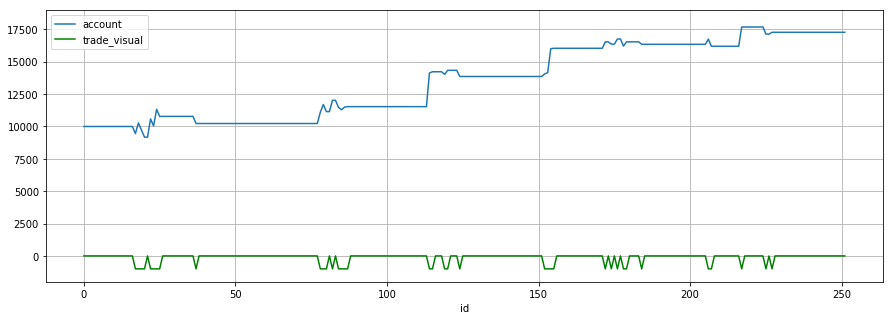

In [345]:
gold_account_nn = get_performance(gold_clf_reg_nn, gold_reg_pca, gold_gains.loc[gold_gains.index > validate_date], gold_reg_validate, gold_reg_label_validate, stop_loss_long=1000, stop_loss_short=800, regression=True, target=20)

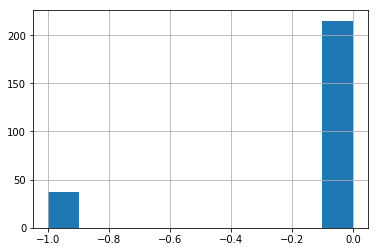

In [346]:
gold_account_nn.trade.hist()

In [347]:
earnings_per_trade(gold_account_nn)

196.68918918918752

In [348]:
earnings_per_shorts(gold_account_nn)

196.68918918918752

In [349]:
earning_per_longs(gold_account_nn)

/home/martin/anaconda3/envs/trading/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


nan

In [350]:
y_pred = np.array([np.asscalar(x) for x in gold_clf_reg_nn.predict(X_test)])

In [340]:
df = pd.DataFrame([])
df['y_true'] = y_test
df['y_pred'] = y_pred
df.corr()

,y_true,y_pred
y_true,1.000000,0.042849
y_pred,0.042849,1.000000


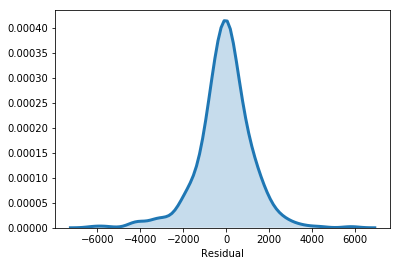

In [341]:
ax = sns.distplot(y_test - [np.asscalar(x) for x in gold_clf_reg_nn.predict(X_test)], hist = False, kde = True,
                  kde_kws = {'shade': True, 'linewidth': 3}, axlabel="Residual")

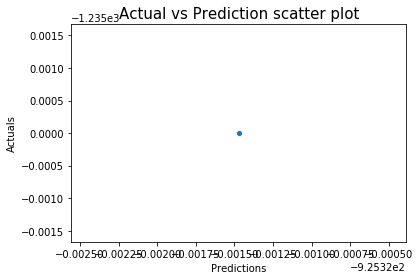

In [342]:
plot_scatter_pred_actual(gold_clf)

In [343]:
X = pca_transform(corn_reg_train, corn_reg_pca)
y = corn_reg_label_train
# remove outliers
X, y = remove_outliers(X, y, out_corn)

X_test = pca_transform(corn_reg_test, corn_reg_pca)
y_test = corn_reg_label_test
X_test, y_test = remove_outliers(X_test, y_test, out_corn)

checkpointer = ModelCheckpoint(filepath='saved_models/weights.corn_reg.hdf5',
                               monitor='val_loss',
                               verbose=1,
                               save_best_only=True,
                               save_weights_only=True)

# loss = huber_loss

estimator = KerasRegressor(build_fn=regressor_model, epochs=50, batch_size=50)
estimator.fit(X, y, validation_data=(X_test, y_test), batch_size=batch_size, epochs=epochs, callbacks=[checkpointer])

Train on 1930 samples, validate on 483 samples
Epoch 1/10000
1930/1930 [==============================] - 6s 3ms/step - loss: 132252.1083 - val_loss: 131890.6382

Epoch 00001: val_loss improved from inf to 131890.63818, saving model to saved_models/weights.corn_reg.hdf5
Epoch 2/10000
1930/1930 [==============================] - 0s 160us/step - loss: 132237.8875 - val_loss: 131889.8861

Epoch 00002: val_loss improved from 131890.63818 to 131889.88614, saving model to saved_models/weights.corn_reg.hdf5
Epoch 3/10000
1930/1930 [==============================] - 0s 185us/step - loss: 132225.2029 - val_loss: 131864.5774

Epoch 00003: val_loss improved from 131889.88614 to 131864.57740, saving model to saved_models/weights.corn_reg.hdf5
Epoch 4/10000
1930/1930 [==============================] - 0s 166us/step - loss: 132181.3204 - val_loss: 131880.5277

Epoch 00004: val_loss did not improve from 131864.57740
Epoch 5/10000
1930/1930 [==============================] - 1s 285us/step - loss: 1320

1930/1930 [==============================] - 1s 288us/step - loss: 61333.7649 - val_loss: 157368.8150

Epoch 00046: val_loss did not improve from 131799.28774
Epoch 47/10000
1930/1930 [==============================] - 1s 285us/step - loss: 59666.0562 - val_loss: 159457.6011

Epoch 00047: val_loss did not improve from 131799.28774
Epoch 48/10000
1930/1930 [==============================] - 1s 282us/step - loss: 58158.2535 - val_loss: 160164.0813

Epoch 00048: val_loss did not improve from 131799.28774
Epoch 49/10000
1930/1930 [==============================] - 1s 286us/step - loss: 54875.1871 - val_loss: 164490.3458

Epoch 00049: val_loss did not improve from 131799.28774
Epoch 50/10000
1930/1930 [==============================] - 1s 284us/step - loss: 53361.6284 - val_loss: 166788.4167

Epoch 00050: val_loss did not improve from 131799.28774
Epoch 51/10000
1930/1930 [==============================] - 1s 282us/step - loss: 53272.5171 - val_loss: 165511.1282

Epoch 00051: val_loss did n

1930/1930 [==============================] - 0s 170us/step - loss: 24549.4781 - val_loss: 216946.2863

Epoch 00093: val_loss did not improve from 131799.28774
Epoch 94/10000
1930/1930 [==============================] - 0s 170us/step - loss: 23689.5467 - val_loss: 218786.7953

Epoch 00094: val_loss did not improve from 131799.28774
Epoch 95/10000
1930/1930 [==============================] - 0s 234us/step - loss: 23885.9563 - val_loss: 219194.9394

Epoch 00095: val_loss did not improve from 131799.28774
Epoch 96/10000
1930/1930 [==============================] - 0s 160us/step - loss: 23884.3277 - val_loss: 220293.5650

Epoch 00096: val_loss did not improve from 131799.28774
Epoch 97/10000
1930/1930 [==============================] - 0s 159us/step - loss: 24574.5997 - val_loss: 217172.7069

Epoch 00097: val_loss did not improve from 131799.28774
Epoch 98/10000
1930/1930 [==============================] - 0s 158us/step - loss: 26941.6596 - val_loss: 222442.2689

Epoch 00098: val_loss did n

KeyboardInterrupt: 

In [ ]:
model = regressor_model()
model.load_weights('saved_models/weights.corn_reg.hdf5')
corn_clf_reg_nn = model

In [ ]:
corn_account_nn = get_performance(corn_clf_reg_nn, corn_reg_pca, corn_gains.loc[corn_gains.index > validate_date], corn_reg_validate, corn_reg_label_validate, stop_loss_long=300, stop_loss_short=300, regression=True, target=0.4)

In [ ]:
earnings_per_trade(corn_account_nn)

In [ ]:
earnings_per_shorts(corn_account_nn)

In [ ]:
earning_per_longs(corn_account_nn)

In [ ]:
X = pca_transform(coffee_reg_train, coffee_reg_pca)
y = coffee_reg_label_train
# remove outliers
# X, y = remove_outliers(X, y, out_corn)

X_test = pca_transform(coffee_reg_test, coffee_reg_pca)
y_test = coffee_reg_label_test
# X_test, y_test = remove_outliers(X_test, y_test, out_corn)

checkpointer = ModelCheckpoint(filepath='saved_models/weights.coffee_reg.hdf5',
                               monitor='val_loss',
                               verbose=1,
                               save_best_only=True,
                               save_weights_only=True)

# loss = huber_loss

estimator = KerasRegressor(build_fn=regressor_model, epochs=epochs, batch_size=batch_size)
estimator.fit(X, y, validation_data=(X_test, y_test), batch_size=batch_size, epochs=epochs, callbacks=[checkpointer])

In [ ]:
model = regressor_model()
model.load_weights('saved_models/weights.coffee_reg.hdf5')
coffee_clf_reg_nn = model

In [ ]:
coffee_account_nn = get_performance(coffee_clf_reg_nn, coffee_reg_pca, coffee_gains.loc[coffee_gains.index > validate_date], coffee_reg_validate, coffee_reg_label_validate, stop_loss_long=1000, stop_loss_short=1000, regression=True, target=50)

In [91]:
X = pca_transform(coffee_train, coffee_pca)
y = coffee_label_train
# remove outliers
X, y = remove_outliers(X, y, out_coffee)

X_test = pca_transform(coffee_test, coffee_pca)
y_test = coffee_label_test
X_test, y_test = remove_outliers(X_test, y_test, out_corn)
y = np.array(list(map(create_target, y)))
y_test = np.array(list(map(create_target, y_test)))

In [92]:
model = define_model(input_shape, num_classes)

checkpointer = ModelCheckpoint(filepath='saved_models/weights.coffee.hdf5',
                               monitor='val_loss',
                               verbose=1,
                               save_best_only=True,
                               save_weights_only=True)

model.fit(X, y, validation_data=(X_test, y_test), batch_size=10, epochs=10, callbacks=[checkpointer])

model.summary()
model.load_weights('saved_models/weights.coffee.hdf5')
coffee_clf_nn = model

Train on 1923 samples, validate on 481 samples
Epoch 1/10
1923/1923 [==============================] - 2s 968us/step - loss: 1345108741.0598 - acc: 0.3703 - val_loss: 118168722.0541 - val_acc: 0.3534

Epoch 00001: val_loss improved from inf to 118168722.05405, saving model to saved_models/weights.coffee.hdf5
Epoch 2/10
1923/1923 [==============================] - 1s 469us/step - loss: 74546425.5624 - acc: 0.3354 - val_loss: 2995577.8018 - val_acc: 0.3493

Epoch 00002: val_loss improved from 118168722.05405 to 2995577.80185, saving model to saved_models/weights.coffee.hdf5
Epoch 3/10
1923/1923 [==============================] - 1s 469us/step - loss: 1452321.3502 - acc: 0.3588 - val_loss: 51528.0584 - val_acc: 0.3493

Epoch 00003: val_loss improved from 2995577.80185 to 51528.05837, saving model to saved_models/weights.coffee.hdf5
Epoch 4/10
1923/1923 [==============================] - 1s 468us/step - loss: 24783.3255 - acc: 0.3796 - val_loss: 1217.0961 - val_acc: 0.3493

Epoch 00004: va

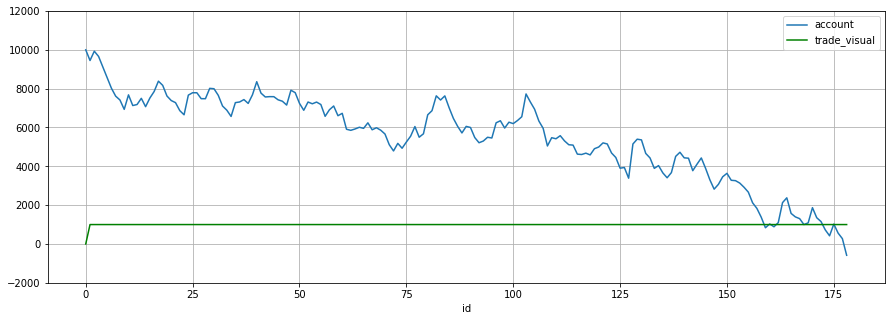

In [93]:
coffee_account_nn = get_performance(coffee_clf_nn, coffee_pca, coffee_gains.loc[coffee_gains.index > validate_date], coffee_validate, coffee_label_validate, stop_loss_long=1000, stop_loss_short=800)

In [94]:
import h2o
from h2o.automl import H2OAutoML

h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "10.0.2" 2018-07-17; OpenJDK Runtime Environment (build 10.0.2+13-Ubuntu-1ubuntu0.18.04.4); OpenJDK 64-Bit Server VM (build 10.0.2+13-Ubuntu-1ubuntu0.18.04.4, mixed mode)
  Starting server from /home/martin/anaconda3/envs/trading/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp813w2r31
  JVM stdout: /tmp/tmp813w2r31/h2o_martin_started_from_python.out
  JVM stderr: /tmp/tmp813w2r31/h2o_martin_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,02 secs
H2O cluster timezone:,Europe/Bratislava
H2O data parsing timezone:,UTC
H2O cluster version:,3.22.1.2
H2O cluster version age:,15 days
H2O cluster name:,H2O_from_python_martin_lp2l29
H2O cluster total nodes:,1
H2O cluster free memory:,3.898 Gb
H2O cluster total cores:,6
H2O cluster allowed cores:,6
H2O cluster status:,"accepting new members, healthy"


In [159]:
# Import a sample binary outcome train/test set into H2O
train = h2o.import_file("data/gold_pca_long_train.csv", header=1)
validation = h2o.import_file("data/gold_pca_long_validation.csv", header=1)
test = h2o.import_file("data/gold_pca_long_test.csv", header=1)

# Identify predictors and response
# model.fit(X, y, validation_data=(X_test, y_test), batch_size=10, epochs=10, callbacks=[checkpointer])
print(train.head())
x = train.columns
# print(x)
y = "label"
x.remove(y)

# For binary classification, response should be a factor
train[y] = train[y].asfactor()
test[y] = test[y].asfactor()
validation[y] = validation[y].asfactor()

# Run AutoML for 20 base models (limited to 1 hour max runtime by default)
aml = H2OAutoML(max_models=20, max_runtime_secs=60, seed=1234)
aml.train(x=x, y=y, training_frame=train, validation_frame=validation)

# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

# The leader model is stored here
# aml.leader

# If you need to generate predictions on a test set, you can make
# predictions directly on the `"H2OAutoML"` object, or on the leader
# model object directly

# preds = aml.predict(test)

# or:
# preds = aml.leader.predict(test)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,label
-331248,-27640.9,567537,65888,59525.3,252953,55627.8,-128754,107663,-216796,-88335.2,-158876,-132529,109756,-46148.4,-48245.6,102093,-26637.8,30540.3,96452.1,128859,-45519.2,7388.33,-52116.5,-102421,11500.5,193271,43334.5,2318.45,102827,51533.9,86567.1,36590.9,-261.471,-59536.9,-16780.8,-31926.2,7549.36,-39839.9,-36907,-78908.1,38478.6,75299.2,59309.6,-57772.2,-962.663,6690.14,71931.1,-20808.7,7261.05,33567,44209.2,-49242.1,-84342.9,-44027.2,-2084.94,10368.8,38870.4,-613.096,-32479,69451.2,308.221,-13364.1,15870.4,-49266.6,45870.5,63105.2,-35490.1,-65715.3,-4788.1,34259,-20494.4,33098.7,-102350,51410.6,8269.36,-16840.7,108658,17342.1,-1218.5,0
-325632,-21861.3,570463,61896.1,12385.9,263138,67919.7,-122209,98093.2,-221691,-106286,-152934,-113507,123913,-42962.8,-38258.6,83315,-40127.8,40585.4,115445,118744,-60000.3,15372.9,-53794.5,-114798,15974.6,177376,-17248.1,17314,124687,34921.7,80344.1,61220.2,-37308,-29867.1,-1166.26,-41296.1,26294.9,109.477,-68993.8,3021.78,23894.8,104695,12254.5,-66689,-64384.8,41809,42767.2,194.094,-8747.76,-1925.62,38345.7,-77664.3,-54666.2,-75536.2,-25712.6,2171.34,46412,-21732.1,-54354.6,70197.5,24713.4,-44916.4,37495.3,-9355.41,22926.4,98297.6,13941.7,-100836,-23571.8,-11543.4,-25245.6,1870.39,-105292,57833.5,12001.5,-23465.3,69521,-14994.5,50927,1
-322972,-16385.8,569003,64186.8,-29837.6,269476,79430.7,-118529,87320.3,-225986,-112892,-147941,-110230,120907,-33344.8,-40149.1,70584.6,-51203.1,35466.7,134176,101251,-54181.9,32549,-58639.4,-126134,37056.1,155366,-57261.2,40551.1,120155,23424.2,25997.1,2780.28,-89568.8,-15708.8,-1011.36,-68905.6,24145.3,51560,-75562.2,92220.7,8410.63,47008.7,-16419,-70000.6,-96951.1,7842.87,27329.6,19328.6,-28293.3,8712.07,-1664.12,-47051,-6499.19,-42734.9,-39065.3,-10421.2,37505.3,-23146.1,-86740.1,47309.8,49220.8,-50103.9,42567,22345.8,25395,106873,-11562.2,-67847.8,-6094.93,-21463.6,-21262.2,-62921.7,-124364,37153.9,3217.51,14044.9,41059.4,-16838.2,63429.1,1
-316808,-6871.1,569417,64689.3,-75301.1,262696,87154.3,-117425,70892.4,-225472,-119147,-141073,-101452,121946,-29478,-35954.6,52410.8,-54979.7,24516.5,144165,96567.9,-49778.7,49584.8,-63032.9,-129809,59836,140934,-80893.9,70166.7,95379.1,17779,-300.186,-69981.9,-68409.1,-53193.1,-8773.45,-77613.8,-690.233,84757.2,-42160.4,73084.6,5194.72,-13450.3,-4637.24,-40211.7,-82969.9,-74083.9,-7290.44,37658.2,-22197.8,37563.1,-26045.5,5925.39,13381.6,-11238.4,-27809.2,-21976.3,7101.6,-10176.7,-65430.9,7572.18,48541.9,-17773.3,1362.76,57727.9,50370.6,43325.8,-31816.9,-40618.2,-21021.1,45190.8,-927.648,-63506.2,-128467,47232.8,-1175.38,29869.7,43793.4,-20564.1,25002.6,0
-311643,-2933.21,571396,65302.7,-116766,251966,94039.7,-113414,58898.7,-226860,-127331,-131106,-87170.6,123316,-5729.58,-29416.6,27780.2,-63476.6,13070.8,140149,75534.3,-36219.2,68059.3,-64575,-124319,77225.4,122836,-106852,85759.3,57896.1,-4025.9,33095,-69901.3,11078.4,-60444.2,11496.5,-56333.5,-27841.1,62559.1,1880.24,-35582.4,7252.48,672.795,12673.6,32485.4,-45225.6,-106941,-22441.3,39815.6,11214.1,39814,-43807.1,28552.5,4927.01,865.923,-23618.3,-18297.8,17215.7,-20141.2,-8358.09,-36849.8,45296.1,8547.15,-20315.1,51379,36716.6,25751.1,36215.7,-25144.7,-40982.2,56331.2,-16888.3,-21630.9,-81136.2,71368.8,-31081.7,42092.4,-11048.7,-26872.3,-2778.75,0
-310540,3470.74,571167,64108.9,-155840,235912,99022.3,-115409,42634.7,-232187,-129203,-123842,-84895.3,138084,5182.18,-19952.6,11087.3,-58375.5,5129.72,147405,54514.1,-43918.4,75885.3,-68708.9,-125510,98557,111676,-132713,81975.1,31437.4,-42821.1,79131.3,-17202.3,30141,-17240.8,49475.8,-77480.7,-43058.4,29571.4,48094.2,-66596.9,6519.93,40658.5,6558.03,101925,-34460.8,-49257.1,14.6275,42718.4,35107.8,35705.7,-59495.1,23003.7,-13948.8,20768.9,-51227.8,-6901.91,27445.4,-29045.1,23633


AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id,auc,logloss,mean_per_class_error,rmse,mse
StackedEnsemble_AllModels_AutoML_20190131_112654,0.5,0.60678,0.5,0.456152,0.208075
StackedEnsemble_BestOfFamily_AutoML_20190131_112654,0.5,0.60678,0.5,0.456152,0.208075
GLM_grid_1_AutoML_20190131_112654_model_1,0.478157,0.6075,0.496698,0.456483,0.208377
DRF_1_AutoML_20190131_112654,0.450022,0.748437,0.5,0.490751,0.240837
XRT_1_AutoML_20190131_112654,0.445851,0.730067,0.496982,0.491442,0.241515


stackedensemble prediction progress: |████████████████████████████████████| 100%


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0589a255c0>]],
      dtype=object)

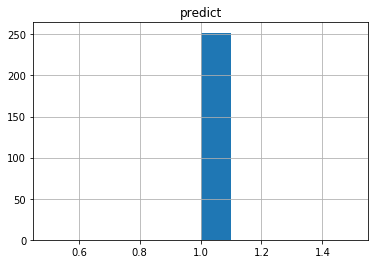

In [130]:
preds = aml.leader.predict(test)
a = preds[0].as_data_frame()
b = a.predict.values
a.hist()

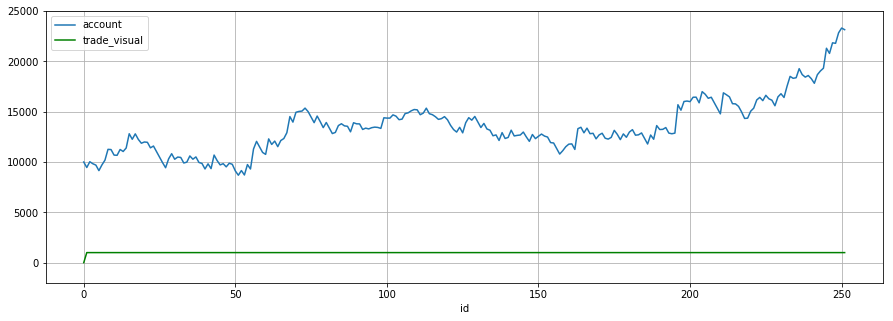

In [131]:
gold_account = get_account(b, gold_gains.loc[gold_gains.index > validate_date], gold_label_validate, stop_loss_long=1000, stop_loss_short=800)

In [85]:
from sklearn.metrics import f1_score

In [86]:
from sklearn.metrics import confusion_matrix

df = gold_account[['label', 'trade']]
f1_score(df.label.map(lambda x: 0 if x < 0 else x).values, df.trade.values)

0.28402366863905326

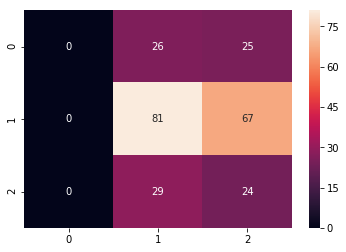

In [87]:
sns.heatmap(confusion_matrix(df['label'], df['trade']), annot=True, fmt="d")

In [88]:
gold_account['stop_loss'].sum()

26

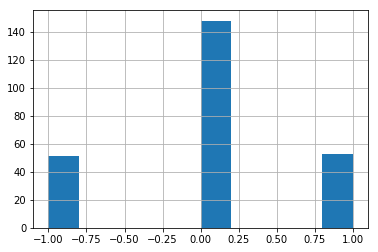

In [89]:
df['label'].hist()

In [163]:
# Import a sample binary outcome train/test set into H2O
train = h2o.import_file("data/gold_pca_reg_train.csv", header=1)
validation = h2o.import_file("data/gold_pca_reg_validation.csv", header=1)
test = h2o.import_file("data/gold_pca_reg_test.csv", header=1)

# Identify predictors and response
# model.fit(X, y, validation_data=(X_test, y_test), batch_size=10, epochs=10, callbacks=[checkpointer])
print(train.head())
x = train.columns
y = "80"
x.remove(y)

# For binary classification, response should be a factor
# train[y] = train[y].asfactor()
# test[y] = test[y].asfactor()
# validation[y] = validation[y].asfactor()

# Run AutoML for 20 base models (limited to 1 hour max runtime by default)
aml = H2OAutoML(max_models=20, max_runtime_secs=3600, seed=1234)
aml.train(x=x, y=y, training_frame=train, validation_frame=validation)

# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

# The leader model is stored here
# aml.leader

# If you need to generate predictions on a test set, you can make
# predictions directly on the `"H2OAutoML"` object, or on the leader
# model object directly

# preds = aml.predict(test)

# or:
# preds = aml.leader.predict(test)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80
-331248,-27640.9,567537,65888,59525.3,252953,55627.8,-128754,107663,-216796,-88335.2,-158876,-132529,109756,-46148.4,-48245.6,102093,-26637.8,30540.3,96452.1,128859,-45519.2,7388.33,-52116.5,-102421,11500.5,193271,43334.5,2318.45,102827,51533.9,86567.1,36590.9,-261.471,-59536.9,-16780.8,-31926.2,7549.36,-39839.9,-36907,-78908.1,38478.6,75299.2,59309.6,-57772.2,-962.663,6690.14,71931.1,-20808.7,7261.05,33567,44209.2,-49242.1,-84342.9,-44027.2,-2084.94,10368.8,38870.4,-613.096,-32479,69451.2,308.221,-13364.1,15870.4,-49266.6,45870.5,63105.2,-35490.1,-65715.3,-4788.1,34259,-20494.4,33098.7,-102350,51410.6,8269.36,-16840.7,108658,17342.1,-1218.5,-589
-325632,-21861.3,570463,61896.1,12385.9,263138,67919.7,-122209,98093.2,-221691,-106286,-152934,-113507,123913,-42962.8,-38258.6,83315,-40127.8,40585.4,115445,118744,-60000.3,15372.9,-53794.5,-114798,15974.6,177376,-17248.1,17314,124687,34921.7,80344.1,61220.2,-37308,-29867.1,-1166.26,-41296.1,26294.9,109.477,-68993.8,3021.78,23894.8,104695,12254.5,-66689,-64384.8,41809,42767.2,194.094,-8747.76,-1925.62,38345.7,-77664.3,-54666.2,-75536.2,-25712.6,2171.34,46412,-21732.1,-54354.6,70197.5,24713.4,-44916.4,37495.3,-9355.41,22926.4,98297.6,13941.7,-100836,-23571.8,-11543.4,-25245.6,1870.39,-105292,57833.5,12001.5,-23465.3,69521,-14994.5,50927,1757.5
-322972,-16385.8,569003,64186.8,-29837.6,269476,79430.7,-118529,87320.3,-225986,-112892,-147941,-110230,120907,-33344.8,-40149.1,70584.6,-51203.1,35466.7,134176,101251,-54181.9,32549,-58639.4,-126134,37056.1,155366,-57261.2,40551.1,120155,23424.2,25997.1,2780.28,-89568.8,-15708.8,-1011.36,-68905.6,24145.3,51560,-75562.2,92220.7,8410.63,47008.7,-16419,-70000.6,-96951.1,7842.87,27329.6,19328.6,-28293.3,8712.07,-1664.12,-47051,-6499.19,-42734.9,-39065.3,-10421.2,37505.3,-23146.1,-86740.1,47309.8,49220.8,-50103.9,42567,22345.8,25395,106873,-11562.2,-67847.8,-6094.93,-21463.6,-21262.2,-62921.7,-124364,37153.9,3217.51,14044.9,41059.4,-16838.2,63429.1,1054.5
-316808,-6871.1,569417,64689.3,-75301.1,262696,87154.3,-117425,70892.4,-225472,-119147,-141073,-101452,121946,-29478,-35954.6,52410.8,-54979.7,24516.5,144165,96567.9,-49778.7,49584.8,-63032.9,-129809,59836,140934,-80893.9,70166.7,95379.1,17779,-300.186,-69981.9,-68409.1,-53193.1,-8773.45,-77613.8,-690.233,84757.2,-42160.4,73084.6,5194.72,-13450.3,-4637.24,-40211.7,-82969.9,-74083.9,-7290.44,37658.2,-22197.8,37563.1,-26045.5,5925.39,13381.6,-11238.4,-27809.2,-21976.3,7101.6,-10176.7,-65430.9,7572.18,48541.9,-17773.3,1362.76,57727.9,50370.6,43325.8,-31816.9,-40618.2,-21021.1,45190.8,-927.648,-63506.2,-128467,47232.8,-1175.38,29869.7,43793.4,-20564.1,25002.6,-864.5
-311643,-2933.21,571396,65302.7,-116766,251966,94039.7,-113414,58898.7,-226860,-127331,-131106,-87170.6,123316,-5729.58,-29416.6,27780.2,-63476.6,13070.8,140149,75534.3,-36219.2,68059.3,-64575,-124319,77225.4,122836,-106852,85759.3,57896.1,-4025.9,33095,-69901.3,11078.4,-60444.2,11496.5,-56333.5,-27841.1,62559.1,1880.24,-35582.4,7252.48,672.795,12673.6,32485.4,-45225.6,-106941,-22441.3,39815.6,11214.1,39814,-43807.1,28552.5,4927.01,865.923,-23618.3,-18297.8,17215.7,-20141.2,-8358.09,-36849.8,45296.1,8547.15,-20315.1,51379,36716.6,25751.1,36215.7,-25144.7,-40982.2,56331.2,-16888.3,-21630.9,-81136.2,71368.8,-31081.7,42092.4,-11048.7,-26872.3,-2778.75,-522.5
-310540,3470.74,571167,64108.9,-155840,235912,99022.3,-115409,42634.7,-232187,-129203,-123842,-84895.3,138084,5182.18,-19952.6,11087.3,-58375.5,5129.72,147405,54514.1,-43918.4,75885.3,-68708.9,-125510,98557,111676,-132713,81975.1,31437.4,-42821.1,79131.3,-17202.3,30141,-17240.8,49475.8,-77480.7,-43058.4,29571.4,48094.2,-66596.9,6519.93,40658.5,6558.03,101925,-34460.8,-49257.1,14.6275,42718.4,35107.8,35705.7,-59495.1,23003.7,-13948.8,20768.9,-51227.8,-6901.91,27


AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id,mean_residual_deviance,rmse,mse,mae,rmsle
StackedEnsemble_AllModels_AutoML_20190131_112933,1.68303e+06,1297.32,1.68303e+06,895.745,nan
StackedEnsemble_BestOfFamily_AutoML_20190131_112933,1.6838e+06,1297.61,1.6838e+06,896.455,nan
GLM_grid_1_AutoML_20190131_112933_model_1,1.6843e+06,1297.8,1.6843e+06,895.893,nan
GBM_grid_1_AutoML_20190131_112933_model_4,1.6883e+06,1299.35,1.6883e+06,897.028,nan
GBM_grid_1_AutoML_20190131_112933_model_1,1.69312e+06,1301.2,1.69312e+06,898.723,nan
GBM_grid_1_AutoML_20190131_112933_model_3,1.69475e+06,1301.82,1.69475e+06,898.656,nan
GBM_grid_1_AutoML_20190131_112933_model_5,1.69868e+06,1303.34,1.69868e+06,900.334,nan
GBM_5_AutoML_20190131_112933,1.76814e+06,1329.71,1.76814e+06,922.226,nan
DeepLearning_1_AutoML_20190131_112933,1.78268e+06,1335.17,1.78268e+06,943.6,nan
DeepLearning_grid_1_AutoML_20190131_112933_model_3,1.80751e+06,1344.44,1.80751e+06,947.193,nan


stackedensemble prediction progress: |████████████████████████████████████| 100%


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0604541cf8>]],
      dtype=object)

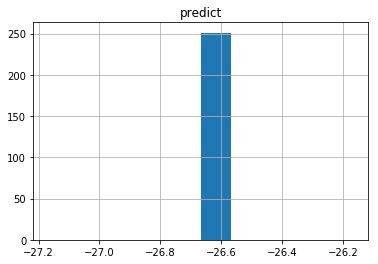

In [164]:
preds = aml.leader.predict(test)
a = preds[0].as_data_frame()
b = a.predict.values
a.hist()

In [165]:
b

array([-26.66778697, -26.66778697, -26.66778697, -26.66778697,
       -26.66778697, -26.66778697, -26.66778697, -26.66778697,
       -26.66778697, -26.66778697, -26.66778697, -26.66778697,
       -26.66778697, -26.66778697, -26.66778697, -26.66778697,
       -26.66778697, -26.66778697, -26.66778697, -26.66778697,
       -26.66778697, -26.66778697, -26.66778697, -26.66778697,
       -26.66778697, -26.66778697, -26.66778697, -26.66778697,
       -26.66778697, -26.66778697, -26.66778697, -26.66778697,
       -26.66778697, -26.66778697, -26.66778697, -26.66778697,
       -26.66778697, -26.66778697, -26.66778697, -26.66778697,
       -26.66778697, -26.66778697, -26.66778697, -26.66778697,
       -26.66778697, -26.66778697, -26.66778697, -26.66778697,
       -26.66778697, -26.66778697, -26.66778697, -26.66778697,
       -26.66778697, -26.66778697, -26.66778697, -26.66778697,
       -26.66778697, -26.66778697, -26.66778697, -26.66778697,
       -26.66778697, -26.66778697, -26.66778697, -26.66

In [91]:
# Import a sample binary outcome train/test set into H2O
train = h2o.import_file("data/gold_pca_short_train.csv")
validation = h2o.import_file("data/gold_pca_short_validation.csv")
test = h2o.import_file("data/gold_pca_short_test.csv")

# Identify predictors and response
# model.fit(X, y, validation_data=(X_test, y_test), batch_size=10, epochs=10, callbacks=[checkpointer])
x = train.columns
y = "C81"
x.remove(y)

# For binary classification, response should be a factor
train[y] = train[y].asfactor()
validation[y] = validation[y].asfactor()
test[y] = test[y].asfactor()

# Run AutoML for 20 base models (limited to 1 hour max runtime by default)
# aml = H2OAutoML(max_models=20, max_runtime_secs=600, seed=1234)
aml = H2OAutoML(max_runtime_secs=600, seed=1234)
aml.train(x=x, y=y, training_frame=train, validation_frame=validation)

# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

# The leader model is stored here
# aml.leader

# If you need to generate predictions on a test set, you can make
# predictions directly on the `"H2OAutoML"` object, or on the leader
# model object directly

# preds = aml.predict(test)

# or:
# preds = aml.leader.predict(test)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id,auc,logloss,mean_per_class_error,rmse,mse
GLM_grid_1_AutoML_20190128_201329_model_1,0.529463,0.602785,0.499635,0.454115,0.206221
GBM_grid_1_AutoML_20190128_201329_model_3,0.524985,0.613129,0.498328,0.458679,0.210387
GBM_grid_1_AutoML_20190128_201329_model_5,0.519633,0.603576,0.498174,0.454527,0.206595
GBM_grid_1_AutoML_20190128_201329_model_7,0.516039,0.720863,0.491557,0.493923,0.24396
DeepLearning_grid_1_AutoML_20190128_201329_model_4,0.514591,0.844366,0.5,0.503284,0.253295
GBM_grid_1_AutoML_20190128_201329_model_4,0.512316,0.604366,0.499059,0.454899,0.206934
XRT_1_AutoML_20190128_201329,0.510556,0.658508,0.494831,0.477138,0.227661
GBM_grid_1_AutoML_20190128_201329_model_1,0.509745,0.60447,0.492245,0.454946,0.206976
GBM_grid_1_AutoML_20190128_201329_model_10,0.509188,1.26487,0.5,0.545884,0.297989
GBM_5_AutoML_20190128_201329,0.507789,0.620216,0.499635,0.461899,0.213351


glm prediction progress: |████████████████████████████████████████████████| 100%


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4679963c18>]],
      dtype=object)

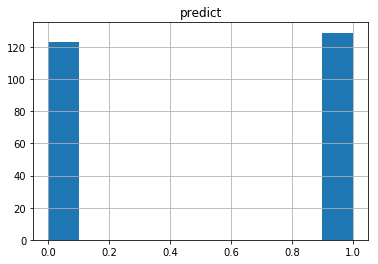

In [92]:
preds = aml.leader.predict(test)
a = preds[0].as_data_frame()
b = a.predict.values
a.hist()

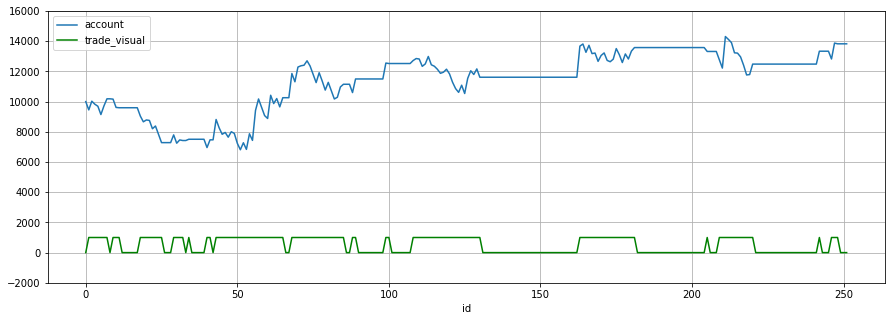

In [93]:
gold_account = get_account(b, gold_gains.loc[gold_gains.index > validate_date], gold_label_validate, stop_loss_long=1000, stop_loss_short=800)

In [94]:
df = gold_account[['label', 'trade']]
f1_score(df.label.map(lambda x: 1 if x == -1 else 0).values, df.trade.map(lambda x: 1 if x == -1 else 0).values)

/home/martin/anaconda3/envs/trading/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0.0

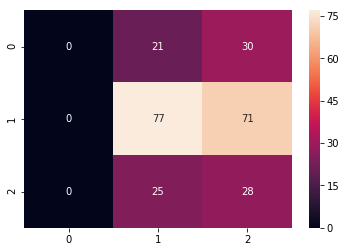

In [95]:
sns.heatmap(confusion_matrix(df['label'], df['trade']), annot=True, fmt="d")

In [96]:
# Import a sample binary outcome train/test set into H2O
train = h2o.import_file("data/corn_pca_short_train.csv")
validation = h2o.import_file("data/corn_pca_short_validation.csv")
test = h2o.import_file("data/corn_pca_short_test.csv")

# Identify predictors and response
# model.fit(X, y, validation_data=(X_test, y_test), batch_size=10, epochs=10, callbacks=[checkpointer])
x = train.columns
y = "C81"
x.remove(y)

# For binary classification, response should be a factor
train[y] = train[y].asfactor()
validation[y] = validation[y].asfactor()
test[y] = test[y].asfactor()

# Run AutoML for 20 base models (limited to 1 hour max runtime by default)
aml = H2OAutoML(max_models=20, max_runtime_secs=600, seed=1234)
aml.train(x=x, y=y, training_frame=train, validation_frame=validation)

# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

# The leader model is stored here
# aml.leader

# If you need to generate predictions on a test set, you can make
# predictions directly on the `"H2OAutoML"` object, or on the leader
# model object directly

# preds = aml.predict(test)

# or:
# preds = aml.leader.predict(test)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id,auc,logloss,mean_per_class_error,rmse,mse
StackedEnsemble_AllModels_AutoML_20190128_202227,0.566971,0.596358,0.479809,0.45116,0.203546
GBM_5_AutoML_20190128_202227,0.566312,0.601107,0.46016,0.453476,0.20564
StackedEnsemble_BestOfFamily_AutoML_20190128_202227,0.563836,0.596511,0.470983,0.451183,0.203566
GBM_grid_1_AutoML_20190128_202227_model_1,0.563351,0.597617,0.467045,0.451631,0.203971
GBM_3_AutoML_20190128_202227,0.556856,0.63072,0.455144,0.463887,0.215191
DeepLearning_grid_1_AutoML_20190128_202227_model_1,0.556806,0.945067,0.47665,0.513596,0.263781
DeepLearning_grid_1_AutoML_20190128_202227_model_2,0.556422,1.57827,0.472329,0.568948,0.323702
GBM_grid_1_AutoML_20190128_202227_model_3,0.556421,0.597966,0.469095,0.451809,0.204131
GBM_1_AutoML_20190128_202227,0.554547,0.623957,0.476599,0.462,0.213444
GBM_grid_1_AutoML_20190128_202227_model_4,0.553946,0.599035,0.465674,0.452275,0.204553


stackedensemble prediction progress: |████████████████████████████████████| 100%


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4679867048>]],
      dtype=object)

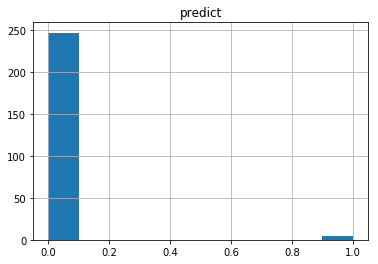

In [97]:
preds = aml.leader.predict(test)
a = preds[0].as_data_frame()
b = a.predict.map(lambda x: -1 if x > 0 else 0).values
a.hist()

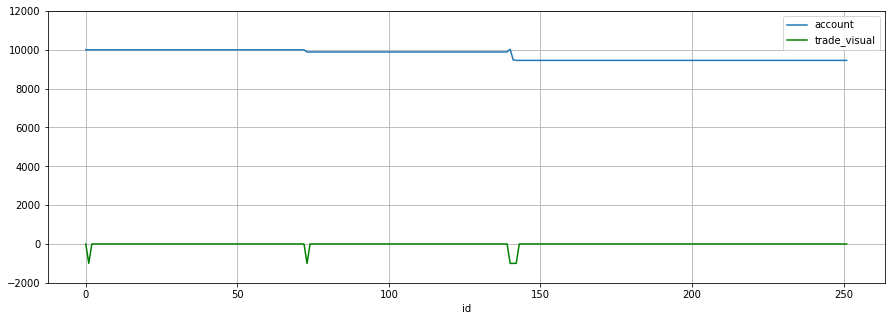

In [98]:
corn_account = get_account(b, corn_gains.loc[corn_gains.index > validate_date], corn_label_validate, stop_loss_long=300, stop_loss_short=300)

In [99]:
df = corn_account[['label', 'trade']]
f1_score(df.label.map(lambda x: x if x >= 0 else 0).values, df.trade.map(lambda x: x if x >= 0 else 0).values)

0.0

In [100]:
# Import a sample binary outcome train/test set into H2O
train = h2o.import_file("data/corn_pca_long_train.csv")
validation = h2o.import_file("data/corn_pca_long_validation.csv")
test = h2o.import_file("data/corn_pca_long_test.csv")

# Identify predictors and response
# model.fit(X, y, validation_data=(X_test, y_test), batch_size=10, epochs=10, callbacks=[checkpointer])
x = train.columns
y = "C81"
x.remove(y)

# For binary classification, response should be a factor
train[y] = train[y].asfactor()
validation[y] = validation[y].asfactor()
test[y] = test[y].asfactor()

# Run AutoML for 20 base models (limited to 1 hour max runtime by default)
aml = H2OAutoML(max_models=20, max_runtime_secs=600, seed=1234)
aml.train(x=x, y=y, training_frame=train, validation_frame=validation)

# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

# The leader model is stored here
# aml.leader

# If you need to generate predictions on a test set, you can make
# predictions directly on the `"H2OAutoML"` object, or on the leader
# model object directly

# preds = aml.predict(test)

# or:
# preds = aml.leader.predict(test)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id,auc,logloss,mean_per_class_error,rmse,mse
GBM_4_AutoML_20190128_202958,0.558644,0.650473,0.461411,0.472367,0.223131
GBM_5_AutoML_20190128_202958,0.553718,0.618722,0.5,0.46185,0.213305
StackedEnsemble_BestOfFamily_AutoML_20190128_202958,0.553311,0.612408,0.5,0.459219,0.210882
GBM_3_AutoML_20190128_202958,0.552521,0.642998,0.484246,0.470982,0.221824
GBM_grid_1_AutoML_20190128_202958_model_1,0.551435,0.613053,0.441366,0.459515,0.211154
GBM_1_AutoML_20190128_202958,0.550972,0.636459,0.485388,0.469166,0.220116
GBM_grid_1_AutoML_20190128_202958_model_3,0.547657,0.613104,0.47288,0.459532,0.211169
GLM_grid_1_AutoML_20190128_202958_model_1,0.543377,0.61379,0.49712,0.459864,0.211475
GBM_2_AutoML_20190128_202958,0.542382,0.639702,0.493638,0.469859,0.220767
StackedEnsemble_AllModels_AutoML_20190128_202958,0.542138,0.613357,0.497224,0.459656,0.211284


gbm prediction progress: |████████████████████████████████████████████████| 100%


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4679bf9c50>]],
      dtype=object)

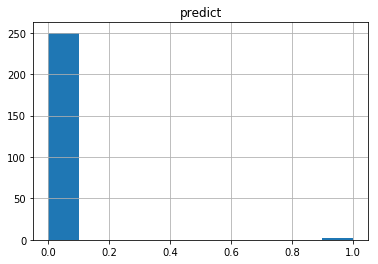

In [101]:
preds = aml.leader.predict(test)
a = preds[0].as_data_frame()
b = a.predict.values
a.hist()

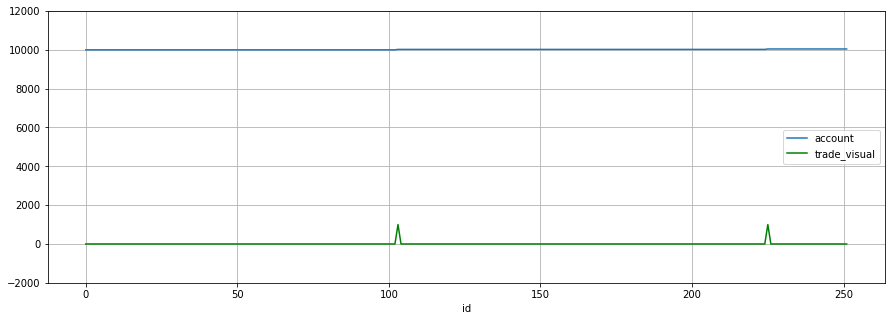

In [102]:
corn_account = get_account(b, corn_gains.loc[corn_gains.index > validate_date], corn_label_validate, stop_loss_long=300, stop_loss_short=300)

In [103]:
# Import a sample binary outcome train/test set into H2O
train = h2o.import_file("data/coffee_pca_long.csv")
test = h2o.import_file("data/coffee_pca_long_test.csv")

# Identify predictors and response
# model.fit(X, y, validation_data=(X_test, y_test), batch_size=10, epochs=10, callbacks=[checkpointer])
x = train.columns
y = "C81"
x.remove(y)

# For binary classification, response should be a factor
train[y] = train[y].asfactor()
test[y] = test[y].asfactor()

# Run AutoML for 20 base models (limited to 1 hour max runtime by default)
aml = H2OAutoML(max_models=20, max_runtime_secs=600, seed=1234)
aml.train(x=x, y=y, training_frame=train)

# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id,auc,logloss,mean_per_class_error,rmse,mse
DeepLearning_grid_1_AutoML_20190128_203653_model_3,0.531394,1.86129,0.5,0.600859,0.361032
GBM_4_AutoML_20190128_203653,0.524811,0.687303,0.498704,0.493061,0.243109
DeepLearning_1_AutoML_20190128_203653,0.523665,0.72496,0.493237,0.500294,0.250294
DeepLearning_grid_1_AutoML_20190128_203653_model_1,0.521768,1.04249,0.5,0.53196,0.282981
StackedEnsemble_BestOfFamily_AutoML_20190128_203653,0.520639,0.652494,0.5,0.479544,0.229963
GBM_1_AutoML_20190128_203653,0.520264,0.677614,0.497395,0.489861,0.239964
StackedEnsemble_AllModels_AutoML_20190128_203653,0.519522,0.652796,0.5,0.479684,0.230096
GBM_5_AutoML_20190128_203653,0.513988,0.661591,0.5,0.483463,0.233737
GBM_2_AutoML_20190128_203653,0.513774,0.68268,0.499028,0.492165,0.242226
DeepLearning_grid_1_AutoML_20190128_203653_model_4,0.512674,2.03851,0.5,0.598494,0.358195


deeplearning prediction progress: |███████████████████████████████████████| 100%


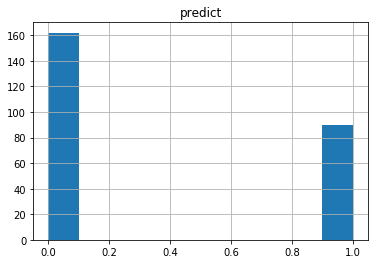

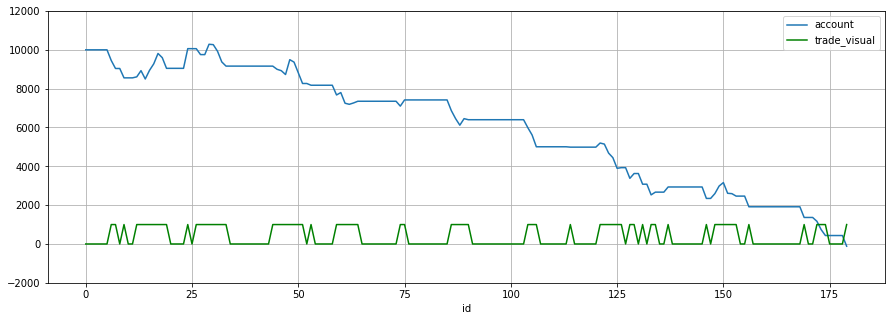

In [104]:
preds = aml.leader.predict(test)
a = preds[0].as_data_frame()
b = a.predict.values
a.hist()

coffee_account = get_account(b, coffee_gains.loc[coffee_gains.index > validate_date], coffee_label_validate, stop_loss_long=800, stop_loss_short=800)

In [105]:
# Import a sample binary outcome train/test set into H2O
train = h2o.import_file("data/coffee_pca_short.csv")
test = h2o.import_file("data/coffee_pca_short_test.csv")

# Identify predictors and response
# model.fit(X, y, validation_data=(X_test, y_test), batch_size=10, epochs=10, callbacks=[checkpointer])
x = train.columns
y = "C81"
x.remove(y)

# For binary classification, response should be a factor
train[y] = train[y].asfactor()
test[y] = test[y].asfactor()

# Run AutoML for 20 base models (limited to 1 hour max runtime by default)
aml = H2OAutoML(max_models=20, max_runtime_secs=600, seed=1234)
aml.train(x=x, y=y, training_frame=train)

# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id,auc,logloss,mean_per_class_error,rmse,mse
GBM_grid_1_AutoML_20190128_204356_model_2,0.514271,1.41535,0.5,0.58845,0.346273
GBM_5_AutoML_20190128_204356,0.514097,0.672301,0.5,0.489065,0.239185
XRT_1_AutoML_20190128_204356,0.509603,0.694445,0.497432,0.498639,0.248641
DRF_1_AutoML_20190128_204356,0.509136,0.697951,0.49191,0.500152,0.250152
GBM_1_AutoML_20190128_204356,0.506071,0.695037,0.5,0.498238,0.248241
DeepLearning_grid_1_AutoML_20190128_204356_model_3,0.504641,1.8096,0.5,0.617128,0.380847
DeepLearning_grid_1_AutoML_20190128_204356_model_4,0.501634,1.74159,0.5,0.60757,0.369142
GBM_grid_1_AutoML_20190128_204356_model_5,0.500502,0.66349,0.5,0.485072,0.235295
GBM_grid_1_AutoML_20190128_204356_model_1,0.499309,0.663267,0.5,0.484969,0.235195
GBM_2_AutoML_20190128_204356,0.499267,0.699571,0.499666,0.500289,0.250289


gbm prediction progress: |████████████████████████████████████████████████| 100%


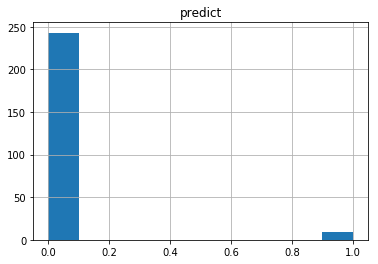

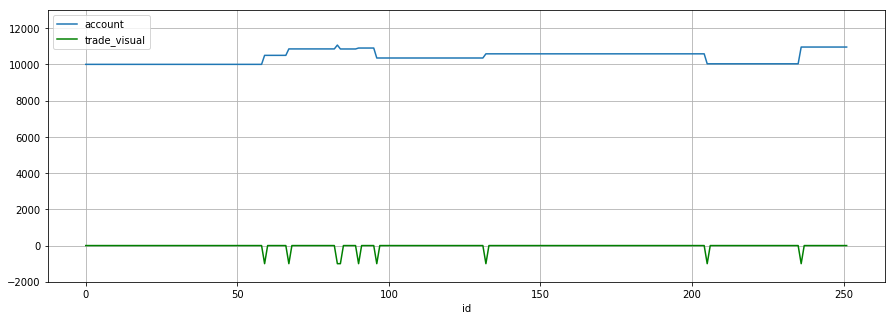

In [106]:
preds = aml.leader.predict(test)
a = preds[0].as_data_frame()
b = a.predict.map(lambda x: -1 if x == 1 else 0).values
a.hist()

coffee_account = get_account(b, coffee_gains.loc[coffee_gains.index > validate_date], coffee_label_validate, stop_loss_long=800, stop_loss_short=800)

In [107]:
# %%capture cpt_corn_train
X = pca_transform(corn_train, corn_pca)
X_test = pca_transform(corn_test, corn_pca)

y = gold_label_train
y_test = gold_label_test

y = np.array(list(map(create_target, y.values)))
y_test = np.array(list(map(create_target, y_test.values)))

In [108]:
input_shape = 90
num_classes = 3

# Define a model
model = Sequential()  
model.add(Dense(32, input_dim=input_shape, activity_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dropout(0.5))
model.add(Dense(16, activity_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('sigmoid'))

opt = Nadam(lr=0.002)

In [109]:
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(filepath='saved_models/weights.corn.hdf5',
                               monitor='val_acc',
                               verbose=1, save_best_only=True,
                               save_weights_only=True)

model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X, y, validation_data=(X_test, y_test), batch_size=1, epochs=10, callbacks=[checkpointer])

model.summary()

ValueError: Error when checking input: expected dense_13_input to have shape (90,) but got array with shape (80,)

In [ ]:
model.load_weights('saved_models/weights.corn.hdf5')
corn_clf_long = model

In [ ]:
corn_account_long = get_performance(corn_clf_long, corn_pca, corn_gains.loc[corn_gains.index > validate_date], corn_validate, corn_label_validate, stop_loss=300)
ax1 = corn_account_long[['account']].plot(grid=True)
ax1.set_ylim(0, get_round_ceiling(corn_account_long.account))

In [ ]:
corn_account_long[corn_account_long['long'] == 1].gains.sum()

In [ ]:
corn_account_long[corn_account_long['short'] == 1].gains.sum()

In [ ]:
corn_account_long[corn_account_long['long'] == 1].label.hist()

In [ ]:
corn_account_long[['trade', 'label']].hist()

In [ ]:
# %%capture cpt_coffee_train
param['max_bin'] = 10
X = pca_transform(coffee_train, coffee_pca)
X_test = pca_transform(coffee_test, coffee_pca)
y = list(map(lambda x: 1 if x < 0 else 0, coffee_label_test))
model = Sequential()  
model.add(Dense(64, input_dim=input_shape, activity_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dropout(0.5))
model.add(Dense(16, activity_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dense(num_classes))
model.add(Activation('softmax'))

opt = Nadam(lr=0.002)

model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=2)

model.summary()

coffee_clf_long = model
# coffee_clf_long = lgb.train(param, train_data, num_round, valid_sets=[test_data])

In [ ]:
coffee_account_long = get_performance(coffee_clf_long, coffee_pca, coffee_gains.loc[coffee_gains.index > validate_date], corn_validate, coffee_label_validate, short=False, stop_loss=1000, vector=True)
ax1 = coffee_account_long[['account']].plot(grid=True)
ax1.set_ylim(0, get_round_ceiling(coffee_account_long.account))

In [87]:
coffee_account_long.head(10)

,account,trade,label,short,long,stop_loss,gains
0,10000.0000,0.0,0.0,0,0,0,0.0000
1,9000.0000,1.0,-1.0,0,1,1,-1000.0000
2,9479.4375,1.0,1.0,0,1,0,479.4375
3,9210.7500,1.0,0.0,0,1,0,-268.6875
4,8210.7500,1.0,-1.0,0,1,1,-1000.0000
5,7210.7500,1.0,0.0,0,1,1,-1000.0000
6,6674.8750,1.0,-1.0,0,1,0,-535.8750
7,6263.6875,1.0,-1.0,0,1,0,-411.1875
8,6066.2500,1.0,0.0,0,1,0,-197.4375
9,5583.8125,1.0,-1.0,0,1,0,-482.4375


In [88]:
# mean reversal
# Compute the z-scores for each day using the historical data up to that day
def mean_reversal_account(df, df_gains, trade_days=1):
    account = 10000
    direction = gold['mean_direction'].values[0]
    dct = {}
    dct['account'] = [account]
    trade = 0
    for d, v in zip(df['mean_direction'].values, gold_gains.values):
        if d >= 0 and direction <= 0:
            account -= v[0]
            trade += 1
            if trade_days == trade:
                direction = d
                trade = 0
        elif d <= 0 and direction >= 0:
            direction = d
            account += v[0]
            trade += 1
            if trade_days == trade:
                direction = d
                trade = 0
        dct['account'].append(account)
        if account <= 0:
            break
    return pd.DataFrame.from_dict(dct)

def mean_calculation(df, big_range, small_range):
    big_mean = 'mean_' + str(big_range)
    small_mean = 'mean_' + str(small_range)
    df[big_mean] = df.rolling(str(big_range) + 'd')['Settle'].apply(np.mean, raw=False)
    df[small_mean] = df.rolling(str(small_range) + 'd')['Settle'].apply(np.mean, raw=False)
    df['mean_direction'] =  df[small_mean] - df[big_mean]
    return df

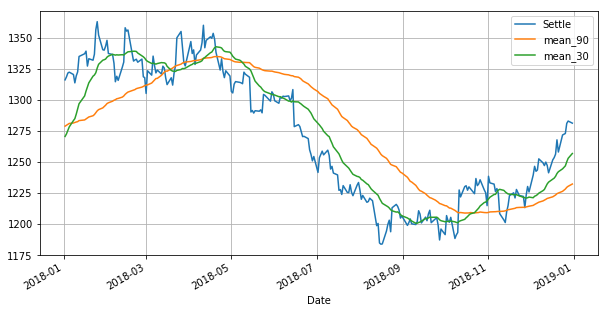

In [89]:
gold = mean_calculation(gold, 90, 30)
gold[['Settle', 'mean_90', 'mean_30']].loc[gold.index > validate_date].plot(figsize=(10,5), grid=True)

In [90]:
# dow_amount = 10000/dow[dow.index == '2018-01-01'].Settle
# print(dow.loc[(dow.index >= '2018-01-01') & (dow.index < '2018-01-02')].Settle)
# print(dow_amount)
nasdaq_amount = 10000/nasdaq.loc[(nasdaq.index >= '2018-01-02') & (nasdaq.index < '2018-01-03')].Settle.values[0]

nasdaq = nasdaq.loc[(nasdaq.index <= '2018-12-30')]
# dow = dow.loc[(dow.index <= '2018-12-31')]
# gold_mean.rename(columns={'account': 'Mean Strategy', 'base': '10000'}).head()

In [91]:
nasdaq.loc[(nasdaq.index >= '2018-01-02') & (nasdaq.index < '2018-01-03')].Settle.values[0]

6514.75

In [92]:
nasdaq_amount

1.5349783184312522

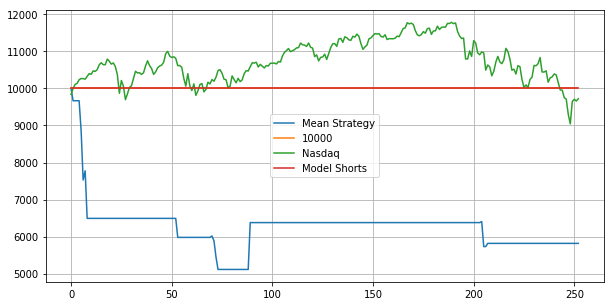

In [93]:
gold_mean = mean_reversal_account(gold.loc[gold.index > validate_date], gold_gains.loc[gold_gains.index > validate_date], trade_days=5)
gold_mean['base'] = gold_mean.account.apply(lambda x: 10000)
gold_mean['Nasdaq'] = nasdaq.Settle.values[-253:]
gold_mean['Nasdaq'] = gold_mean['Nasdaq']*nasdaq_amount

pd.concat([gold_mean.rename(columns={'account': 'Mean Strategy', 'base': '10000'}), 
           gold_account.rename(columns={'account': 'Model Shorts'})[['Model Shorts']],
          ], 
          axis=1).plot(figsize=(10,5), grid=True)

In [94]:
gold_mean.head()

,account,base,Nasdaq
0,10000.0,10000,9837.292298
1,9667.5,10000,10000.000000
2,9667.5,10000,10107.064738
3,9667.5,10000,10136.229326
4,9667.5,10000,10234.851683


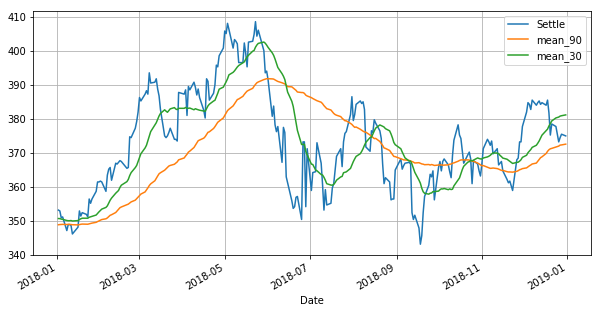

In [95]:
corn = mean_calculation(corn, 90, 30)
corn[['Settle', 'mean_90', 'mean_30']].loc[corn.index > validate_date].plot(figsize=(10,5), grid=True)

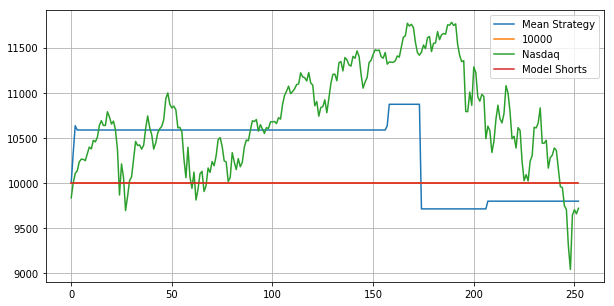

In [96]:
corn_mean = mean_reversal_account(corn.loc[corn.index > validate_date], corn_gains.loc[corn_gains.index > validate_date], trade_days=3)
corn_mean['base'] = corn_mean.account.apply(lambda x: 10000)
corn_mean['Nasdaq'] = nasdaq.Settle.values[-253:]
corn_mean['Nasdaq'] = corn_mean['Nasdaq']*nasdaq_amount

pd.concat([corn_mean.rename(columns={'account': 'Mean Strategy', 'base': '10000'}), 
           corn_account.rename(columns={'account': 'Model Shorts'})[['Model Shorts']]], 
          axis=1).plot(figsize=(10,5), grid=True)

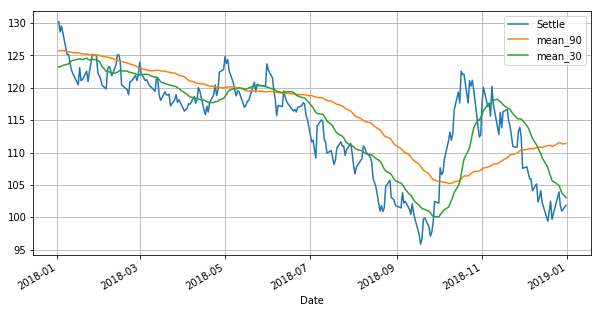

In [97]:
coffee = mean_calculation(coffee, 90, 30)
coffee[['Settle', 'mean_90', 'mean_30']].loc[coffee.index > validate_date].plot(figsize=(10,5), grid=True)

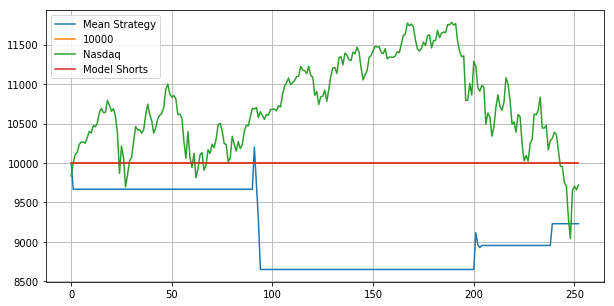

In [98]:
coffee_mean = mean_reversal_account(coffee.loc[coffee.index > validate_date], 
                                    coffee_gains.loc[coffee_gains.index > validate_date], 
                                    trade_days=5)
coffee_mean['base'] = coffee_mean.account.apply(lambda x: 10000)
coffee_mean['Nasdaq'] = nasdaq.Settle.values[-253:]
coffee_mean['Nasdaq'] = coffee_mean['Nasdaq']*nasdaq_amount

pd.concat([coffee_mean.rename(columns={'account': 'Mean Strategy', 'base': '10000'}), 
           coffee_account.rename(columns={'account': 'Model Shorts'})[['Model Shorts']],
          ], 
          axis=1).plot(figsize=(10,5), grid=True)